# UEBA: AWD-LSTM based Solution - Trainer

## Notebook description

This notebook trains a LSTM-based model using sequential data: 
  - Input files are expected to contain two: (1) timesamp and (2) event_id (categorical).
  - Users should eiter order the sequential data in adavance or sort it after reading from disk.
  - Either way is OK. Just make sure that the sorting process does not alterate the expected order in the sequence (think of what happens when two tokens have the same timestamp?).

## Initial setup and imports

In [1]:
# %matplotlib inline: To plot figures inline.
# %reload_ext autoreload: To reload modules automatically before entering the execution of code.
# %autoreload 2: The option 2 Reloads all modules (except those excluded by %aimport).
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Imports
import html
#import pandas as pd              # To be deleted when fastai is present
#import collections as co         # To be deleted when fastai is present
import seaborn as sns
from fastai.io import *
from pathlib import Path
from fastai.text import *
import matplotlib.pyplot as plt
from scipy.stats import rankdata

In [3]:
# Pandas plotting setup
pd.set_option('display.max_colwidth', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 5000)
sns.set_style('whitegrid')

In [4]:
# Print versions
print (f'Python version: {sys.version[:5]}')
print(f'PyTorch version: {torch.__version__[:5]}')
print(f'CUDA version   : {torch.version.cuda}')
print(f'CuDNN version: {torch.backends.cudnn.version()}')

Python version: 3.6.1
PyTorch version: 0.3.1
CUDA version   : 9.0.176
CuDNN version: 7005


In [5]:
# Check for CUDA. Must return True if there is an working NVidia GPU set up.
print(torch.cuda.is_available())
# Check CuDNN, a NVidia package that provides special accelerated functions for deep learning.
print(torch.backends.cudnn.enabled)

True
True


In [6]:
# See details of GPU usage:
!nvidia-smi

Wed Jun 17 00:57:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:04:00.0 Off |                  N/A |
| 49%   78C    P2   245W / 250W |   8623MiB / 12196MiB |     76%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:05:00.0 Off |                  N/A |
| 49%   78C    P2   234W / 250W |   8623MiB / 12196MiB |     66%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [7]:
# Set device
torch.cuda.set_device(5)

In [8]:
# Enable benchmark mode in cudnn. This way, cudnn will look for the optimal set of algorithms for that 
# particular configuration.
torch.backends.cudnn.benchmark=True

## Path setup

In [10]:
# Set Path
path_all      = Path('<path_to_file_with_all_data>')
path_trn      = Path('<path_to_file_with_trn_data-a_portion_of_all_data>')
path_val      = Path('<path_to_file_with_val_data-a_portion_of_all_data>')
path_test     = Path('<path_to_file_with_tet_data-a_portion_of_all_data>')

In [11]:
# Filenames
file_all  = '<file_with_all_data>.pkl'
file_trn  = '<file_with_trn_portion_from_all_data>.pkl'
file_val  = '<file_with_val_portion_from_all_data>.pkl'
file_test = '<file_with_test_portion_from_all_data>.pkl'

## Get trn, val and test sequences, list of all possible events and envent-to-id dictionaries

In [12]:
# Read dataset
df_all = pd.read_pickle(path_all/file_all)
df_trn = pd.read_pickle(path_trn/file_trn)
df_val = pd.read_pickle(path_val/file_val)
df_test = pd.read_pickle(path_test/file_test)
df_test.sort_values(by='time', inplace=True)
df_test.reset_index(inplace=True, drop=True)

In [13]:
# Get all events dictionaries
events_all = df_all['event_id'].tolist()
stoi = {e: i for i, e in enumerate(events_all)}
itos = {i: e for i, e in enumerate(events_all)}

In [18]:
# Get trn, val and test sequences (as always)
seq_event_trn  = df_trn['event_id'].tolist() 
seq_event_val  = df_val['event_id'].tolist()
seq_event_test = df_test['event_id'].tolist()

In [ ]:
# Numericalize trn, val and test sequences
def numericalize(tokens):
    return [stoi[token] for token in tokens]
seq_id_trn  = numericalize(seq_event_trn)
seq_id_val  = numericalize(seq_event_val)
seq_id_test = numericalize(seq_event_test)
print(f'trn: {len(seq_id_trn)}')
print(f'val: {len(seq_id_val)}')
print(f'test: {len(seq_id_test)}')

## Compare val and test sequences to trn sequence

In [ ]:
# Plot trn sequence
frequencies = Counter(e for e in seq_event_trn)
labels, y = zip(*frequencies.most_common())
x = [i for i, label in enumerate(labels)]
plt.figure(figsize=(18,6))
plt.xticks(rotation='vertical')
plt.bar(x, y, tick_label=labels)
plt.show()

In [ ]:
# Plot val sequence
frequencies = Counter(e for e in seq_event_val)
labels, y = zip(*frequencies.most_common())
x = [i for i, label in enumerate(labels)]
plt.figure(figsize=(18,6))
plt.xticks(rotation='vertical')
plt.bar(x, y, tick_label=labels)
plt.show()

In [ ]:
# Plot test sequence
frequencies = Counter(e for e in seq_event_test)
labels, y = zip(*frequencies.most_common())
x = [i for i, label in enumerate(labels)]
plt.figure(figsize=(18,6))
plt.xticks(rotation='vertical')
plt.bar(x, y, tick_label=labels)
plt.show()

In [ ]:
def print_differences(events_all, events_trn, events_val, events_test):
    print('Length of sequences:')
    print('--------------------')
    print(f'Length of trn : {len(events_trn)}')
    print(f'Length of val : {len(events_val)}')
    print(f'Length of test: {len(events_test)}')
    
    print('')
    print('Number of events:')
    print('-----------------')
    print(f'All possible events  : {len(events_all)}')
    print(f'Unique events in trn : {len(set(events_trn))}')
    print(f'Unique events in val : {len(set(events_val))}')
    print(f'Unique events in test: {len(set(events_test))}')
    
    print('')
    print('Training vs Validation:')
    print('-----------------------')
    print(f'Events in trn not in val: {len(set(events_trn)-set(events_val))}')
    print(f'Events in val not in trn: {len(set(events_val)-set(events_trn))}')
    
    print('')
    print('Training vs Testing:')
    print('--------------------')
    print(f'Events in trn not in test: {len(set(events_trn)-set(events_test))}')
    print(f'Events in test not in trn: {len(set(events_test)-set(events_trn))}')
    
    print('')
    print('Percentages of non-seen events:')
    print('-------------------------------')
    print(f'\nIn the validation sequence:')
    events_val_not_in_trn = list(set(events_val) - set(events_trn))
    count = [0]
    if len(events_val_not_in_trn) != 0:
        count = [events_val.count(e) for e in events_val_not_in_trn]
        events_val_not_in_trn, count = zip(*sorted(zip(events_val_not_in_trn, count), reverse=True, key=lambda x: x[1]))
        for i, e in enumerate(events_val_not_in_trn):
            print(f'{e}: {count[i]}')
        print(f'Percentage: {sum(count)}/{len(events_val)} ({round((sum(count)/len(events_val))*100, 3)}%)')        
    print(f'Percentage: {sum(count)}/{len(events_val)} ({round((sum(count)/len(events_val))*100, 3)}%)')
    print(f'\nIn the testing sequence:')
    events_test_not_in_trn = list(set(events_test) -set(events_trn))
    count = [events_test.count(e) for e in events_test_not_in_trn]
    events_test_not_in_trn, count = zip(*sorted(zip(events_test_not_in_trn, count), reverse=True, key=lambda x: x[1]))
    for i, e in enumerate(events_test_not_in_trn):
        print(f'{e}: {count[i]}')
    print(f'Percentage: {sum(count)}/{len(events_test)} ({round((sum(count)/len(events_test))*100, 3)}%)')

In [20]:
# Print differences among dtasets
print_differences(events_all, seq_event_trn, seq_event_val, seq_event_test)

## Training AWD LSTM Model

### Create learner

#### Get Learner in function

In [29]:
def get_learner(multiplier):
    
    # Data Model Hyper Parameters
    bptt=64
    bs=64
    vocab_size = len(events_all)
    
    # Data Model
    trn_dl  = LanguageModelLoader(np.stack(seq_id_trn), bs, bptt)
    val_dl  = LanguageModelLoader(np.stack(seq_id_val), bs, bptt)
    test_dl = LanguageModelLoader(np.stack(seq_id_test), bs, bptt)
    md = LanguageModelData(path=path_model, pad_idx=None, n_tok=vocab_size, bs=bs, bptt=bptt, 
                       trn_dl=trn_dl, val_dl=val_dl, test_dl=test_dl)
    
    # Architecture Hyper Parameters
    emb_sz=16
    nh=100
    nl=3
    opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
    drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*multiplier
    
    # LSTM Based Model Model
    learner = md.get_model(opt_fn, emb_sz, nh, nl, 
                       dropouti=drops[0], 
                       dropout=drops[1], 
                       wdrop=drops[2], 
                       dropoute=drops[3], 
                       dropouth=drops[4])
    learner.metrics = [accuracy]
    learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1) # AR and TAR
    learner.clip = 0.3
    learner.unfreeze()
    return learner

#### Get learner step-by-step (to play and learn about each step)

In [19]:
# Data Model Hyper Parameters
bptt=64
bs=64
vocab_size = len(events_all)

In [20]:
# Data Model
trn_dl  = LanguageModelLoader(np.stack(seq_id_trn), bs, bptt)
val_dl  = LanguageModelLoader(np.stack(seq_id_val), bs, bptt)
test_dl = LanguageModelLoader(np.stack(seq_id_test), bs, bptt)
md = LanguageModelData(path=path_model, pad_idx=None, n_tok=vocab_size, bs=bs, bptt=bptt, 
                       trn_dl=trn_dl, val_dl=val_dl, test_dl=test_dl)

In [21]:
# Architecture Hyper Parameters
emb_sz=16
nh=100
nl=3
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.5

In [22]:
# LSTM Based Model Model
learner = md.get_model(opt_fn, emb_sz, nh, nl, 
                       dropouti=drops[0], 
                       dropout=drops[1], 
                       wdrop=drops[2], 
                       dropoute=drops[3], 
                       dropouth=drops[4])
learner.metrics = [accuracy]
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1) # AR and TAR
learner.clip = 0.3
learner.unfreeze()

In [66]:
#learner.get_layer_groups

### Train learner 

In this section, an example of how to train and set up different hyperparameters is given. 

#### First training (drops multiplier of 0.50)

In [30]:
# Find Learning Rate (LR)
learner = get_learner(0.5)
learner.lr_find()

epoch      trn_loss   val_loss   accuracy                 
    0      4.474746   14.421644  0.0       



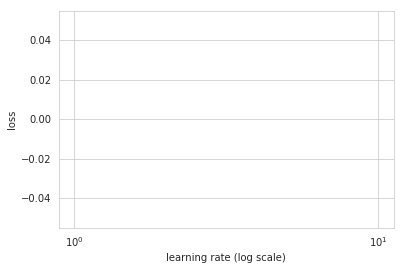

In [31]:
# Plot learning rate curve
learner.sched.plot()

In [32]:
%%time
# (1) 256, (2) 1024, (3) 16384
lrs=1e-1
wds=1e-6
learner.fit(lrs=lrs, n_cycle=1, cycle_len=16384, wds=wds, use_clr=(32,4))
#learner.fit(lrs=lrs, n_cycle=4, cycle_len=1, cycle_mult=2, wds=wds)

epoch      trn_loss   val_loss   accuracy                 
    0      4.944169   4.666331   0.594499  
    1      4.530261   3.724488   0.590808                 
    2      4.019111   2.879903   0.598384                 
    3      3.523455   2.28922    0.596563                 
    4      3.093862   1.962421   0.598108                 
    5      2.735238   1.673993   0.610819                 
    6      2.428998   1.456187   0.64419                  
    7      2.161465   1.302432   0.65418                  
    8      1.92273    1.123379   0.790565                 
    9      1.712316   0.973205   0.831904                 
    10     1.529452   0.911971   0.84123                  
    11     1.374256   0.808491   0.83966                  
    12     1.248413   0.79457    0.840096                 
    13     1.139726   0.749041   0.844169                 
    14     1.04959    0.711924   0.845344                 
    15     0.974804   0.677471   0.845997                  
    16     

   485     0.2814     0.369045   0.899757                  
   486     0.275594   0.369248   0.903846                  
   487     0.266612   0.377771   0.898951                  
   488     0.278006   0.380049   0.90166                   
   489     0.276149   0.355372   0.904905                  
   490     0.267716   0.36283    0.904627                  
   491     0.271125   0.368908   0.902574                  
   492     0.273642   0.378098   0.900443                  
   493     0.26801    0.375932   0.902866                  
   494     0.261603   0.383952   0.895744                  
   495     0.257459   0.37026    0.897861                  
   496     0.255599   0.374372   0.900692                  
   497     0.265547   0.372503   0.901714                  
   498     0.261596   0.383499   0.898307                  
   499     0.261278   0.374518   0.89926                   
   500     0.263548   0.372854   0.904479                  
   501     0.26212    0.377714   0.89790

   757     0.365101   0.383943   0.890321                  
   758     0.351917   0.383151   0.893689                  
   759     0.348873   0.385029   0.894052                  
   760     0.341677   0.386702   0.891149                  
   761     0.334046   0.37407    0.894981                  
   762     0.332492   0.375334   0.897094                  
   763     0.328152   0.379509   0.894331                  
   764     0.321211   0.381062   0.89484                   
   765     0.31626    0.380572   0.891442                  
   766     0.319939   0.386331   0.892373                 
   767     0.316164   0.386375   0.886175                  
   768     0.31426    0.391745   0.880008                  
   769     0.311695   0.393047   0.883637                  
   770     0.308393   0.393914   0.886318                  
   771     0.308711   0.39058    0.888877                  
   772     0.324905   0.4056     0.872396                  
   773     0.322132   0.387931   0.887835

   1029    0.270731   0.395998   0.873698                  
   1030    0.310262   0.383801   0.898759                 
   1031    0.302351   0.376021   0.899262                  
   1032    0.294767   0.393409   0.898875                  
   1033    0.294752   0.386636   0.883624                  
   1034    0.287611   0.381837   0.894954                  
   1035    0.302503   0.390767   0.881665                  
   1036    0.311137   0.377075   0.898388                  
   1037    0.333286   0.386636   0.899007                  
   1038    0.327415   0.391817   0.897602                  
   1039    0.352447   0.38216    0.881665                  
   1040    0.330884   0.382623   0.882036                  
   1041    0.314516   0.367373   0.900493                  
   1042    0.303806   0.369962   0.901142                  
   1043    0.297502   0.38157    0.90015                   
   1044    0.28979    0.386194   0.894039                 
   1045    0.284425   0.380409   0.894654 

   1301    0.278032   0.383447   0.884454                  
   1302    0.286525   0.378643   0.892394                  
   1303    0.290248   0.381617   0.886875                 
   1304    0.341047   0.374271   0.900604                  
   1305    0.322357   0.391413   0.888081                  
   1306    0.310872   0.379915   0.880208                  
   1307    0.310516   0.368218   0.89994                   
   1308    0.297448   0.377426   0.898763                  
   1309    0.28828    0.370403   0.901007                  
   1310    0.281418   0.376407   0.902955                  
   1311    0.276581   0.396374   0.878803                  
   1312    0.343004   0.373496   0.90183                   
   1313    0.375487   0.376676   0.903372                  
   1314    0.35829    0.37162    0.899714                  
   1315    0.335132   0.366025   0.902218                  
   1316    0.32409    0.382254   0.899644                  
   1317    0.307772   0.381506   0.874017

   1573    0.303502   0.381309   0.89864                   
   1574    0.298129   0.389463   0.879036                  
   1575    0.292616   0.374831   0.899597                  
   1576    0.28788    0.373795   0.891416                  
   1577    0.281948   0.380797   0.894086                  
   1578    0.277737   0.397865   0.874692                  
   1579    0.275403   0.378144   0.895408                  
   1580    0.274051   0.392212   0.877757                  
   1581    0.293478   0.387155   0.877886                  
   1582    0.289439   0.406726   0.882347                  
   1583    0.287889   0.383509   0.889735                  
   1584    0.300767   0.394918   0.895145                  
   1585    0.295042   0.377087   0.8987                    
   1586    0.296345   0.384321   0.886221                  
   1587    0.290576   0.39585    0.876863                  
   1588    0.308605   0.417104   0.869191                  
   1589    0.302313   0.361686   0.90087

   1845    0.284549   0.384273   0.896627                  
   1846    0.280164   0.391498   0.893086                  
   1847    0.275479   0.372015   0.900699                  
   1848    0.273424   0.378658   0.90091                   
   1849    0.271328   0.386042   0.898125                  
   1850    0.273557   0.377585   0.896497                  
   1851    0.277904   0.375193   0.896855                  
   1852    0.275241   0.369969   0.899687                  
   1853    0.274989   0.375211   0.888158                  
   1854    0.274605   0.369192   0.90118                   
   1855    0.274117   0.377256   0.890097                  
   1856    0.276847   0.369017   0.895999                  
   1857    0.277196   0.372262   0.897482                  
   1858    0.286842   0.38684    0.888933                  
   1859    0.318005   0.379926   0.888685                  
   1860    0.308047   0.380589   0.900625                  
   1861    0.299228   0.380116   0.90076

   2117    0.330984   0.394536   0.894557                  
   2118    0.326043   0.377712   0.893914                  
   2119    0.357409   0.385466   0.894017                  
   2120    0.347912   0.408145   0.894143                  
   2121    0.341745   0.380495   0.895968                  
   2122    0.34194    0.386433   0.89353                   
   2123    0.341627   0.386384   0.891133                  
   2124    0.343386   0.386982   0.89281                   
   2125    0.345073   0.379071   0.8925                    
   2126    0.339501   0.382588   0.893014                  
   2127    0.332904   0.3815     0.89741                   
   2128    0.326796   0.401575   0.896484                  
   2129    0.325703   0.395794   0.89116                   
   2130    0.32213    0.39337    0.893229                  
   2131    0.331281   0.378378   0.893587                  
   2132    0.339573   0.395056   0.891183                 
   2133    0.331651   0.383273   0.895292

   2389    0.292842   0.365282   0.893851                  
   2390    0.330357   0.38359    0.895215                  
   2391    0.338453   0.383123   0.892751                  
   2392    0.333309   0.405275   0.892812                  
   2393    0.34856    0.39003    0.890827                  
   2394    0.335857   0.391642   0.892064                  
   2395    0.329115   0.412193   0.893872                  
   2396    0.328551   0.375794   0.890832                  
   2397    0.387732   0.376399   0.894052                  
   2398    0.366253   0.401971   0.893178                  
   2399    0.353098   0.379322   0.893548                  
   2400    0.338887   0.399368   0.893936                  
   2401    0.329988   0.382677   0.894167                  
   2402    0.33557    0.400118   0.889234                  
   2403    0.331191   0.402729   0.892689                  
   2404    0.323097   0.380132   0.89254                   
   2405    0.317977   0.365568   0.89152

   2661    0.291511   0.36151    0.896279                  
   2662    0.297854   0.367247   0.895481                  
   2663    0.296686   0.38725    0.892045                  
   2664    0.294641   0.358709   0.893893                  
   2665    0.296927   0.35851    0.895965                  
   2666    0.303115   0.367272   0.895292                  
   2667    0.301279   0.369835   0.895262                  
   2668    0.310049   0.369154   0.897949                 
   2669    0.304199   0.376101   0.890759                  
   2670    0.30162    0.379252   0.893522                  
   2671    0.309742   0.367086   0.898175                 
   2672    0.301558   0.368966   0.896226                  
   2673    0.317933   0.370579   0.894383                  
   2674    0.334354   0.397956   0.89197                   
   2675    0.330189   0.408311   0.892667                  
   2676    0.324929   0.386411   0.897626                  
   2677    0.327313   0.391053   0.894942 

   2933    0.301458   0.366065   0.894805                  
   2934    0.299729   0.399108   0.889891                  
   2935    0.301662   0.385701   0.894326                  
   2936    0.299935   0.383101   0.890004                  
   2937    0.31063    0.394306   0.886563                  
   2938    0.310431   0.411237   0.88483                   
   2939    0.309815   0.393745   0.888672                 
   2940    0.306656   0.380206   0.89283                   
   2941    0.309433   0.382533   0.888911                  
   2942    0.3081     0.379879   0.892018                  
   2943    0.307085   0.399833   0.89185                   
   2944    0.305844   0.403485   0.891927                  
   2945    0.329863   0.397547   0.894271                  
   2946    0.325869   0.384038   0.889423                  
   2947    0.327065   0.409612   0.893066                  
   2948    0.325169   0.366762   0.89209                   
   2949    0.320079   0.381093   0.88928 

   3205    0.373322   0.405769   0.886719                  
   3206    0.360428   0.392211   0.893794                  
   3207    0.347711   0.394492   0.892238                  
   3208    0.335937   0.365617   0.893194                  
   3209    0.331568   0.382387   0.890035                  
   3210    0.328682   0.368861   0.893833                  
   3211    0.329535   0.376747   0.891326                  
   3212    0.325461   0.388677   0.891961                  
   3213    0.359273   0.385496   0.892702                  
   3214    0.361517   0.389874   0.891836                  
   3215    0.350107   0.37379    0.893159                 
   3216    0.361454   0.374889   0.889315                  
   3217    0.351244   0.382012   0.892578                  
   3218    0.362456   0.381799   0.897127                  
   3219    0.350572   0.380178   0.895655                  
   3220    0.338919   0.381721   0.897393                  
   3221    0.341587   0.412785   0.894505

   3477    0.443261   0.389557   0.891641                  
   3478    0.425332   0.389327   0.887601                  
   3479    0.406084   0.388891   0.886589                  
   3480    0.392701   0.381114   0.890836                  
   3481    0.376345   0.368842   0.894725                  
   3482    0.362028   0.366163   0.893503                  
   3483    0.35117    0.373444   0.892259                  
   3484    0.345817   0.379833   0.895474                  
   3485    0.341569   0.373718   0.892736                  
   3486    0.335505   0.365543   0.890428                  
   3487    0.339534   0.375823   0.893888                  
   3488    0.366604   0.38038    0.889249                  
   3489    0.435769   0.406974   0.888108                  
   3490    0.42136    0.371074   0.894176                  
   3491    0.404333   0.378647   0.890728                  
   3492    0.385384   0.376342   0.895058                  
   3493    0.373982   0.368986   0.89217

   3749    0.376834   0.365251   0.891464                  
   3750    0.368314   0.364247   0.88954                   
   3751    0.361437   0.378015   0.885685                  
   3752    0.358697   0.381912   0.891734                  
   3753    0.373273   0.396494   0.887093                  
   3754    0.390002   0.401311   0.886769                  
   3755    0.388026   0.392853   0.891136                  
   3756    0.374703   0.376636   0.888877                  
   3757    0.378943   0.38767    0.890319                  
   3758    0.381137   0.408469   0.88193                   
   3759    0.370441   0.397571   0.888775                  
   3760    0.362763   0.396806   0.887658                  
   3761    0.356994   0.406428   0.891039                  
   3762    0.351515   0.390988   0.886422                  
   3763    0.353814   0.396195   0.89185                   
   3764    0.357786   0.387583   0.89233                   
   3765    0.355122   0.378823   0.89052

   4021    0.345667   0.423159   0.886267                  
   4022    0.355085   0.401023   0.88123                   
   4023    0.378615   0.506497   0.874407                  
   4024    0.449636   0.87912    0.667915                 
   4025    0.549927   0.901051   0.844447                  
   4026    0.679754   1.459523   0.766442                  
   4027    0.775448   1.071864   0.765625                  
   4028    0.851406   0.801987   0.849422                  
   4029    0.961606   4.195189   0.688616                  
   4030    1.177779   0.980028   0.776354                 
   4031    1.106904   0.694069   0.856737                 
   4032    1.081311   1.629617   0.855843                 
   4033    1.059984   0.700819   0.84965                  
   4034    0.993322   0.820595   0.847786                  
   4035    0.950374   0.591759   0.867349                 
   4036    0.910336   0.76559    0.855966                  
   4037    0.880552   0.631249   0.862079     

   4293    0.408446   0.407764   0.886029                  
   4294    0.399698   0.41629    0.8795                   
   4295    0.392558   0.401693   0.885146                  
   4296    0.385657   0.386063   0.888867                  
   4297    0.382416   0.394963   0.888596                  
   4298    0.407023   0.390854   0.887728                  
   4299    0.40743    0.38974    0.88797                   
   4300    0.403012   0.404479   0.888254                  
   4301    0.427249   0.407765   0.884716                  
   4302    0.444558   0.392372   0.888936                  
   4303    0.425593   0.397124   0.888639                  
   4304    0.417976   0.388632   0.887292                  
   4305    0.405049   0.401268   0.887579                  
   4306    0.409728   0.407209   0.886486                  
   4307    0.401402   0.40008    0.885167                  
   4308    0.391218   0.3801     0.888933                  
   4309    0.38682    0.389089   0.888877

   4565    0.377644   0.389377   0.891354                  
   4566    0.37468    0.553745   0.878542                  
   4567    0.369503   0.378864   0.889992                  
   4568    0.370462   0.402566   0.890733                  
   4569    0.368216   0.395803   0.889613                  
   4570    0.376819   0.398373   0.882053                  
   4571    0.378147   0.397478   0.890522                  
   4572    0.373915   0.401238   0.889617                  
   4573    0.370074   0.390277   0.889103                 
   4574    0.383621   0.384076   0.891582                  
   4575    0.399379   0.408306   0.886616                  
   4576    0.389693   0.389351   0.889992                  
   4577    0.379421   0.395476   0.888393                  
   4578    0.37264    0.391496   0.890414                  
   4579    0.370485   0.413744   0.88898                  
   4580    0.37716    0.396645   0.889223                  
   4581    0.370065   0.39134    0.891222 

   4837    0.382646   0.408179   0.888542                  
   4838    0.374765   0.383797   0.888842                  
   4839    0.373624   0.379471   0.888197                  
   4840    0.369086   0.385224   0.888276                  
   4841    0.390065   0.391699   0.891843                  
   4842    0.395628   0.384611   0.886919                  
   4843    0.385136   0.385818   0.886262                  
   4844    0.379338   0.383229   0.890219                  
   4845    0.372369   0.394005   0.887107                  
   4846    0.365477   0.389841   0.889687                  
   4847    0.374854   0.402074   0.885282                  
   4848    0.373398   0.378444   0.889002                  
   4849    0.374465   0.398699   0.888125                  
   4850    0.378573   0.37922    0.889479                  
   4851    0.372808   0.422749   0.885617                  
   4852    0.381659   0.390548   0.887541                  
   4853    0.374183   0.384453   0.88898

   5109    0.348034   0.376347   0.892027                  
   5110    0.364378   0.379065   0.885519                  
   5111    0.373943   0.382644   0.889569                  
   5112    0.36957    0.384065   0.88661                  
   5113    0.368907   0.381671   0.891812                  
   5114    0.371942   0.385125   0.8869                    
   5115    0.366608   0.370963   0.888936                  
   5116    0.363352   0.372802   0.884623                  
   5117    0.35943    0.388377   0.891119                  
   5118    0.372297   0.402224   0.880588                  
   5119    0.367447   0.391582   0.884577                  
   5120    0.364851   0.387719   0.888901                  
   5121    0.367494   0.379326   0.892504                  
   5122    0.40161    0.39154    0.882312                  
   5123    0.393958   0.380507   0.885865                  
   5124    0.447816   0.402013   0.887093                  
   5125    0.435133   0.380724   0.884018

   5381    0.352701   0.368032   0.887935                  
   5382    0.352806   0.374198   0.888276                  
   5383    0.347219   0.384548   0.890522                  
   5384    0.345172   0.375444   0.889043                  
   5385    0.34635    0.381287   0.888659                  
   5386    0.349789   0.374319   0.887119                 
   5387    0.352746   0.383186   0.885135                  
   5388    0.35354    0.440024   0.882915                  
   5389    0.394626   0.37946    0.889687                  
   5390    0.388901   0.382095   0.886895                  
   5391    0.379816   0.380255   0.889383                 
   5392    0.375538   0.380026   0.893014                  
   5393    0.376276   0.405527   0.886789                  
   5394    0.371791   0.375036   0.888574                  
   5395    0.368554   0.369844   0.887921                  
   5396    0.368767   0.390238   0.887142                  
   5397    0.374755   0.378024   0.890419 

   5653    0.346942   0.375175   0.889262                  
   5654    0.377143   0.411891   0.886402                  
   5655    0.391835   0.381544   0.888737                  
   5656    0.378846   0.376674   0.886746                  
   5657    0.372286   0.376969   0.88506                   
   5658    0.362847   0.371717   0.887129                  
   5659    0.356356   0.373486   0.890203                  
   5660    0.355365   0.373034   0.891416                  
   5661    0.353614   0.377478   0.885717                  
   5662    0.35731    0.381533   0.882504                  
   5663    0.364691   0.402781   0.885578                  
   5664    0.364782   0.388837   0.883822                  
   5665    0.362744   0.374944   0.89043                   
   5666    0.367223   0.391158   0.889438                  
   5667    0.368593   0.373789   0.888037                  
   5668    0.368389   0.380387   0.883899                  
   5669    0.370347   0.373816   0.89201

   5925    0.356935   0.376045   0.8889                    
   5926    0.36209    0.382327   0.887683                  
   5927    0.356346   0.372753   0.889093                  
   5928    0.366399   0.382781   0.88963                   
   5929    0.364584   0.38454    0.883175                  
   5930    0.360053   0.424378   0.883681                  
   5931    0.409585   0.397681   0.888799                  
   5932    0.394585   0.382366   0.887663                  
   5933    0.383563   0.375542   0.887821                  
   5934    0.374521   0.393094   0.886279                  
   5935    0.370038   0.37375    0.887341                 
   5936    0.363516   0.371614   0.884395                  
   5937    0.358311   0.392129   0.887168                  
   5938    0.353384   0.381514   0.883552                  
   5939    0.349626   0.377046   0.887952                 
   5940    0.351956   0.379745   0.885729                  
   5941    0.358693   0.378684   0.88643  

   6197    0.365037   0.376948   0.885513                  
   6198    0.358044   0.379944   0.8825                    
   6199    0.356797   0.372762   0.88991                   
   6200    0.373225   0.37575    0.891843                  
   6201    0.361426   0.378297   0.889905                  
   6202    0.356739   0.379997   0.886744                  
   6203    0.35911    0.377623   0.886146                  
   6204    0.354257   0.384321   0.889371                  
   6205    0.348155   0.383557   0.887649                  
   6206    0.346972   0.397795   0.889583                  
   6207    0.343031   0.371551   0.885696                  
   6208    0.340588   0.379309   0.8897                    
   6209    0.355168   0.381168   0.885308                  
   6210    0.350863   0.382892   0.889604                  
   6211    0.347322   0.391697   0.889886                  
   6212    0.34535    0.390067   0.878856                  
   6213    0.34574    0.379251   0.88813

   6469    0.353147   0.38009    0.884916                  
   6470    0.353429   0.379326   0.88722                   
   6471    0.351474   0.39046    0.892516                  
   6472    0.350094   0.379808   0.893014                  
   6473    0.35133    0.382803   0.886599                  
   6474    0.371723   0.385339   0.887042                  
   6475    0.367849   0.385487   0.888596                  
   6476    0.365314   0.403448   0.882943                  
   6477    0.36173    0.381691   0.888421                  
   6478    0.353536   0.382823   0.890234                  
   6479    0.354908   0.385136   0.888147                  
   6480    0.352487   0.380988   0.888091                  
   6481    0.383317   0.374662   0.892492                  
   6482    0.377884   0.383845   0.886771                  
   6483    0.37052    0.373305   0.891681                  
   6484    0.369419   0.393535   0.885045                  
   6485    0.361513   0.38659    0.88928

   6741    0.340583   0.370187   0.887784                  
   6742    0.335543   0.365785   0.891021                  
   6743    0.346481   0.395089   0.88292                   
   6744    0.349497   0.398296   0.883125                  
   6745    0.360584   0.372152   0.892428                  
   6746    0.370235   0.374662   0.887838                  
   6747    0.366107   0.411899   0.889088                  
   6748    0.362657   0.392569   0.887097                  
   6749    0.357837   0.38214    0.889901                  
   6750    0.365135   0.384821   0.889375                  
   6751    0.379075   0.407165   0.882607                  
   6752    0.368523   0.381631   0.889205                  
   6753    0.361411   0.375273   0.889487                  
   6754    0.35593    0.381418   0.887608                  
   6755    0.349576   0.374033   0.892814                 
   6756    0.346201   0.375913   0.890323                  
   6757    0.340399   0.377942   0.888466

   7013    0.336165   0.376137   0.882491                  
   7014    0.331137   0.381321   0.886308                 
   7015    0.357487   0.389265   0.887012                  
   7016    0.350733   0.385074   0.885016                  
   7017    0.351839   0.37994    0.884233                  
   7018    0.350684   0.387587   0.888004                  
   7019    0.348772   0.393483   0.880144                  
   7020    0.347319   0.385123   0.885141                  
   7021    0.361559   0.379968   0.886285                  
   7022    0.356046   0.389467   0.888889                  
   7023    0.347032   0.392075   0.887731                  
   7024    0.343522   0.381016   0.889471                  
   7025    0.340705   0.379339   0.891036                  
   7026    0.336738   0.369591   0.887861                  
   7027    0.332587   0.378737   0.88721                   
   7028    0.329848   0.380108   0.888261                  
   7029    0.329617   0.365026   0.888133

   7285    0.336565   0.376616   0.890423                  
   7286    0.335843   0.382038   0.888038                  
   7287    0.336562   0.376186   0.889509                  
   7288    0.336271   0.379871   0.88953                   
   7289    0.342372   0.374115   0.889468                  
   7290    0.354717   0.395354   0.888845                  
   7291    0.353808   0.379813   0.889738                  
   7292    0.345736   0.38702    0.88568                   
   7293    0.341414   0.370842   0.891031                  
   7294    0.337906   0.372298   0.887107                  
   7295    0.34166    0.375989   0.891927                  
   7296    0.340364   0.380133   0.88661                  
   7297    0.34082    0.391709   0.878125                  
   7298    0.339824   0.379784   0.889583                  
   7299    0.337162   0.393084   0.874575                  
   7300    0.337259   0.38536    0.891284                  
   7301    0.333498   0.371243   0.889167

   7557    0.32912    0.375972   0.888755                  
   7558    0.325962   0.380348   0.888947                  
   7559    0.32309    0.385288   0.885801                  
   7560    0.322611   0.38315    0.885856                  
   7561    0.325224   0.376247   0.886399                  
   7562    0.326053   0.391914   0.88174                   
   7563    0.324208   0.389921   0.888091                  
   7564    0.322571   0.372915   0.884631                  
   7565    0.320529   0.389938   0.881836                  
   7566    0.323861   0.390842   0.88444                   
   7567    0.324803   0.382432   0.889562                  
   7568    0.344897   0.401635   0.874698                  
   7569    0.340483   0.386516   0.881119                  
   7570    0.339507   0.390437   0.888302                  
   7571    0.334917   0.392719   0.882968                  
   7572    0.332008   0.384712   0.881332                  
   7573    0.334189   0.411203   0.87678

   7829    0.335594   0.388487   0.887093                  
   7830    0.334103   0.383112   0.889491                  
   7831    0.338262   0.381596   0.884014                  
   7832    0.337553   0.379213   0.891544                  
   7833    0.33707    0.380337   0.890323                  
   7834    0.333096   0.379102   0.888834                  
   7835    0.329991   0.379558   0.887314                 
   7836    0.327553   0.38026    0.888508                 
   7837    0.329726   0.377663   0.894335                  
   7838    0.334756   0.378944   0.887649                  
   7839    0.330779   0.379981   0.893958                  
   7840    0.330125   0.375846   0.887298                  
   7841    0.329492   0.384518   0.886418                  
   7842    0.32695    0.375525   0.885141                  
   7843    0.324064   0.377048   0.892118                  
   7844    0.321491   0.381462   0.88598                   
   7845    0.32018    0.37716    0.886205 

   8101    0.325188   0.381432   0.88719                   
   8102    0.328813   0.38337    0.886943                  
   8103    0.333954   0.385877   0.880544                  
   8104    0.357199   0.393372   0.88244                   
   8105    0.357747   0.379525   0.883318                  
   8106    0.351628   0.388522   0.88746                   
   8107    0.343385   0.397929   0.882812                  
   8108    0.335426   0.383475   0.888911                  
   8109    0.330328   0.38111    0.885999                  
   8110    0.327644   0.380992   0.88474                   
   8111    0.326095   0.386745   0.881427                  
   8112    0.333625   0.373851   0.890118                  
   8113    0.330042   0.381078   0.884537                 
   8114    0.327951   0.392296   0.879117                  
   8115    0.323956   0.383712   0.884293                  
   8116    0.326229   0.388832   0.887434                  
   8117    0.322389   0.386934   0.883734

   8373    0.326106   0.386679   0.887689                  
   8374    0.322331   0.372171   0.887336                  
   8375    0.322957   0.396994   0.8811                    
   8376    0.325776   0.389852   0.886996                  
   8377    0.325822   0.386601   0.886771                  
   8378    0.340744   0.392069   0.885381                  
   8379    0.337493   0.392656   0.887813                  
   8380    0.336924   0.389201   0.887083                  
   8381    0.338056   0.394175   0.886771                  
   8382    0.339497   0.381599   0.892339                  
   8383    0.338583   0.385678   0.889471                  
   8384    0.335655   0.363488   0.887831                  
   8385    0.332891   0.381312   0.888276                  
   8386    0.327487   0.37732    0.885451                  
   8387    0.324139   0.447687   0.887663                  
   8388    0.321017   0.398153   0.892207                  
   8389    0.319672   0.39156    0.89003

   8645    0.335507   0.379966   0.885988                  
   8646    0.332874   0.375588   0.885691                  
   8647    0.328092   0.37227    0.89328                   
   8648    0.321381   0.371115   0.884215                  
   8649    0.325562   0.373573   0.886616                  
   8650    0.32387    0.372569   0.888991                  
   8651    0.321604   0.373078   0.890118                  
   8652    0.319494   0.361731   0.892959                  
   8653    0.317232   0.372069   0.882359                  
   8654    0.317873   0.382475   0.888164                  
   8655    0.318389   0.373263   0.888975                  
   8656    0.318026   0.373552   0.886769                  
   8657    0.316371   0.374347   0.886843                  
   8658    0.31834    0.372452   0.886452                  
   8659    0.31958    0.370467   0.890208                  
   8660    0.319079   0.368914   0.892373                  
   8661    0.318174   0.373823   0.88975

   8917    0.313398   0.385728   0.892667                  
   8918    0.312826   0.380116   0.891026                  
   8919    0.329305   0.38261    0.890835                  
   8920    0.334881   0.383786   0.889084                  
   8921    0.332441   0.376334   0.887247                  
   8922    0.329324   0.380357   0.888038                  
   8923    0.331161   0.376313   0.889706                  
   8924    0.327195   0.378993   0.886535                  
   8925    0.322403   0.383396   0.889837                  
   8926    0.320994   0.391239   0.888817                  
   8927    0.318906   0.37517    0.887702                  
   8928    0.320431   0.376914   0.89164                   
   8929    0.322097   0.378581   0.890828                  
   8930    0.321154   0.385643   0.88483                   
   8931    0.31865    0.375451   0.889752                  
   8932    0.320212   0.384108   0.883065                 
   8933    0.325888   0.382671   0.894009

   9189    0.318589   0.374168   0.887663                  
   9190    0.315032   0.37988    0.886426                  
   9191    0.314403   0.377132   0.889052                  
   9192    0.316304   0.378933   0.886492                  
   9193    0.323517   0.385337   0.887456                  
   9194    0.319586   0.389652   0.889367                 
   9195    0.323412   0.37338    0.890118                  
   9196    0.320315   0.377874   0.888147                 
   9197    0.318525   0.381227   0.885762                  
   9198    0.316086   0.378193   0.887935                  
   9199    0.313322   0.377593   0.885172                  
   9200    0.310715   0.382686   0.892326                  
   9201    0.308896   0.372086   0.891039                  
   9202    0.316319   0.372928   0.886796                  
   9203    0.316894   0.381882   0.888004                  
   9204    0.316755   0.376236   0.891031                  
   9205    0.314626   0.365932   0.887003 

   9461    0.307753   0.369586   0.890008                 
   9462    0.308109   0.382633   0.887352                  
   9463    0.306271   0.370002   0.889151                  
   9464    0.316932   0.390117   0.885212                  
   9465    0.316209   0.365932   0.893086                  
   9466    0.316683   0.376018   0.885736                  
   9467    0.314502   0.364244   0.889996                  
   9468    0.310458   0.369196   0.886513                 
   9469    0.307876   0.375727   0.884336                  
   9470    0.306985   0.381453   0.884766                  
   9471    0.307821   0.366053   0.887153                  
   9472    0.305178   0.372774   0.888513                  
   9473    0.308769   0.381349   0.890412                  
   9474    0.305988   0.369149   0.887744                  
   9475    0.302155   0.381696   0.882407                  
   9476    0.344725   0.373056   0.883476                  
   9477    0.340654   0.374111   0.888866 

   9733    0.321585   0.377955   0.885685                  
   9734    0.321952   0.373655   0.887938                  
   9735    0.318202   0.377842   0.887065                 
   9736    0.316251   0.370607   0.889147                  
   9737    0.312697   0.373202   0.882763                  
   9738    0.314091   0.380238   0.882318                  
   9739    0.312351   0.376589   0.886445                  
   9740    0.319689   0.393371   0.886132                 
   9741    0.322293   0.37874    0.88752                   
   9742    0.324288   0.405386   0.882083                  
   9743    0.318687   0.3913     0.884046                  
   9744    0.316258   0.375132   0.891026                  
   9745    0.311695   0.370002   0.88831                   
   9746    0.309537   0.373008   0.887228                  
   9747    0.305411   0.380386   0.886667                  
   9748    0.304149   0.374862   0.887341                  
   9749    0.307198   0.381549   0.888108 

  10005    0.301254   0.364658   0.891272                  
  10006    0.301328   0.371945   0.888991                  
  10007    0.305254   0.373204   0.891464                  
  10008    0.30541    0.376269   0.89375                   
  10009    0.305042   0.388437   0.888271                 
  10010    0.302475   0.375834   0.892641                  
  10011    0.30013    0.37477    0.887298                 
  10012    0.299899   0.38624    0.885685                  
  10013    0.299986   0.381683   0.891681                  
  10014    0.303569   0.369852   0.891442                  
  10015    0.309022   0.378219   0.892036                  
  10016    0.31158    0.383037   0.889341                  
  10017    0.310599   0.377309   0.886116                  
  10018    0.311759   0.373548   0.888619                  
  10019    0.319338   0.378858   0.88677                   
  10020    0.318728   0.380041   0.887663                  
  10021    0.31406    0.386429   0.885381 

  10277    0.295861   0.386587   0.883646                  
  10278    0.297129   0.375451   0.886306                  
  10279    0.298157   0.369817   0.891442                  
  10280    0.296777   0.365523   0.894172                  
  10281    0.295747   0.373219   0.891532                  
  10282    0.294103   0.366386   0.88797                   
  10283    0.297124   0.39288    0.886267                  
  10284    0.317324   0.376826   0.885141                  
  10285    0.338926   0.375425   0.886205                  
  10286    0.328159   0.377096   0.885244                  
  10287    0.327168   0.393053   0.881696                  
  10288    0.321571   0.375644   0.88721                   
  10289    0.31561    0.380592   0.887598                  
  10290    0.318249   0.384394   0.887042                  
  10291    0.312727   0.376309   0.88819                   
  10292    0.311896   0.373336   0.892901                  
  10293    0.307648   0.374315   0.89014

  10549    0.291983   0.372881   0.890933                  
  10550    0.300168   0.385631   0.887584                 
  10551    0.307223   0.378226   0.888229                  
  10552    0.303122   0.376946   0.892989                  
  10553    0.301506   0.373248   0.890108                  
  10554    0.298376   0.374089   0.891927                  
  10555    0.294305   0.377122   0.892887                  
  10556    0.295305   0.384386   0.89052                   
  10557    0.293315   0.380658   0.890625                  
  10558    0.292217   0.376406   0.894181                  
  10559    0.289698   0.381489   0.889891                 
  10560    0.286655   0.387024   0.886207                  
  10561    0.293322   0.391904   0.894355                  
  10562    0.295463   0.394435   0.888153                  
  10563    0.296746   0.376934   0.892074                  
  10564    0.293969   0.380126   0.89014                   
  10565    0.290879   0.372838   0.892948 

  10821    0.309886   0.372364   0.892814                  
  10822    0.310816   0.370582   0.890829                  
  10823    0.304912   0.366265   0.892525                  
  10824    0.302406   0.369087   0.89471                   
  10825    0.299353   0.360875   0.892235                  
  10826    0.29494    0.365858   0.894629                  
  10827    0.294634   0.364807   0.896146                  
  10828    0.295751   0.360672   0.895016                  
  10829    0.292738   0.363717   0.894914                  
  10830    0.288926   0.361983   0.89461                   
  10831    0.315889   0.400233   0.882292                  
  10832    0.312479   0.366038   0.89375                   
  10833    0.304542   0.360867   0.896743                  
  10834    0.302183   0.371265   0.892027                  
  10835    0.298447   0.365242   0.890521                  
  10836    0.295659   0.367441   0.894264                  
  10837    0.32397    0.389719   0.88930

  11093    0.283917   0.371278   0.896497                  
  11094    0.287807   0.374412   0.893264                  
  11095    0.286792   0.371506   0.89134                   
  11096    0.285795   0.376276   0.893466                  
  11097    0.298915   0.370284   0.894075                  
  11098    0.294203   0.369694   0.891276                  
  11099    0.289331   0.370028   0.89482                   
  11100    0.285584   0.369508   0.89337                   
  11101    0.282177   0.371931   0.89541                   
  11102    0.280439   0.374407   0.892009                 
  11103    0.28068    0.372843   0.893162                  
  11104    0.277882   0.371215   0.891734                  
  11105    0.300586   0.378593   0.892408                  
  11106    0.304267   0.384681   0.894458                  
  11107    0.296888   0.369927   0.896073                  
  11108    0.296574   0.375395   0.890417                  
  11109    0.307465   0.428964   0.870784

  11365    0.274002   0.398588   0.882469                  
  11366    0.279759   0.391907   0.893642                  
  11367    0.277101   0.375631   0.89353                   
  11368    0.28404    0.375457   0.894582                  
  11369    0.285204   0.381699   0.889694                  
  11370    0.284777   0.37677    0.891892                  
  11371    0.285196   0.385232   0.891464                  
  11372    0.30831    0.37481    0.894428                  
  11373    0.299492   0.372859   0.894868                  
  11374    0.296034   0.372864   0.891421                  
  11375    0.290893   0.394134   0.885453                  
  11376    0.290305   0.375445   0.891036                 
  11377    0.284976   0.376925   0.888088                  
  11378    0.279816   0.397015   0.891536                 
  11379    0.282401   0.395846   0.892373                  
  11380    0.280606   0.375654   0.89328                   
  11381    0.280432   0.374652   0.892617 

  11637    0.26744    0.37906    0.891153                  
  11638    0.264469   0.366246   0.894976                  
  11639    0.26502    0.369514   0.895693                  
  11640    0.279054   0.369979   0.890418                  
  11641    0.274255   0.374926   0.895868                  
  11642    0.272072   0.379451   0.895273                  
  11643    0.27069    0.366211   0.894176                  
  11644    0.272515   0.372116   0.895695                  
  11645    0.273531   0.375486   0.892198                  
  11646    0.280556   0.37418    0.892167                  
  11647    0.278339   0.366845   0.890927                  
  11648    0.281007   0.377904   0.893053                  
  11649    0.282661   0.374513   0.892177                  
  11650    0.279495   0.372802   0.891797                  
  11651    0.274685   0.365411   0.895592                  
  11652    0.276241   0.377739   0.892654                  
  11653    0.274191   0.376775   0.89408

  11909    0.293254   0.405145   0.883692                  
  11910    0.290902   0.382126   0.889093                  
  11911    0.287605   0.373329   0.894914                  
  11912    0.279607   0.380389   0.889655                 
  11913    0.272428   0.381048   0.891421                  
  11914    0.268924   0.374208   0.894097                  
  11915    0.264649   0.377351   0.895527                  
  11916    0.261734   0.386711   0.889635                  
  11917    0.266688   0.387854   0.892394                  
  11918    0.275748   0.389705   0.887093                  
  11919    0.270267   0.383682   0.889763                  
  11920    0.267549   0.383493   0.893145                  
  11921    0.265438   0.376762   0.891464                  
  11922    0.2667     0.373143   0.895008                  
  11923    0.266784   0.385424   0.892948                  
  11924    0.266076   0.408222   0.879173                  
  11925    0.271663   0.414945   0.869725

  12181    0.265874   0.389199   0.889786                  
  12182    0.266565   0.38496    0.892314                  
  12183    0.263449   0.379657   0.891335                  
  12184    0.265472   0.388392   0.892516                  
  12185    0.261278   0.383454   0.890625                  
  12186    0.259749   0.39217    0.890521                 
  12187    0.256325   0.396244   0.892167                  
  12188    0.254179   0.395783   0.890625                  
  12189    0.253074   0.404263   0.884635                  
  12190    0.254765   0.392674   0.889569                  
  12191    0.254867   0.393882   0.888622                  
  12192    0.254331   0.383758   0.889992                  
  12193    0.256971   0.39525    0.894063                  
  12194    0.254942   0.406015   0.884396                  
  12195    0.251637   0.395596   0.889509                  
  12196    0.250818   0.390024   0.892578                  
  12197    0.251452   0.396205   0.887635

  12453    0.243761   0.401649   0.890131                  
  12454    0.243378   0.39448    0.888421                  
  12455    0.248205   0.406438   0.891786                  
  12456    0.24889    0.395296   0.889383                  
  12457    0.246178   0.391802   0.891748                  
  12458    0.244795   0.383679   0.892055                  
  12459    0.245037   0.397299   0.886364                  
  12460    0.24436    0.398539   0.88818                   
  12461    0.242496   0.401919   0.892217                  
  12462    0.241819   0.388386   0.88924                   
  12463    0.240936   0.390823   0.891056                  
  12464    0.241155   0.386364   0.892228                  
  12465    0.25492    0.387819   0.892424                  
  12466    0.259784   0.390998   0.89248                  
  12467    0.257452   0.386269   0.893449                  
  12468    0.254345   0.392215   0.893476                  
  12469    0.25617    0.392994   0.893005

  12725    0.240357   0.406925   0.885767                  
  12726    0.2381     0.402343   0.892074                  
  12727    0.24096    0.396008   0.88991                   
  12728    0.240608   0.393363   0.892592                  
  12729    0.244324   0.396993   0.889157                  
  12730    0.241291   0.395242   0.890408                  
  12731    0.239673   0.390713   0.889675                 
  12732    0.239763   0.396867   0.883704                  
  12733    0.239059   0.382767   0.892207                  
  12734    0.239541   0.420201   0.873758                  
  12735    0.241166   0.387802   0.895729                  
  12736    0.239594   0.388188   0.890935                 
  12737    0.239198   0.394423   0.886593                  
  12738    0.24065    0.385307   0.894886                  
  12739    0.239205   0.384937   0.892929                  
  12740    0.23753    0.407809   0.881956                  
  12741    0.237585   0.383806   0.89227  

  12997    0.230969   0.403063   0.885717                  
  12998    0.228308   0.399321   0.886667                  
  12999    0.22828    0.382903   0.895868                  
  13000    0.233216   0.392246   0.893211                  
  13001    0.237836   0.395148   0.888583                  
  13002    0.238084   0.407686   0.886949                  
  13003    0.237198   0.3893     0.893229                  
  13004    0.234113   0.400471   0.889195                  
  13005    0.234125   0.394374   0.892292                  
  13006    0.232442   0.394674   0.890726                  
  13007    0.235522   0.388274   0.892045                  
  13008    0.234556   0.422798   0.876978                  
  13009    0.23279    0.397572   0.886846                  
  13010    0.228868   0.417749   0.88174                   
  13011    0.226889   0.393402   0.892113                  
  13012    0.235774   0.385361   0.893142                  
  13013    0.234275   0.394258   0.89231

  13269    0.22554    0.404317   0.890839                  
  13270    0.225987   0.401429   0.886105                  
  13271    0.224584   0.39363    0.889662                  
  13272    0.221421   0.396502   0.896552                  
  13273    0.22286    0.392001   0.889706                  
  13274    0.223081   0.383821   0.894859                  
  13275    0.222012   0.408256   0.880208                  
  13276    0.220644   0.403519   0.890522                  
  13277    0.219736   0.423823   0.877886                 
  13278    0.219684   0.398536   0.887378                  
  13279    0.218141   0.409177   0.888088                  
  13280    0.221377   0.400648   0.893108                  
  13281    0.222874   0.401161   0.892513                  
  13282    0.222081   0.394833   0.894805                  
  13283    0.222331   0.396886   0.89002                   
  13284    0.221543   0.402092   0.894375                  
  13285    0.22148    0.388142   0.895322

  13541    0.222111   0.424453   0.883681                  
  13542    0.219533   0.394311   0.89375                   
  13543    0.21638    0.405564   0.877145                  
  13544    0.219377   0.416504   0.887655                  
  13545    0.217335   0.39633    0.895089                  
  13546    0.217829   0.396553   0.886979                  
  13547    0.215274   0.410976   0.887849                  
  13548    0.212438   0.403698   0.889012                  
  13549    0.209771   0.40086    0.887917                 
  13550    0.20925    0.407803   0.886445                  
  13551    0.206826   0.417852   0.885615                  
  13552    0.205361   0.406474   0.883929                  
  13553    0.214053   0.400113   0.88252                   
  13554    0.21814    0.403059   0.88721                   
  13555    0.217246   0.404452   0.889668                  
  13556    0.213882   0.393807   0.899731                  
  13557    0.212231   0.404519   0.886986

  13813    0.203047   0.394253   0.894393                  
  13814    0.208158   0.406867   0.886642                  
  13815    0.206672   0.383371   0.9018                    
  13816    0.20362    0.390065   0.897844                  
  13817    0.224337   0.3869     0.903003                  
  13818    0.222032   0.391999   0.902823                  
  13819    0.216656   0.398505   0.893791                  
  13820    0.2168     0.398202   0.89404                   
  13821    0.213654   0.393148   0.894153                  
  13822    0.21118    0.383896   0.89662                   
  13823    0.208609   0.387705   0.896583                  
  13824    0.208776   0.38414    0.898489                  
  13825    0.205963   0.392174   0.894431                  
  13826    0.208561   0.389141   0.898021                  
  13827    0.211774   0.392197   0.897188                  
  13828    0.210869   0.388529   0.900415                  
  13829    0.206685   0.401624   0.89460

  14085    0.191433   0.388052   0.902344                  
  14086    0.19383    0.39477    0.89741                   
  14087    0.192631   0.407361   0.895767                  
  14088    0.193574   0.388166   0.900085                  
  14089    0.194627   0.3883     0.898437                  
  14090    0.198161   0.385155   0.901503                  
  14091    0.198702   0.395365   0.895291                  
  14092    0.196355   0.398639   0.891335                  
  14093    0.194913   0.386103   0.897118                  
  14094    0.193131   0.394275   0.896611                  
  14095    0.190686   0.393945   0.896534                  
  14096    0.189247   0.403532   0.890825                  
  14097    0.188572   0.405586   0.898104                  
  14098    0.187477   0.406319   0.891988                  
  14099    0.185881   0.406077   0.897897                  
  14100    0.187765   0.410824   0.89134                   
  14101    0.188024   0.406772   0.89297

  14357    0.194424   0.417278   0.889987                  
  14358    0.197219   0.414037   0.900662                  
  14359    0.199542   0.419312   0.886373                 
  14360    0.198575   0.417321   0.886792                  
  14361    0.19782    0.413077   0.887519                  
  14362    0.19645    0.416821   0.883078                  
  14363    0.192547   0.411435   0.889195                  
  14364    0.198881   0.404157   0.890423                  
  14365    0.195322   0.395245   0.898833                  
  14366    0.192931   0.39419    0.893606                  
  14367    0.190824   0.411217   0.891602                  
  14368    0.190711   0.405959   0.893282                  
  14369    0.189807   0.396295   0.895145                  
  14370    0.197822   0.405249   0.894732                  
  14371    0.195617   0.398818   0.894133                  
  14372    0.194082   0.408976   0.886161                  
  14373    0.198938   0.406336   0.889706

  14629    0.176806   0.406286   0.891349                  
  14630    0.176395   0.400996   0.896472                  
  14631    0.180642   0.39458    0.900202                  
  14632    0.179244   0.412907   0.898047                  
  14633    0.180242   0.4083     0.896875                 
  14634    0.182531   0.407739   0.892722                  
  14635    0.181123   0.41745    0.891937                  
  14636    0.180871   0.399828   0.896191                  
  14637    0.17999    0.41347    0.899569                 
  14638    0.17915    0.396616   0.898965                  
  14639    0.184072   0.407178   0.897321                  
  14640    0.183539   0.412688   0.890831                  
  14641    0.185285   0.386552   0.897569                  
  14642    0.182423   0.408976   0.89392                   
  14643    0.188363   0.409246   0.895902                  
  14644    0.185922   0.412486   0.892974                  
  14645    0.184807   0.412482   0.890114 

  14901    0.183167   0.39423    0.900873                  
  14902    0.180556   0.399593   0.902591                  
  14903    0.179938   0.407624   0.898595                  
  14904    0.177897   0.405076   0.897646                  
  14905    0.177546   0.401075   0.89807                   
  14906    0.175899   0.40136    0.897698                  
  14907    0.176113   0.397196   0.898292                  
  14908    0.175154   0.407863   0.89614                   
  14909    0.185656   0.40922    0.895799                  
  14910    0.182995   0.385476   0.902111                  
  14911    0.18256    0.395427   0.899858                  
  14912    0.179861   0.39057    0.901042                 
  14913    0.176935   0.396926   0.903809                  
  14914    0.176934   0.401805   0.901146                  
  14915    0.174467   0.4029     0.903065                  
  14916    0.172186   0.407464   0.897737                  
  14917    0.17133    0.406583   0.899329

  15173    0.1697     0.40883    0.895625                 
  15174    0.172087   0.408256   0.902902                  
  15175    0.173428   0.414001   0.893145                  
  15176    0.171003   0.411306   0.894355                  
  15177    0.172786   0.413872   0.893567                  
  15178    0.170355   0.416909   0.894798                  
  15179    0.167816   0.424758   0.888635                  
  15180    0.167317   0.420169   0.888494                  
  15181    0.17455    0.408729   0.897797                  
  15182    0.173924   0.421146   0.895833                  
  15183    0.172716   0.434913   0.887034                  
  15184    0.171023   0.430965   0.891859                  
  15185    0.169806   0.431596   0.893044                 
  15186    0.17043    0.425532   0.892361                 
  15187    0.174517   0.419196   0.892606                  
  15188    0.177575   0.412179   0.894657                  
  15189    0.176762   0.407313   0.894742  

  15445    0.166996   0.421126   0.896387                  
  15446    0.169686   0.425398   0.896917                 
  15447    0.166461   0.415965   0.896998                  
  15448    0.163857   0.42336    0.890729                  
  15449    0.162228   0.437506   0.881584                  
  15450    0.161597   0.433534   0.887292                  
  15451    0.164426   0.428505   0.884874                  
  15452    0.163348   0.421288   0.896038                  
  15453    0.162615   0.437402   0.884035                  
  15454    0.161825   0.435941   0.889983                  
  15455    0.161278   0.434961   0.892361                  
  15456    0.160415   0.428064   0.89375                  
  15457    0.160421   0.450577   0.879929                  
  15458    0.161421   0.435889   0.881351                  
  15459    0.160178   0.436903   0.888378                  
  15460    0.162204   0.426985   0.886819                  
  15461    0.163129   0.425383   0.89277  

  15717    0.158342   0.432155   0.888466                  
  15718    0.157535   0.42848    0.888866                  
  15719    0.156809   0.434099   0.882595                  
  15720    0.155762   0.436289   0.886258                  
  15721    0.154937   0.428292   0.89134                   
  15722    0.156625   0.424117   0.892974                  
  15723    0.154731   0.423838   0.893076                  
  15724    0.153679   0.420451   0.89484                   
  15725    0.152647   0.429068   0.888261                  
  15726    0.152903   0.424939   0.891031                  
  15727    0.156256   0.430853   0.885074                  
  15728    0.155153   0.435006   0.886064                  
  15729    0.153386   0.434062   0.887164                  
  15730    0.155331   0.427283   0.88754                   
  15731    0.15622    0.418986   0.891935                  
  15732    0.156144   0.432815   0.887784                  
  15733    0.155763   0.426326   0.89136

  15989    0.153686   0.432725   0.889151                  
  15990    0.152081   0.437263   0.887478                  
  15991    0.150675   0.438176   0.890146                  
  15992    0.153973   0.430639   0.895661                  
  15993    0.155088   0.433726   0.896009                  
  15994    0.152894   0.433949   0.892843                  
  15995    0.150709   0.438921   0.893466                  
  15996    0.150044   0.43151    0.892914                 
  15997    0.148317   0.430443   0.895502                  
  15998    0.149331   0.429533   0.896894                  
  15999    0.148239   0.430816   0.89306                   
  16000    0.149341   0.429089   0.896523                  
  16001    0.149996   0.433804   0.889746                  
  16002    0.149843   0.430314   0.891364                  
  16003    0.150292   0.433618   0.893394                  
  16004    0.148848   0.433838   0.88954                   
  16005    0.148859   0.437681   0.886567

  16261    0.143887   0.45033    0.885927                  
  16262    0.142816   0.448821   0.886979                  
  16263    0.144053   0.442413   0.893642                  
  16264    0.149106   0.437865   0.893037                  
  16265    0.147615   0.445376   0.892756                  
  16266    0.145982   0.447245   0.888877                  
  16267    0.146431   0.450557   0.888038                  
  16268    0.144707   0.455139   0.893117                  
  16269    0.143078   0.454884   0.886308                  
  16270    0.144753   0.45067    0.885519                  
  16271    0.146879   0.456818   0.882655                  
  16272    0.148374   0.463727   0.876123                  
  16273    0.146315   0.450227   0.879996                  
  16274    0.144873   0.458157   0.87369                   
  16275    0.143908   0.466349   0.87643                   
  16276    0.142722   0.463282   0.882412                  
  16277    0.14331    0.455124   0.88518

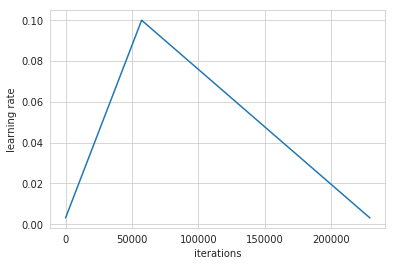

In [33]:
learner.sched.plot_lr()

In [34]:
# Save model
learner.save('<whatever_you_prefer>_emb_sz_16_nh_100_nl_3_v1')

#### Second training (drops multiplier of 0.75)

In [35]:
# Load saved model
learner = get_learner(0.75)
learner.load('<whatever_you_prefer>_emb_sz_16_nh_100_nl_3_v1')

In [36]:
%%time
# (1) 1024, (2) 4096
lrs=1e-1
wds=1e-6
learner.fit(lrs=lrs, n_cycle=1, cycle_len=4096, wds=wds, use_clr=(32,4))
#learner.fit(lrs=lrs, n_cycle=4, cycle_len=1, cycle_mult=2, wds=wds)

epoch      trn_loss   val_loss   accuracy                  
    0      0.196649   0.435116   0.889195  
    1      0.195575   0.429486   0.892339                  
    2      0.19167    0.435409   0.885417                  
    3      0.197578   0.426339   0.892751                  
    4      0.19102    0.424342   0.893536                  
    5      0.186486   0.433482   0.887019                  
    6      0.185126   0.435179   0.885022                  
    7      0.18612    0.430025   0.891142                  
    8      0.182507   0.424881   0.893159                  
    9      0.183529   0.432293   0.893357                  
    10     0.18358    0.426017   0.889186                  
    11     0.183578   0.418948   0.88797                   
    12     0.18359    0.415527   0.893066                  
    13     0.182579   0.418222   0.889694                  
    14     0.183975   0.416242   0.892959                  
    15     0.185298   0.409854   0.897072               

   271     0.241513   0.369288   0.898032                  
   272     0.241469   0.375258   0.899282                  
   273     0.237879   0.375508   0.889341                  
   274     0.236773   0.364602   0.899723                  
   275     0.237856   0.366975   0.904091                  
   276     0.244083   0.370513   0.895935                  
   277     0.241331   0.382045   0.879889                  
   278     0.241465   0.388969   0.890425                  
   279     0.252377   0.37736    0.887541                  
   280     0.250878   0.373054   0.884046                  
   281     0.246774   0.397815   0.878772                  
   282     0.243197   0.37103    0.890723                  
   283     0.240966   0.381015   0.892795                  
   284     0.239582   0.357314   0.90024                   
   285     0.24069    0.369958   0.899329                  
   286     0.243227   0.36587    0.897144                  
   287     0.241192   0.382173   0.88898

   543     0.285955   0.360488   0.901714                  
   544     0.284154   0.360464   0.896064                  
   545     0.28266    0.371717   0.886937                  
   546     0.281822   0.353724   0.900038                  
   547     0.27948    0.354461   0.900293                  
   548     0.282377   0.363987   0.899306                  
   549     0.287935   0.369866   0.896752                  
   550     0.292306   0.371497   0.893427                  
   551     0.291615   0.36946    0.897924                  
   552     0.288134   0.373012   0.901552                  
   553     0.288851   0.371197   0.901503                  
   554     0.291606   0.361118   0.896298                  
   555     0.294788   0.367257   0.899257                  
   556     0.295858   0.388264   0.898292                  
   557     0.299423   0.356144   0.898897                  
   558     0.305071   0.355735   0.900123                  
   559     0.302086   0.363084   0.89858

   815     0.338846   0.41124    0.894223                  
   816     0.336849   0.39998    0.892843                  
   817     0.335717   0.409961   0.891763                  
   818     0.329589   0.404608   0.891734                 
   819     0.329575   0.418146   0.890522                  
   820     0.329957   0.382987   0.888699                 
   821     0.326849   0.376568   0.893814                  
   822     0.326586   0.382947   0.891797                  
   823     0.324431   0.385082   0.894481                  
   824     0.328089   0.388082   0.892303                  
   825     0.328865   0.368948   0.894075                  
   826     0.329902   0.376069   0.895999                  
   827     0.330405   0.367379   0.89403                  
   828     0.330129   0.368876   0.894064                 
   829     0.346061   0.393004   0.891149                  
   830     0.343734   0.379804   0.888129                  
   831     0.350573   0.382937   0.892248   

   1087    0.399686   0.389229   0.88935                  
   1088    0.405479   0.391574   0.890427                  
   1089    0.414968   0.394237   0.886426                  
   1090    0.418995   0.394023   0.889924                  
   1091    0.555      0.672586   0.870665                  
   1092    0.709508   0.750962   0.867851                  
   1093    0.880913   0.768098   0.833193                  
   1094    1.077994   0.851414   0.851659                 
   1095    1.176004   0.671931   0.84451                  
   1096    1.296102   1.946538   0.806373                 
   1097    1.274742   0.616535   0.857945                 
   1098    1.181722   0.522333   0.869318                 
   1099    1.07247    0.492195   0.873234                 
   1100    0.968373   0.494587   0.867851                  
   1101    0.965312   0.494681   0.865841                  
   1102    0.883151   0.484815   0.865377                  
   1103    0.817576   0.448578   0.875501      

   1359    0.41884    0.37409    0.893329                  
   1360    0.407576   0.380066   0.889132                  
   1361    0.40015    0.385613   0.891126                  
   1362    0.390861   0.382962   0.886344                  
   1363    0.41047    0.376465   0.88754                   
   1364    0.431227   0.393263   0.892448                  
   1365    0.43225    0.377914   0.885517                  
   1366    0.430471   0.39268    0.888408                  
   1367    0.438869   0.383512   0.891101                  
   1368    0.422041   0.381701   0.890222                  
   1369    0.410175   0.390332   0.889797                  
   1370    0.40098    0.388009   0.88733                   
   1371    0.403581   0.399161   0.885381                  
   1372    0.459064   0.38331    0.887128                  
   1373    0.444517   0.378712   0.887917                  
   1374    0.461216   0.38353    0.889675                  
   1375    0.444254   0.380158   0.88709

   1631    0.374993   0.396427   0.888452                  
   1632    0.377007   0.394713   0.885874                  
   1633    0.379931   0.396036   0.89072                  
   1634    0.375514   0.387654   0.890521                  
   1635    0.371045   0.387612   0.888958                  
   1636    0.391494   0.389022   0.890527                  
   1637    0.392514   0.388185   0.885312                  
   1638    0.461727   0.378863   0.888306                  
   1639    0.436355   0.380805   0.888528                  
   1640    0.420559   0.390278   0.884168                  
   1641    0.417402   0.373215   0.892167                  
   1642    0.403107   0.376698   0.890525                  
   1643    0.392317   0.387998   0.883929                  
   1644    0.383184   0.392585   0.885125                  
   1645    0.382411   0.385318   0.886492                  
   1646    0.381276   0.393275   0.885453                  
   1647    0.37474    0.384764   0.886472

   1903    0.368031   0.367622   0.89105                   
   1904    0.367975   0.369099   0.892157                  
   1905    0.357925   0.364344   0.890625                  
   1906    0.36478    0.371476   0.88944                   
   1907    0.395861   0.386722   0.892565                  
   1908    0.383771   0.37295    0.889775                  
   1909    0.376733   0.370023   0.887352                  
   1910    0.398226   0.367944   0.889583                  
   1911    0.381411   0.369283   0.887019                  
   1912    0.40085    0.369091   0.891504                  
   1913    0.385326   0.365174   0.891246                  
   1914    0.37056    0.361684   0.891039                  
   1915    0.358565   0.365415   0.890833                  
   1916    0.350708   0.361499   0.893408                  
   1917    0.404643   0.3754     0.889557                  
   1918    0.386783   0.36507    0.892591                  
   1919    0.382507   0.362047   0.88916

   2175    0.326313   0.366347   0.887898                  
   2176    0.322878   0.371985   0.889331                  
   2177    0.320414   0.365018   0.887812                 
   2178    0.320271   0.365834   0.88754                   
   2179    0.323414   0.365536   0.885717                  
   2180    0.321282   0.359135   0.886796                  
   2181    0.322882   0.361892   0.890937                  
   2182    0.329061   0.363709   0.887117                  
   2183    0.333066   0.381495   0.890828                  
   2184    0.334962   0.363808   0.892528                  
   2185    0.340294   0.361121   0.889331                 
   2186    0.346541   0.367598   0.88693                   
   2187    0.414582   0.363213   0.890317                  
   2188    0.394422   0.378404   0.894798                  
   2189    0.39726    0.373471   0.893958                  
   2190    0.383991   0.370309   0.885452                  
   2191    0.369136   0.366646   0.886924 

   2447    0.323644   0.372813   0.890219                  
   2448    0.326304   0.363641   0.89172                   
   2449    0.334764   0.367393   0.890819                  
   2450    0.329319   0.363969   0.892929                  
   2451    0.325683   0.375723   0.890844                  
   2452    0.324376   0.364067   0.889729                  
   2453    0.320891   0.369285   0.891693                  
   2454    0.31735    0.371571   0.888722                  
   2455    0.350358   0.369107   0.891416                  
   2456    0.343157   0.368347   0.888438                  
   2457    0.335242   0.374697   0.889808                  
   2458    0.32779    0.369016   0.889819                  
   2459    0.328964   0.365611   0.892241                  
   2460    0.323973   0.364473   0.890418                  
   2461    0.323163   0.365809   0.890522                  
   2462    0.321131   0.377991   0.887823                  
   2463    0.316012   0.363112   0.89031

   2719    0.324893   0.368576   0.887563                  
   2720    0.324228   0.377808   0.893958                  
   2721    0.318287   0.367779   0.892773                  
   2722    0.313675   0.368794   0.892187                  
   2723    0.343677   0.37995    0.888393                  
   2724    0.341246   0.368288   0.889297                  
   2725    0.331421   0.359284   0.892488                  
   2726    0.324771   0.361475   0.893129                  
   2727    0.324291   0.363687   0.891883                  
   2728    0.316334   0.363453   0.891215                  
   2729    0.309408   0.365916   0.894208                  
   2730    0.304418   0.359879   0.894792                  
   2731    0.301829   0.361369   0.890625                  
   2732    0.302315   0.366046   0.89                      
   2733    0.316924   0.375302   0.884687                  
   2734    0.31231    0.365921   0.891211                  
   2735    0.310603   0.362774   0.89296

   2991    0.285064   0.364371   0.890086                  
   2992    0.282865   0.369907   0.893438                  
   2993    0.285405   0.355926   0.891843                  
   2994    0.284359   0.35819    0.893044                  
   2995    0.282027   0.367112   0.889186                  
   2996    0.288886   0.36655    0.886919                  
   2997    0.285524   0.371619   0.890519                  
   2998    0.28499    0.364565   0.891146                  
   2999    0.283777   0.366062   0.892702                  
   3000    0.286953   0.367155   0.893014                  
   3001    0.291273   0.367329   0.884896                  
   3002    0.290201   0.378016   0.885204                 
   3003    0.287709   0.37487    0.889509                  
   3004    0.284677   0.375426   0.890728                  
   3005    0.28545    0.363859   0.891757                  
   3006    0.290798   0.36362    0.888072                  
   3007    0.29368    0.35967    0.891997

   3263    0.268179   0.35915    0.893475                  
   3264    0.268527   0.366883   0.890101                  
   3265    0.270115   0.368361   0.886082                 
   3266    0.269298   0.359246   0.892045                  
   3267    0.270619   0.366627   0.894764                  
   3268    0.273779   0.364859   0.893437                  
   3269    0.287156   0.364436   0.88961                   
   3270    0.28623    0.356477   0.893044                  
   3271    0.288528   0.368948   0.891042                  
   3272    0.284861   0.357501   0.891326                  
   3273    0.280195   0.360657   0.892887                 
   3274    0.280472   0.374546   0.885842                  
   3275    0.281758   0.372092   0.891646                  
   3276    0.280763   0.370534   0.890726                  
   3277    0.276784   0.364424   0.891748                  
   3278    0.273232   0.361836   0.892914                  
   3279    0.271101   0.366299   0.891892 

   3535    0.257975   0.377765   0.893329                  
   3536    0.257468   0.391345   0.888704                  
   3537    0.257208   0.382932   0.892123                  
   3538    0.25682    0.383161   0.893626                  
   3539    0.263337   0.377637   0.895333                  
   3540    0.261057   0.370746   0.891944                  
   3541    0.258225   0.374576   0.893945                  
   3542    0.257169   0.3698     0.893862                  
   3543    0.264419   0.378969   0.892932                  
   3544    0.262149   0.376804   0.894965                  
   3545    0.261466   0.373708   0.89363                   
   3546    0.263528   0.376276   0.892147                  
   3547    0.263271   0.376975   0.891569                  
   3548    0.263923   0.37977    0.891354                  
   3549    0.260327   0.37644    0.892565                 
   3550    0.259607   0.375164   0.891812                  
   3551    0.259392   0.369123   0.891129

   3807    0.236315   0.391702   0.890625                  
   3808    0.237771   0.389959   0.890946                  
   3809    0.236907   0.383368   0.894163                  
   3810    0.235602   0.383636   0.893833                  
   3811    0.242339   0.382187   0.891521                  
   3812    0.242987   0.382269   0.891883                  
   3813    0.242705   0.387285   0.892188                  
   3814    0.239892   0.386012   0.890831                 
   3815    0.237292   0.382895   0.892565                  
   3816    0.236267   0.384894   0.893812                  
   3817    0.236443   0.388511   0.890415                  
   3818    0.236124   0.385041   0.892248                  
   3819    0.234174   0.385978   0.891859                  
   3820    0.235429   0.386182   0.892064                  
   3821    0.236862   0.37834    0.892801                  
   3822    0.237464   0.380982   0.892926                  
   3823    0.237574   0.387524   0.893792

   4079    0.223227   0.384852   0.894906                  
   4080    0.224349   0.383112   0.894583                  
   4081    0.221878   0.383775   0.895488                  
   4082    0.219195   0.38566    0.892408                  
   4083    0.221209   0.379146   0.89651                   
   4084    0.218949   0.380592   0.896213                  
   4085    0.217616   0.384221   0.895629                  
   4086    0.216026   0.379773   0.89597                   
   4087    0.215956   0.386584   0.894805                  
   4088    0.218841   0.38162    0.89538                   
   4089    0.218249   0.38295    0.894052                  
   4090    0.21505    0.38435    0.895178                  
   4091    0.216198   0.383616   0.894295                  
   4092    0.216136   0.382654   0.893382                  
   4093    0.21406    0.383691   0.893466                  
   4094    0.215739   0.382307   0.894326                  
   4095    0.215942   0.380956   0.89505

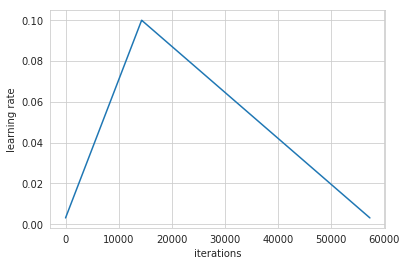

In [37]:
# Plot lr on training
learner.sched.plot_lr()

In [38]:
# Save model
learner.save('<whatever_you_prefer>_emb_sz_16_nh_100_nl_3_v2')

#### Third training (drops multiplier of 0.95)

In [84]:
# Load saved model
learner = get_learner(0.95)
learner.load('<whatever_you_prefer>_emb_sz_16_nh_100_nl_3_v2')

In [39]:
%%time
# (1) 1024, (2) 2048, (3) 2048
lrs=1e-1
wds=1e-6
learner.fit(lrs=lrs, n_cycle=1, cycle_len=2048, wds=wds, use_clr=(32,4))
#learner.fit(lrs=lrs, n_cycle=4, cycle_len=1, cycle_mult=2, wds=wds)

epoch      trn_loss   val_loss   accuracy                  
    0      0.221818   0.387925   0.892948  
    1      0.221983   0.38264    0.895333                  
    2      0.220374   0.389093   0.89668                   
    3      0.215691   0.378125   0.898532                  
    4      0.214163   0.383616   0.896627                  
    5      0.213241   0.384606   0.895232                  
    6      0.212271   0.389227   0.895244                  
    7      0.21295    0.382667   0.896242                  
    8      0.21311    0.386212   0.895474                  
    9      0.212324   0.390073   0.896484                  
    10     0.212479   0.387314   0.894983                  
    11     0.217887   0.378064   0.896104                  
    12     0.216539   0.382331   0.892398                  
    13     0.220371   0.389238   0.892275                  
    14     0.218923   0.389074   0.893103                  
    15     0.221225   0.392911   0.894181               

   271     0.29981    0.370277   0.894932                  
   272     0.295873   0.379649   0.893729                  
   273     0.291645   0.377617   0.894583                  
   274     0.288299   0.375932   0.89825                   
   275     0.300559   0.367782   0.892118                  
   276     0.299018   0.356223   0.8958                    
   277     0.296271   0.377797   0.899595                  
   278     0.291444   0.354525   0.897727                  
   279     0.289971   0.35956    0.894375                 
   280     0.287114   0.38079    0.888452                  
   281     0.284282   0.372792   0.896397                  
   282     0.283178   0.362252   0.893876                  
   283     0.280444   0.360635   0.900085                 
   284     0.283413   0.362867   0.898951                  
   285     0.28402    0.354991   0.899353                  
   286     0.285385   0.359614   0.898489                  
   287     0.288506   0.354054   0.895799 

   545     2.743807   2.073176   0.699371                 
   546     2.743665   2.103493   0.670283                 
   547     2.64819    1.956924   0.530459                 
   548     2.599114   1.926389   0.511642                
   549     2.647942   2.958485   0.672782                 
   550     2.816071   2.35816    0.584577                 
   551     2.900752   2.772692   0.38587                  
   552     2.899774   2.553904   0.750103                 
   553     3.153227   2.237771   0.695163                 
   554     5.06702    5.743676   0.607525                 
   555     5.628141   4.214903   0.590927                 
   556     6.229111   3.507447   0.519254                 
   557     7.096886   6.159198   0.048295                 
   558     7.266102   3.113296   0.765723                 
   559     7.419928   3.80886    0.619924                 
   560     7.242049   3.633945   0.638158                 
   561     7.417049   5.024909   0.617728                

   821     0.934073   0.718279   0.841563                  
   822     0.941547   0.720476   0.842014                  
   823     0.945094   0.717936   0.841931                  
   824     0.940463   0.75448    0.845104                  
   825     0.93827    0.749054   0.839094                  
   826     0.944211   0.737421   0.842272                  
   827     0.940603   0.728062   0.840872                  
   828     0.944517   0.752674   0.841979                  
   829     0.95172    0.728821   0.840625                  
   830     0.969497   0.737987   0.842025                  
   831     0.952592   0.75894    0.840055                  
   832     0.961636   0.71934    0.842002                  
   833     0.943491   0.796488   0.841991                  
   834     0.939659   0.743189   0.842072                  
   835     0.949838   0.742267   0.842414                 
   836     0.965921   0.763299   0.84232                   
   837     0.952472   0.724083   0.841443

   1093    0.73793    0.590159   0.850954                  
   1094    0.728199   0.613891   0.850132                  
   1095    0.725258   0.581396   0.850446                  
   1096    0.715425   0.566065   0.849093                  
   1097    0.717866   0.592067   0.846955                  
   1098    0.73156    0.548936   0.851811                  
   1099    0.720125   0.56654    0.850907                  
   1100    0.724518   0.653046   0.848599                  
   1101    0.725468   0.563375   0.85114                   
   1102    0.714732   0.583156   0.848923                  
   1103    0.706001   0.56986    0.848784                  
   1104    0.695258   0.544737   0.850803                  
   1105    0.684969   0.562486   0.850946                  
   1106    0.690914   0.588381   0.851136                  
   1107    0.688543   0.561565   0.849768                  
   1108    0.682733   0.563829   0.853041                  
   1109    0.678653   0.539608   0.85274

   1365    0.391245   0.387317   0.886042                  
   1366    0.410319   0.378424   0.884457                  
   1367    0.42763    0.385723   0.884962                  
   1368    0.414932   0.383789   0.885135                  
   1369    0.409136   0.383072   0.884256                  
   1370    0.449002   0.387261   0.886161                  
   1371    0.431284   0.37873    0.885817                  
   1372    0.422153   0.382146   0.885348                  
   1373    0.445136   0.374454   0.885177                  
   1374    0.432174   0.377122   0.882557                  
   1375    0.433937   0.377967   0.889083                  
   1376    0.420382   0.385195   0.883485                 
   1377    0.411267   0.387414   0.882763                  
   1378    0.402278   0.378723   0.886311                  
   1379    0.427519   0.385302   0.883284                  
   1380    0.419496   0.389517   0.885204                  
   1381    0.406115   0.394097   0.88332 

   1637    0.354608   0.366679   0.893326                  
   1638    0.35721    0.367878   0.890082                  
   1639    0.34633    0.365355   0.890625                  
   1640    0.376521   0.371071   0.89125                   
   1641    0.361896   0.364228   0.89134                   
   1642    0.350707   0.365231   0.894912                  
   1643    0.375276   0.366291   0.892118                  
   1644    0.360307   0.363955   0.890522                  
   1645    0.362932   0.363924   0.893909                  
   1646    0.354998   0.363363   0.889597                  
   1647    0.34575    0.369555   0.893872                  
   1648    0.356223   0.367326   0.891385                  
   1649    0.34983    0.369562   0.889724                  
   1650    0.364143   0.370703   0.891521                  
   1651    0.37514    0.369067   0.890929                  
   1652    0.361186   0.36727    0.89244                   
   1653    0.348123   0.364286   0.89235

   1909    0.314288   0.359537   0.895221                  
   1910    0.305062   0.363489   0.896046                  
   1911    0.305806   0.364095   0.896382                  
   1912    0.300462   0.367137   0.89527                   
   1913    0.297209   0.362038   0.896213                  
   1914    0.293419   0.365929   0.895394                  
   1915    0.296293   0.365358   0.894199                  
   1916    0.294885   0.36903    0.895871                  
   1917    0.300563   0.363968   0.895935                  
   1918    0.307555   0.366567   0.89605                   
   1919    0.306808   0.366341   0.895797                  
   1920    0.31088    0.367302   0.897204                  
   1921    0.304155   0.363539   0.89808                   
   1922    0.301323   0.364212   0.896582                  
   1923    0.303707   0.374272   0.896284                  
   1924    0.299691   0.367852   0.89622                  
   1925    0.299502   0.367305   0.896854

In [40]:
%%time
# (1) 1024
lrs=1e-2
wds=1e-6
learner.fit(lrs=lrs, n_cycle=1, cycle_len=1024, wds=wds, use_clr=(32,4))
#learner.fit(lrs=lrs, n_cycle=4, cycle_len=1, cycle_mult=2, wds=wds)

epoch      trn_loss   val_loss   accuracy                  
    0      0.283719   0.362516   0.896855  
    1      0.272929   0.362424   0.896446                  
    2      0.273043   0.361531   0.896895                  
    3      0.270576   0.36178    0.896344                  
    4      0.272763   0.3637     0.89668                   
    5      0.270244   0.362194   0.896242                 
    6      0.267684   0.363671   0.895798                  
    7      0.277033   0.361425   0.895799                  
    8      0.274231   0.361119   0.896176                  
    9      0.271015   0.361622   0.896834                  
    10     0.269118   0.373847   0.895532                  
    11     0.279918   0.371918   0.89526                   
    12     0.274892   0.360402   0.89642                   
    13     0.270868   0.361187   0.896042                  
    14     0.27106    0.362862   0.895408                  
    15     0.267112   0.363428   0.895587                

   271     0.26926    0.365277   0.896213                  
   272     0.265794   0.371394   0.895527                  
   273     0.27239    0.370374   0.896525                  
   274     0.266312   0.372928   0.895727                  
   275     0.267517   0.371523   0.89665                   
   276     0.265608   0.378141   0.89646                   
   277     0.265766   0.366407   0.897661                  
   278     0.264121   0.372689   0.896289                  
   279     0.261646   0.366346   0.898292                  
   280     0.258694   0.369679   0.896213                  
   281     0.260745   0.377958   0.896793                  
   282     0.25889    0.374259   0.898655                  
   283     0.261516   0.37124    0.89496                   
   284     0.261141   0.37249    0.899209                  
   285     0.259396   0.366198   0.899119                  
   286     0.256782   0.365581   0.900232                  
   287     0.256046   0.364006   0.89854

   543     0.242625   0.36       0.899282                  
   544     0.252154   0.353275   0.900378                  
   545     0.246526   0.354931   0.899918                  
   546     0.244308   0.360111   0.89895                   
   547     0.240851   0.351414   0.901242                  
   548     0.237309   0.357556   0.897266                  
   549     0.234728   0.358409   0.897853                  
   550     0.232293   0.358825   0.900488                  
   551     0.232011   0.356363   0.900341                  
   552     0.236366   0.36082    0.896748                  
   553     0.233649   0.354156   0.901042                  
   554     0.233257   0.354044   0.899329                  
   555     0.234273   0.354332   0.89994                   
   556     0.236215   0.35431    0.899339                  
   557     0.235778   0.351906   0.899482                  
   558     0.234366   0.353436   0.899694                  
   559     0.23325    0.35209    0.90082

   815     0.214826   0.368964   0.901701                  
   816     0.215303   0.373226   0.900641                  
   817     0.213288   0.373747   0.900974                  
   818     0.213444   0.376571   0.900973                  
   819     0.212084   0.369943   0.901213                  
   820     0.217913   0.368271   0.901989                  
   821     0.216971   0.370429   0.902344                  
   822     0.215817   0.375646   0.89913                   
   823     0.215377   0.373691   0.902644                  
   824     0.215071   0.374307   0.899329                  
   825     0.212147   0.372251   0.901394                  
   826     0.210907   0.376614   0.899341                  
   827     0.213737   0.371116   0.899465                  
   828     0.21577    0.371317   0.899609                  
   829     0.21586    0.37307    0.899766                  
   830     0.221228   0.373223   0.899508                  
   831     0.217324   0.372772   0.89890

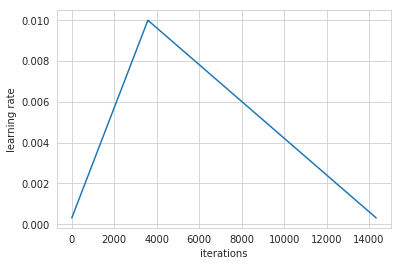

In [41]:
# Plot lr on training
learner.sched.plot_lr()

In [42]:
# Save model
learner.save('<whatever_you_prefer>_emb_sz_16_nh_100_nl_3_v3')

#### Forth training (drops multiplier of 0.98)

In [43]:
# Load saved model
learner = get_learner(0.98)
learner.load('<whatever_you_prefer>_emb_sz_16_nh_100_nl_3_v3')

In [44]:
%%time
# (1) 75
lrs=1e-2
wds=1e-6
learner.fit(lrs=lrs, n_cycle=1, cycle_len=75, wds=wds, use_clr=(32,4))
#learner.fit(lrs=lrs, n_cycle=4, cycle_len=1, cycle_mult=2, wds=wds)

epoch      trn_loss   val_loss   accuracy                  
    0      0.228307   0.369952   0.901904  
    1      0.233312   0.371805   0.901998                  
    2      0.231393   0.36645    0.901672                  
    3      0.232049   0.365007   0.901714                  
    4      0.234648   0.365255   0.901573                  
    5      0.234593   0.369426   0.900662                  
    6      0.235778   0.362113   0.901278                  
    7      0.233587   0.360097   0.901689                  
    8      0.241483   0.355221   0.904459                  
    9      0.237838   0.364521   0.899624                  
    10     0.234602   0.359449   0.902449                  
    11     0.23663    0.360072   0.901563                  
    12     0.235314   0.365555   0.901458                  
    13     0.238883   0.356604   0.901531                  
    14     0.239831   0.359221   0.902544                  
    15     0.245706   0.354349   0.90183                

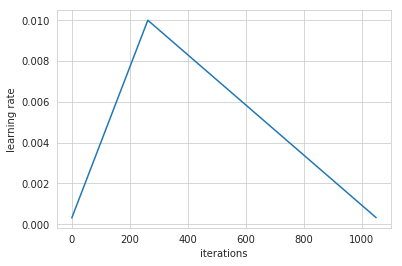

In [45]:
# Plot lr on training
learner.sched.plot_lr()

In [46]:
# Save model
learner.save('<whatever_you_prefer>_emb_sz_16_nh_100_nl_3_v4')

#### Fifth training (drops multiplier of 2.0)

In [47]:
# Load saved model
learner = get_learner(2.0)
learner.load('<whatever_you_prefer>_emb_sz_16_nh_100_nl_3_v4')

In [48]:
%%time
# (1) 512, (2) 16384
lrs=1e-3
wds=1e-6
learner.fit(lrs=lrs, n_cycle=1, cycle_len=16384, wds=wds, use_clr=(32,4))
#learner.fit(lrs=lrs, n_cycle=4, cycle_len=1, cycle_mult=2, wds=wds)

epoch      trn_loss   val_loss   accuracy                  
    0      0.639333   0.355337   0.901971  
    1      0.676367   0.357861   0.900902                  
    2      0.665613   0.355137   0.901672                  
    3      0.658013   0.355921   0.901076                  
    4      0.657869   0.356328   0.901144                  
    5      0.645965   0.355782   0.90166                   
    6      0.645032   0.357567   0.900829                  
    7      0.638278   0.364085   0.8991                    
    8      0.645865   0.355479   0.90166                   
    9      0.648989   0.354641   0.901542                  
    10     0.647514   0.354429   0.901672                  
    11     0.657698   0.355242   0.901521                  
    12     0.642604   0.355685   0.90145                   
    13     0.641804   0.355122   0.901594                  
    14     0.636124   0.361354   0.89987                   
    15     0.640283   0.363076   0.899889               

   271     0.541371   0.344984   0.903269                  
   272     0.530556   0.355317   0.900159                  
   273     0.534074   0.344661   0.903206                  
   274     0.534771   0.355369   0.900291                  
   275     0.544638   0.344937   0.903679                  
   276     0.53185    0.344767   0.903475                  
   277     0.538474   0.345274   0.903921                  
   278     0.524278   0.347292   0.903017                  
   279     0.52966    0.344611   0.903783                  
   280     0.54141    0.346684   0.903188                  
   281     0.533619   0.344635   0.903886                  
   282     0.539661   0.346181   0.903389                  
   283     0.543843   0.344829   0.904199                  
   284     0.548868   0.345423   0.903542                  
   285     0.543724   0.346529   0.903209                  
   286     0.544665   0.34518    0.903629                  
   287     0.544491   0.345787   0.90340

   543     0.496677   0.343306   0.904502                  
   544     0.485521   0.352225   0.902931                  
   545     0.483664   0.343137   0.904605                  
   546     0.48663    0.343053   0.904387                  
   547     0.488617   0.343105   0.904387                  
   548     0.490851   0.343489   0.904678                  
   549     0.480809   0.345373   0.904095                  
   550     0.486357   0.342736   0.904707                  
   551     0.490348   0.343298   0.904481                  
   552     0.496535   0.343539   0.904234                  
   553     0.494794   0.342907   0.904569                  
   554     0.494802   0.343515   0.904234                  
   555     0.488123   0.342844   0.9044                    
   556     0.480422   0.342147   0.904748                 
   557     0.483994   0.343402   0.904481                  
   558     0.483292   0.344873   0.904033                  
   559     0.475181   0.345438   0.904003

   815     0.460354   0.344013   0.905048                  
   816     0.45739    0.35191    0.903522                  
   817     0.458177   0.343256   0.905208                  
   818     0.452874   0.352606   0.902807                  
   819     0.438911   0.343175   0.905229                  
   820     0.439318   0.351688   0.90396                   
   821     0.446081   0.343563   0.90482                   
   822     0.448966   0.343954   0.904939                  
   823     0.460425   0.342626   0.905549                  
   824     0.455395   0.343515   0.904905                  
   825     0.45302    0.343885   0.90482                   
   826     0.458361   0.343208   0.904914                  
   827     0.452186   0.343302   0.904801                  
   828     0.462997   0.343971   0.905                     
   829     0.462702   0.345273   0.904772                  
   830     0.452207   0.344342   0.90504                   
   831     0.460171   0.345296   0.90435

   1087    0.433135   0.345536   0.903314                  
   1088    0.432394   0.341264   0.905215                  
   1089    0.435058   0.343125   0.904429                  
   1090    0.426252   0.344046   0.904371                  
   1091    0.424057   0.343936   0.90356                   
   1092    0.423185   0.345121   0.903505                  
   1093    0.4342     0.342613   0.903886                  
   1094    0.428801   0.342585   0.90387                   
   1095    0.429702   0.343182   0.904272                 
   1096    0.446633   0.344955   0.903399                  
   1097    0.450858   0.343443   0.903511                  
   1098    0.454521   0.344275   0.903542                  
   1099    0.445821   0.343768   0.903456                  
   1100    0.45344    0.34414    0.904074                  
   1101    0.451447   0.343496   0.903886                  
   1102    0.454114   0.34321    0.903783                  
   1103    0.451489   0.343348   0.903767

   1359    0.413253   0.342609   0.903105                  
   1360    0.420423   0.343731   0.903007                  
   1361    0.421623   0.342911   0.902835                  
   1362    0.424582   0.342374   0.902939                  
   1363    0.424478   0.351197   0.900743                  
   1364    0.424089   0.344283   0.902802                  
   1365    0.42784    0.344168   0.902894                  
   1366    0.427141   0.342947   0.903021                  
   1367    0.426399   0.342569   0.902939                  
   1368    0.431308   0.343808   0.903695                  
   1369    0.425534   0.3449     0.902679                  
   1370    0.432668   0.342493   0.903308                  
   1371    0.422004   0.342284   0.903145                  
   1372    0.424575   0.344692   0.90266                   
   1373    0.42595    0.343863   0.903024                  
   1374    0.423463   0.343151   0.903356                  
   1375    0.428805   0.341653   0.90407

   1631    0.39716    0.344747   0.903146                  
   1632    0.402352   0.344458   0.903269                  
   1633    0.398872   0.344383   0.902471                  
   1634    0.403386   0.345254   0.902238                  
   1635    0.403188   0.344744   0.90252                   
   1636    0.400169   0.345385   0.902121                  
   1637    0.397863   0.345622   0.902423                  
   1638    0.401794   0.34434    0.903245                  
   1639    0.403218   0.343597   0.903662                  
   1640    0.400158   0.344934   0.903024                  
   1641    0.401789   0.344689   0.902982                  
   1642    0.403677   0.34564    0.902894                  
   1643    0.397503   0.343447   0.903446                  
   1644    0.403732   0.343116   0.903854                  
   1645    0.407319   0.34509    0.902894                  
   1646    0.409141   0.343782   0.903713                  
   1647    0.401661   0.345455   0.90308

   1903    0.400265   0.346156   0.902449                  
   1904    0.404198   0.345884   0.902999                  
   1905    0.400501   0.344166   0.903475                  
   1906    0.397995   0.343946   0.903269                  
   1907    0.393292   0.345362   0.902849                  
   1908    0.393143   0.345714   0.902923                  
   1909    0.393364   0.345584   0.903382                  
   1910    0.391688   0.343041   0.902835                  
   1911    0.388923   0.344464   0.902823                  
   1912    0.384456   0.344421   0.902923                  
   1913    0.384412   0.343845   0.903549                  
   1914    0.388933   0.343437   0.903166                  
   1915    0.389762   0.344851   0.90295                   
   1916    0.388718   0.343887   0.903024                  
   1917    0.400043   0.343988   0.902982                  
   1918    0.413534   0.343833   0.902863                  
   1919    0.404313   0.34466    0.90281

   2175    0.38983    0.344246   0.902344                  
   2176    0.390917   0.346231   0.902419                  
   2177    0.386898   0.347396   0.902265                  
   2178    0.398409   0.347982   0.90229                   
   2179    0.392954   0.346473   0.902754                  
   2180    0.394264   0.346391   0.902708                  
   2181    0.393849   0.346126   0.902987                  
   2182    0.390369   0.346839   0.902778                  
   2183    0.391551   0.355744   0.900359                  
   2184    0.387413   0.345454   0.902549                  
   2185    0.386537   0.346163   0.90269                   
   2186    0.382527   0.346267   0.902039                  
   2187    0.378276   0.347921   0.902712                  
   2188    0.38339    0.354301   0.900534                  
   2189    0.380683   0.34495    0.902991                  
   2190    0.385266   0.346093   0.902525                  
   2191    0.38237    0.346241   0.9025 

   2447    0.372511   0.347813   0.90191                   
   2448    0.375428   0.346582   0.90145                   
   2449    0.373019   0.347522   0.901288                  
   2450    0.376974   0.348682   0.902789                  
   2451    0.377752   0.348613   0.902027                  
   2452    0.37708    0.344839   0.902138                  
   2453    0.382009   0.345629   0.902083                  
   2454    0.379966   0.345614   0.902866                  
   2455    0.376331   0.345969   0.902187                  
   2456    0.371358   0.345483   0.902069                  
   2457    0.374583   0.344532   0.902244                  
   2458    0.367551   0.346874   0.902637                  
   2459    0.373859   0.344769   0.902444                  
   2460    0.371467   0.346106   0.902244                  
   2461    0.370136   0.347049   0.902832                  
   2462    0.366384   0.346841   0.902369                  
   2463    0.376329   0.346582   0.90254

   2719    0.37171    0.347977   0.899938                  
   2720    0.367543   0.348725   0.900578                  
   2721    0.367511   0.348117   0.900833                  
   2722    0.363816   0.348656   0.901503                  
   2723    0.366099   0.348207   0.900766                  
   2724    0.368184   0.348769   0.90067                   
   2725    0.371821   0.347625   0.900699                  
   2726    0.373563   0.348257   0.900638                  
   2727    0.374161   0.348454   0.900625                  
   2728    0.378952   0.34882    0.900729                  
   2729    0.373725   0.356349   0.89906                   
   2730    0.378811   0.348      0.900766                  
   2731    0.381637   0.348388   0.900766                  
   2732    0.378208   0.350268   0.900404                  
   2733    0.380395   0.358679   0.898986                  
   2734    0.374357   0.350265   0.900873                  
   2735    0.376609   0.348781   0.90208

   2991    0.355447   0.350789   0.900063                  
   2992    0.360322   0.357275   0.898185                  
   2993    0.369066   0.348991   0.899916                  
   2994    0.366629   0.348346   0.899694                  
   2995    0.360839   0.349792   0.900273                  
   2996    0.362697   0.350562   0.900127                  
   2997    0.358576   0.348251   0.901213                  
   2998    0.357514   0.347609   0.900288                  
   2999    0.360078   0.349269   0.900302                  
   3000    0.362118   0.347743   0.900352                  
   3001    0.362322   0.348331   0.900022                  
   3002    0.369408   0.348152   0.900208                  
   3003    0.369715   0.347757   0.899731                  
   3004    0.362904   0.348405   0.899756                  
   3005    0.361737   0.348529   0.900082                  
   3006    0.368096   0.350974   0.900649                  
   3007    0.364336   0.350197   0.90030

   3263    0.363411   0.351264   0.901042                  
   3264    0.364884   0.350732   0.901411                  
   3265    0.363574   0.349059   0.901594                  
   3266    0.360936   0.350776   0.901786                  
   3267    0.360034   0.351906   0.901394                 
   3268    0.355964   0.351138   0.901216                  
   3269    0.363773   0.35011    0.90094                   
   3270    0.356003   0.34918    0.901843                  
   3271    0.355038   0.352306   0.901152                  
   3272    0.353993   0.351045   0.900866                  
   3273    0.348924   0.351329   0.900797                  
   3274    0.354506   0.350088   0.901465                  
   3275    0.354866   0.349933   0.900907                  
   3276    0.351824   0.348104   0.901442                  
   3277    0.356412   0.349621   0.900443                  
   3278    0.355359   0.34823    0.900833                  
   3279    0.354518   0.348056   0.901142

   3535    0.351732   0.350445   0.899938                  
   3536    0.356394   0.350298   0.899792                  
   3537    0.357228   0.35098    0.899631                  
   3538    0.355921   0.35059    0.900208                  
   3539    0.358047   0.352021   0.900482                  
   3540    0.356516   0.353848   0.900747                  
   3541    0.353025   0.35117    0.900771                  
   3542    0.354369   0.352764   0.900108                  
   3543    0.350879   0.350559   0.901108                  
   3544    0.350103   0.352573   0.901008                  
   3545    0.358276   0.352527   0.901305                  
   3546    0.356974   0.352001   0.90024                   
   3547    0.359168   0.35137    0.901743                  
   3548    0.358645   0.352846   0.900429                  
   3549    0.36269    0.351816   0.900365                  
   3550    0.367652   0.352822   0.900225                  
   3551    0.363769   0.35064    0.90077

   4080    0.33548    0.353507   0.901274                  
   4081    0.333246   0.354926   0.900041                  
   4082    0.338632   0.356531   0.899704                  
   4083    0.344533   0.35618    0.9                       
   4084    0.344856   0.354667   0.900312                  
   4085    0.343237   0.355842   0.900586                  
   4086    0.347423   0.356236   0.899612                  
   4087    0.350494   0.357669   0.899731                  
   4088    0.345962   0.35752    0.899792                  
   4089    0.350842   0.355248   0.899479                  
   4090    0.345154   0.354138   0.89951                   
   4091    0.343829   0.35367    0.89951                   
   4092    0.337947   0.354009   0.900514                  
   4093    0.340684   0.354416   0.900225                  
   4094    0.341571   0.355754   0.899958                  
   4095    0.336814   0.355844   0.900162                  
   4096    0.350228   0.358937   0.89968

   4352    0.338303   0.355355   0.900971                  
   4353    0.334952   0.354342   0.901042                  
   4354    0.335193   0.354359   0.901613                  
   4355    0.336132   0.353605   0.901144                  
   4356    0.332635   0.354169   0.901348                  
   4357    0.33692    0.357386   0.900754                  
   4358    0.337703   0.366856   0.899277                  
   4359    0.338391   0.354368   0.901112                  
   4360    0.340287   0.356199   0.9                       
   4361    0.340062   0.352985   0.900455                  
   4362    0.336018   0.353853   0.90111                   
   4363    0.33412    0.35578    0.900429                  
   4364    0.336303   0.351248   0.901486                  
   4365    0.333779   0.352048   0.901109                  
   4366    0.331726   0.354256   0.900273                  
   4367    0.3286     0.362276   0.899111                  
   4368    0.332851   0.352281   0.90100

   4624    0.338823   0.355709   0.899834                  
   4625    0.338589   0.354355   0.900082                  
   4626    0.333149   0.357767   0.899408                  
   4627    0.333604   0.357524   0.899282                  
   4628    0.332447   0.357154   0.899306                  
   4629    0.338711   0.356296   0.899899                  
   4630    0.344135   0.355322   0.900302                  
   4631    0.340197   0.356722   0.901042                  
   4632    0.332657   0.355536   0.900493                  
   4633    0.331816   0.356332   0.900365                  
   4634    0.328458   0.354628   0.900975                  
   4635    0.327201   0.354427   0.900352                  
   4636    0.329669   0.356209   0.900168                 
   4637    0.327676   0.355692   0.901042                  
   4638    0.325219   0.353218   0.901174                  
   4639    0.332801   0.354228   0.899816                  
   4640    0.33113    0.356005   0.899892

   4896    0.337837   0.358749   0.900605                  
   4897    0.338529   0.357272   0.900531                  
   4898    0.33508    0.357355   0.901442                  
   4899    0.332678   0.361117   0.899631                  
   4900    0.334681   0.357517   0.900123                  
   4901    0.342806   0.35619    0.901009                  
   4902    0.339115   0.35944    0.899269                  
   4903    0.348501   0.358991   0.899128                  
   4904    0.343976   0.356483   0.900352                  
   4905    0.339549   0.358265   0.900123                  
   4906    0.341571   0.358898   0.899899                  
   4907    0.338616   0.357399   0.899363                  
   4908    0.335187   0.357909   0.900021                  
   4909    0.334674   0.358024   0.899615                  
   4910    0.331994   0.356835   0.900806                  
   4911    0.33213    0.356252   0.899306                  
   4912    0.337598   0.355186   0.89991

   5168    0.32334    0.357257   0.899957                  
   5169    0.322118   0.357376   0.9013                    
   5170    0.322733   0.356909   0.901109                  
   5171    0.323194   0.354635   0.901274                  
   5172    0.320449   0.35343    0.900493                  
   5173    0.320842   0.354991   0.900061                  
   5174    0.32864    0.357822   0.899353                  
   5175    0.330827   0.355495   0.9                       
   5176    0.325905   0.353122   0.899524                  
   5177    0.327861   0.356053   0.899353                  
   5178    0.324192   0.353642   0.899597                  
   5179    0.322816   0.353215   0.900082                  
   5180    0.323689   0.355506   0.899899                  
   5181    0.321487   0.354283   0.900365                  
   5182    0.322605   0.354987   0.900127                  
   5183    0.321971   0.355175   0.900443                  
   5184    0.320566   0.364121   0.89737

   5440    0.322405   0.355996   0.900063                  
   5441    0.32065    0.353207   0.900185                  
   5442    0.316144   0.354977   0.899958                  
   5443    0.32003    0.354738   0.899979                 
   5444    0.319539   0.354099   0.900559                 
   5445    0.318172   0.356459   0.899098                  
   5446    0.323522   0.354309   0.899916                  
   5447    0.326135   0.353189   0.9                       
   5448    0.326102   0.353226   0.900061                  
   5449    0.327463   0.353165   0.900404                  
   5450    0.330525   0.355251   0.900162                  
   5451    0.331025   0.352748   0.900586                  
   5452    0.332319   0.352528   0.899688                  
   5453    0.328716   0.356596   0.899508                  
   5454    0.331828   0.352349   0.899979                  
   5455    0.329652   0.353679   0.900312                  
   5456    0.324295   0.354114   0.899899 

   5712    0.323072   0.346561   0.900973                  
   5713    0.323634   0.347149   0.900712                  
   5714    0.320707   0.355678   0.89916                   
   5715    0.320786   0.346863   0.90173                   
   5716    0.319965   0.34795    0.901926                  
   5717    0.322373   0.349348   0.901213                  
   5718    0.322225   0.3511     0.901006                  
   5719    0.328277   0.350272   0.901007                  
   5720    0.330492   0.34882    0.901342                  
   5721    0.328194   0.349581   0.9013                    
   5722    0.32901    0.34724    0.900493                  
   5723    0.326383   0.35728    0.898504                  
   5724    0.332788   0.347923   0.899722                  
   5725    0.327507   0.347846   0.900586                  
   5726    0.332886   0.348488   0.899612                  
   5727    0.333759   0.35       0.900323                  
   5728    0.333643   0.347961   0.90055

   5984    0.331935   0.350329   0.901146                  
   5985    0.329049   0.349168   0.902097                  
   5986    0.328141   0.349697   0.900974                  
   5987    0.328482   0.352029   0.90097                   
   5988    0.327935   0.351004   0.901177                  
   5989    0.322804   0.350235   0.90138                   
   5990    0.322372   0.350027   0.901213                  
   5991    0.323248   0.350132   0.901667                  
   5992    0.325262   0.350937   0.901926                  
   5993    0.323372   0.353919   0.900685                  
   5994    0.321091   0.35199    0.900082                  
   5995    0.324983   0.362163   0.899439                  
   5996    0.320904   0.351899   0.901503                  
   5997    0.320759   0.350819   0.901146                  
   5998    0.323378   0.35253    0.900429                  
   5999    0.329376   0.353312   0.901701                  
   6000    0.333218   0.351813   0.90083

   6256    0.323236   0.354053   0.900404                  
   6257    0.321196   0.353428   0.900692                  
   6258    0.320841   0.353727   0.899282                  
   6259    0.317426   0.350997   0.900699                  
   6260    0.317108   0.354312   0.899569                  
   6261    0.318658   0.351815   0.90024                   
   6262    0.318305   0.35923    0.899479                  
   6263    0.314495   0.349883   0.901419                  
   6264    0.313839   0.360309   0.899824                  
   6265    0.318011   0.351509   0.900616                  
   6266    0.323475   0.351984   0.89974                   
   6267    0.326793   0.35121    0.90166                   
   6268    0.324934   0.352587   0.901288                  
   6269    0.322999   0.35135    0.901875                  
   6270    0.32072    0.351828   0.901246                  
   6271    0.321565   0.351821   0.900273                  
   6272    0.318562   0.362204   0.89940

   6528    0.318263   0.350307   0.899493                  
   6529    0.314183   0.349405   0.899093                  
   6530    0.315837   0.352451   0.89908                   
   6531    0.312081   0.349657   0.89875                   
   6532    0.312313   0.348541   0.898539                  
   6533    0.31928    0.351866   0.89984                   
   6534    0.318597   0.351054   0.89951                   
   6535    0.324429   0.353711   0.89898                   
   6536    0.325922   0.348224   0.90145                   
   6537    0.324176   0.350602   0.900559                  
   6538    0.321085   0.353111   0.900649                  
   6539    0.33267    0.349282   0.900248                  
   6540    0.331585   0.349542   0.900613                  
   6541    0.324857   0.348306   0.899007                  
   6542    0.318385   0.351107   0.899554                  
   6543    0.319423   0.350272   0.900942                  
   6544    0.318421   0.351886   0.89974

   6800    0.322112   0.354023   0.900061                  
   6801    0.316153   0.356782   0.900216                  
   6802    0.319997   0.356029   0.90067                   
   6803    0.322661   0.354316   0.900973                  
   6804    0.320375   0.354898   0.901562                  
   6805    0.318992   0.355222   0.90173                   
   6806    0.32327    0.357679   0.900578                  
   6807    0.320793   0.356339   0.901182                  
   6808    0.318739   0.354596   0.901613                  
   6809    0.318974   0.354891   0.902016                  
   6810    0.316424   0.354567   0.901989                  
   6811    0.314556   0.35633    0.900692                  
   6812    0.312831   0.354071   0.901042                  
   6813    0.316475   0.35689    0.901348                  
   6814    0.314491   0.356422   0.901293                  
   6815    0.314492   0.353939   0.901213                  
   6816    0.312538   0.353869   0.90246

   7072    0.326776   0.350533   0.899978                  
   7073    0.325047   0.351853   0.900902                  
   7074    0.320355   0.350452   0.900766                  
   7075    0.318825   0.350941   0.900806                  
   7076    0.314569   0.351888   0.901238                  
   7077    0.316448   0.350597   0.900417                  
   7078    0.318091   0.353417   0.900568                  
   7079    0.316969   0.348975   0.901989                  
   7080    0.313158   0.350192   0.900625                  
   7081    0.32117    0.352215   0.901602                  
   7082    0.322434   0.352465   0.90002                   
   7083    0.317259   0.352996   0.90033                   
   7084    0.314348   0.350942   0.899774                  
   7085    0.31411    0.352598   0.89981                   
   7086    0.311135   0.353998   0.90002                   
   7087    0.312216   0.350926   0.899774                  
   7088    0.311959   0.350161   0.90072

   7344    0.314694   0.354839   0.901828                  
   7345    0.313405   0.351829   0.901373                  
   7346    0.315102   0.354822   0.900559                  
   7347    0.311199   0.35393    0.899748                  
   7348    0.311578   0.354996   0.899447                  
   7349    0.315375   0.35407    0.900063                  
   7350    0.310137   0.354505   0.900429                  
   7351    0.311159   0.355264   0.900837                  
   7352    0.31181    0.353408   0.900145                  
   7353    0.321341   0.354225   0.90166                   
   7354    0.321372   0.355591   0.900327                  
   7355    0.319389   0.356242   0.899872                  
   7356    0.316966   0.35507    0.900443                  
   7357    0.314714   0.35579    0.899784                  
   7358    0.312023   0.354323   0.900802                  
   7359    0.313305   0.353132   0.90024                   
   7360    0.315337   0.350999   0.90057

   7616    0.313466   0.350147   0.901007                  
   7617    0.312025   0.351628   0.900257                  
   7618    0.310467   0.350602   0.901786                  
   7619    0.306977   0.350719   0.90111                   
   7620    0.312228   0.353223   0.901801                  
   7621    0.311144   0.350921   0.901989                  
   7622    0.310127   0.351095   0.900699                  
   7623    0.31072    0.352692   0.901969                  
   7624    0.309502   0.350422   0.901481                 
   7625    0.314444   0.350893   0.90131                   
   7626    0.312804   0.351405   0.900596                  
   7627    0.312055   0.359953   0.90013                   
   7628    0.308089   0.350487   0.901828                  
   7629    0.310283   0.348648   0.900905                  
   7630    0.31163    0.348256   0.901458                  
   7631    0.315815   0.349832   0.901216                  
   7632    0.31291    0.350205   0.902195

   7888    0.304545   0.352511   0.902024                  
   7889    0.30858    0.349763   0.901387                  
   7890    0.31051    0.351095   0.901815                  
   7891    0.314193   0.349802   0.901458                  
   7892    0.311664   0.351363   0.902271                  
   7893    0.31308    0.351324   0.901613                  
   7894    0.309762   0.349454   0.901316                  
   7895    0.307198   0.350566   0.901512                  
   7896    0.30417    0.350051   0.901672                  
   7897    0.314464   0.354306   0.90076                   
   7898    0.317301   0.354188   0.900735                  
   7899    0.313917   0.350341   0.901076                  
   7900    0.314727   0.351745   0.901213                  
   7901    0.312076   0.352929   0.900043                  
   7902    0.308876   0.351644   0.901813                  
   7903    0.310038   0.353604   0.900225                 
   7904    0.31117    0.352383   0.901042

   8160    0.311352   0.349923   0.901772                  
   8161    0.308189   0.350704   0.901373                  
   8162    0.307449   0.351064   0.90111                   
   8163    0.308584   0.350814   0.901042                  
   8164    0.317433   0.351124   0.902269                  
   8165    0.314515   0.35171    0.902269                  
   8166    0.315264   0.35282    0.90094                   
   8167    0.314176   0.349832   0.900629                  
   8168    0.310801   0.350374   0.900041                  
   8169    0.308769   0.350569   0.900248                  
   8170    0.310146   0.35024    0.901602                 
   8171    0.314073   0.350983   0.90125                   
   8172    0.315439   0.351216   0.901427                  
   8173    0.315466   0.352159   0.901008                  
   8174    0.313634   0.353475   0.900418                  
   8175    0.313305   0.351456   0.901465                  
   8176    0.31544    0.351664   0.900232

   8432    0.316193   0.351476   0.902604                  
   8433    0.314794   0.351844   0.902187                  
   8434    0.310644   0.353624   0.901883                  
   8435    0.309354   0.354166   0.90138                   
   8436    0.306383   0.357588   0.901495                  
   8437    0.304777   0.353352   0.901771                  
   8438    0.305885   0.355202   0.900568                  
   8439    0.314483   0.354011   0.901283                  
   8440    0.309995   0.356233   0.900825                  
   8441    0.304966   0.35239    0.900455                  
   8442    0.303727   0.353773   0.9013                    
   8443    0.308446   0.354209   0.899493                  
   8444    0.306078   0.353145   0.900493                  
   8445    0.304997   0.35498    0.899798                  
   8446    0.309693   0.351625   0.900327                 
   8447    0.309404   0.353046   0.901108                  
   8448    0.307195   0.351982   0.900975

   8704    0.308516   0.358768   0.901042                  
   8705    0.306551   0.356023   0.900041                  
   8706    0.307557   0.355738   0.900145                  
   8707    0.306598   0.3536     0.902673                  
   8708    0.310818   0.355717   0.899916                  
   8709    0.312153   0.357103   0.899282                  
   8710    0.30765    0.358231   0.898599                  
   8711    0.30428    0.358698   0.898707                  
   8712    0.303003   0.354596   0.899877                  
   8713    0.302516   0.365353   0.898698                  
   8714    0.302967   0.354732   0.900429                  
   8715    0.305131   0.364714   0.898566                  
   8716    0.304837   0.353241   0.899858                  
   8717    0.303895   0.35425    0.90094                   
   8718    0.300768   0.353773   0.902221                  
   8719    0.29958    0.354015   0.901815                  
   8720    0.305978   0.353088   0.90148

   8976    0.306389   0.354585   0.900514                  
   8977    0.308233   0.352286   0.901544                  
   8978    0.308996   0.354458   0.900577                  
   8979    0.304586   0.354319   0.900391                  
   8980    0.309741   0.365955   0.898244                 
   8981    0.304548   0.352253   0.900641                  
   8982    0.304356   0.355424   0.90067                   
   8983    0.302968   0.3543     0.900123                  
   8984    0.301267   0.353379   0.900365                  
   8985    0.301734   0.353605   0.901235                  
   8986    0.300299   0.354709   0.899979                 
   8987    0.303293   0.355583   0.900488                  
   8988    0.308833   0.352812   0.901342                  
   8989    0.304744   0.367585   0.897598                  
   8990    0.302282   0.352955   0.899792                  
   8991    0.302999   0.353712   0.900354                  
   8992    0.299251   0.353715   0.901009 

   9248    0.310631   0.355759   0.901605                  
   9249    0.314458   0.356902   0.90194                   
   9250    0.311929   0.354836   0.902187                  
   9251    0.309063   0.353386   0.901177                  
   9252    0.314118   0.35235    0.901342                  
   9253    0.313011   0.352243   0.90138                   
   9254    0.308467   0.352766   0.902444                  
   9255    0.312446   0.356205   0.901786                  
   9256    0.308089   0.354373   0.903184                  
   9257    0.305785   0.353339   0.902866                  
   9258    0.304526   0.362417   0.900286                  
   9259    0.302098   0.356497   0.90122                   
   9260    0.303086   0.354236   0.901563                  
   9261    0.303303   0.35308    0.901521                  
   9262    0.303604   0.352107   0.901481                  
   9263    0.304642   0.353401   0.901605                  
   9264    0.307249   0.352154   0.90107

   9520    0.298659   0.353998   0.900797                  
   9521    0.304219   0.357011   0.900431                  
   9522    0.304861   0.353973   0.899257                  
   9523    0.305424   0.35198    0.900879                  
   9524    0.303803   0.352507   0.899748                  
   9525    0.303585   0.353436   0.900257                  
   9526    0.300182   0.351663   0.90091                  
   9527    0.297102   0.36647    0.898717                  
   9528    0.303366   0.351502   0.900699                  
   9529    0.300515   0.352391   0.901562                  
   9530    0.305033   0.354201   0.900257                  
   9531    0.302395   0.353892   0.900429                  
   9532    0.302153   0.354926   0.901828                  
   9533    0.300544   0.355999   0.900323                  
   9534    0.30547    0.352203   0.901871                  
   9535    0.303827   0.354675   0.90121                   
   9536    0.301556   0.355231   0.900191

   9792    0.303058   0.353604   0.901933                  
   9793    0.302041   0.354156   0.90252                   
   9794    0.300055   0.354718   0.901519                 
   9795    0.307116   0.353675   0.901254                  
   9796    0.303165   0.353689   0.902681                  
   9797    0.303307   0.355534   0.901078                  
   9798    0.300588   0.3531     0.900699                  
   9799    0.301793   0.354303   0.901533                  
   9800    0.303231   0.353595   0.900729                  
   9801    0.309202   0.353618   0.901631                  
   9802    0.305871   0.354784   0.901321                  
   9803    0.314799   0.355396   0.900896                  
   9804    0.307713   0.366198   0.899535                  
   9805    0.30866    0.353884   0.902296                  
   9806    0.31025    0.353975   0.902024                  
   9807    0.306857   0.364302   0.89974                   
   9808    0.307414   0.354651   0.901552

  10064    0.301994   0.352227   0.901146                  
  10065    0.300915   0.352464   0.90145                   
  10066    0.301247   0.35327    0.900866                  
  10067    0.306447   0.353989   0.900907                  
  10068    0.301969   0.352303   0.902128                  
  10069    0.304028   0.354981   0.90121                   
  10070    0.301248   0.355226   0.900974                  
  10071    0.301504   0.355804   0.899913                  
  10072    0.301158   0.354955   0.901146                  
  10073    0.300869   0.356474   0.900202                  
  10074    0.302425   0.355056   0.900841                  
  10075    0.300195   0.356829   0.899803                  
  10076    0.300919   0.354674   0.900365                  
  10077    0.306776   0.354825   0.900605                  
  10078    0.304975   0.354376   0.899366                  
  10079    0.304147   0.353779   0.899816                  
  10080    0.302985   0.352919   0.90037

  10336    0.31191    0.353105   0.902051                  
  10337    0.311231   0.353993   0.901316                  
  10338    0.311539   0.354069   0.901008                  
  10339    0.306134   0.352252   0.901283                  
  10340    0.304524   0.355409   0.900323                  
  10341    0.301648   0.352725   0.902024                  
  10342    0.300361   0.353607   0.901533                 
  10343    0.300211   0.352843   0.90184                  
  10344    0.301828   0.3535     0.900482                  
  10345    0.298794   0.353067   0.900905                  
  10346    0.297521   0.355874   0.901185                  
  10347    0.29871    0.354679   0.901435                  
  10348    0.299301   0.366943   0.899123                  
  10349    0.296408   0.353805   0.900692                  
  10350    0.297257   0.354358   0.901109                  
  10351    0.300756   0.353967   0.901008                  
  10352    0.302184   0.353398   0.900443 

  10608    0.301056   0.35271    0.90209                   
  10609    0.302593   0.353812   0.901654                  
  10610    0.297725   0.351391   0.901843                  
  10611    0.299211   0.353634   0.900403                  
  10612    0.301144   0.352745   0.901213                  
  10613    0.308925   0.351148   0.900467                  
  10614    0.306644   0.351263   0.900741                  
  10615    0.303993   0.351918   0.900869                  
  10616    0.309063   0.353853   0.900837                  
  10617    0.306335   0.353327   0.901562                  
  10618    0.305075   0.354219   0.900608                  
  10619    0.3067     0.355157   0.90002                   
  10620    0.303973   0.353545   0.900907                  
  10621    0.300461   0.351661   0.901354                 
  10622    0.298051   0.353728   0.901404                  
  10623    0.298117   0.351575   0.901442                  
  10624    0.296466   0.352578   0.901989

  10880    0.303899   0.352145   0.901943                  
  10881    0.304699   0.354067   0.901394                  
  10882    0.299971   0.352124   0.902043                 
  10883    0.298413   0.364491   0.899898                  
  10884    0.293178   0.367592   0.898298                  
  10885    0.29384    0.352032   0.901007                  
  10886    0.29794    0.353372   0.900596                  
  10887    0.296611   0.354292   0.900273                  
  10888    0.294629   0.354057   0.900273                  
  10889    0.301866   0.353688   0.901206                  
  10890    0.30389    0.354202   0.901254                  
  10891    0.303681   0.35217    0.901242                  
  10892    0.305058   0.352281   0.900662                  
  10893    0.300509   0.354083   0.90127                   
  10894    0.301546   0.353437   0.900905                  
  10895    0.302396   0.35399    0.901563                  
  10896    0.30623    0.355118   0.900837

  11152    0.307024   0.354372   0.901926                  
  11153    0.308336   0.352294   0.901177                  
  11154    0.305738   0.352973   0.901278                  
  11155    0.308446   0.354455   0.901278                  
  11156    0.305341   0.356552   0.900257                  
  11157    0.30232    0.3532     0.900662                  
  11158    0.299821   0.35477    0.900899                 
  11159    0.29515    0.353476   0.900735                  
  11160    0.296297   0.353754   0.90094                   
  11161    0.299608   0.353658   0.900365                  
  11162    0.301955   0.364739   0.899919                  
  11163    0.300356   0.352749   0.902111                 
  11164    0.300812   0.352434   0.902007                  
  11165    0.3038     0.353148   0.902441                  
  11166    0.302964   0.353781   0.901552                  
  11167    0.29956    0.352991   0.900974                 
  11168    0.297718   0.354591   0.900797  

  11424    0.301519   0.355288   0.902516                  
  11425    0.30312    0.358058   0.900815                  
  11426    0.299598   0.354464   0.902195                  
  11427    0.303162   0.355739   0.901552                  
  11428    0.308553   0.356258   0.902221                  
  11429    0.308778   0.355695   0.901146                  
  11430    0.306315   0.354299   0.901843                  
  11431    0.305474   0.356382   0.901476                  
  11432    0.302872   0.369297   0.898986                  
  11433    0.301765   0.356284   0.901771                  
  11434    0.30378    0.356819   0.902917                  
  11435    0.30843    0.354054   0.903803                  
  11436    0.304188   0.35516    0.902945                  
  11437    0.30177    0.354215   0.902318                  
  11438    0.301049   0.353782   0.902396                  
  11439    0.299666   0.353371   0.903065                 
  11440    0.300851   0.35589    0.902319

  11696    0.300855   0.355605   0.901943                  
  11697    0.302779   0.355547   0.901971                  
  11698    0.30156    0.355764   0.901213                  
  11699    0.303383   0.356003   0.900559                  
  11700    0.30239    0.358081   0.900022                  
  11701    0.299977   0.357236   0.90094                   
  11702    0.298884   0.356991   0.901631                  
  11703    0.296431   0.354456   0.901572                  
  11704    0.295327   0.355822   0.901042                  
  11705    0.295638   0.356674   0.900866                  
  11706    0.295832   0.356723   0.900825                  
  11707    0.29955    0.355307   0.901542                  
  11708    0.301998   0.358645   0.900933                  
  11709    0.305456   0.36885    0.900454                  
  11710    0.302175   0.360232   0.900471                  
  11711    0.30109    0.357246   0.901283                  
  11712    0.300138   0.358899   0.90002

  11968    0.301845   0.356024   0.90253                   
  11969    0.301205   0.356084   0.903391                  
  11970    0.300019   0.355993   0.904003                 
  11971    0.304247   0.35378    0.903353                  
  11972    0.299991   0.353686   0.903546                  
  11973    0.300311   0.355044   0.902849                 
  11974    0.296602   0.353      0.903646                  
  11975    0.29875    0.355298   0.902561                  
  11976    0.302925   0.354077   0.903353                  
  11977    0.299133   0.354125   0.903166                  
  11978    0.299151   0.35692    0.902644                  
  11979    0.296749   0.356345   0.903084                  
  11980    0.2968     0.35689    0.902849                  
  11981    0.297175   0.356048   0.903805                  
  11982    0.301112   0.354925   0.904285                  
  11983    0.300279   0.35531    0.903083                  
  11984    0.301007   0.355219   0.903274 

  12240    0.302155   0.356722   0.900866                  
  12241    0.302453   0.355139   0.901533                  
  12242    0.305365   0.354185   0.901146                  
  12243    0.30332    0.35607    0.900459                  
  12244    0.304489   0.35416    0.901278                  
  12245    0.306141   0.355997   0.901693                  
  12246    0.299867   0.355333   0.901998                 
  12247    0.301653   0.353216   0.902549                  
  12248    0.298178   0.355315   0.902319                  
  12249    0.299531   0.354292   0.902244                  
  12250    0.297206   0.357228   0.901006                  
  12251    0.303487   0.354517   0.900942                  
  12252    0.301247   0.354101   0.901442                  
  12253    0.30053    0.356328   0.900298                  
  12254    0.301487   0.356999   0.90076                   
  12255    0.302478   0.35552    0.901989                  
  12256    0.306029   0.353939   0.9018  

  12512    0.295711   0.352835   0.90125                   
  12513    0.298077   0.35425    0.902296                  
  12514    0.299724   0.354529   0.901815                  
  12515    0.298635   0.355345   0.901467                  
  12516    0.300837   0.354787   0.902888                  
  12517    0.297199   0.354582   0.902165                  
  12518    0.297999   0.35456    0.902016                  
  12519    0.295864   0.35751    0.901079                  
  12520    0.294484   0.356278   0.90122                   
  12521    0.301027   0.353561   0.901521                  
  12522    0.29751    0.366506   0.899246                  
  12523    0.304668   0.355696   0.901899                  
  12524    0.307738   0.355781   0.901714                  
  12525    0.304997   0.355342   0.902544                  
  12526    0.304375   0.356147   0.902604                  
  12527    0.302598   0.357261   0.902133                  
  12528    0.30701    0.356263   0.90209

  12784    0.295665   0.358944   0.901467                  
  12785    0.291966   0.357003   0.902444                  
  12786    0.293457   0.359462   0.901006                  
  12787    0.295049   0.358274   0.901605                  
  12788    0.294667   0.356785   0.901887                  
  12789    0.294525   0.357231   0.902292                  
  12790    0.291229   0.358919   0.901288                  
  12791    0.292401   0.359015   0.901693                  
  12792    0.291683   0.360361   0.901228                  
  12793    0.290789   0.35829    0.902344                  
  12794    0.291915   0.376829   0.899027                  
  12795    0.291205   0.36003    0.901434                  
  12796    0.291595   0.359143   0.902174                  
  12797    0.28992    0.358235   0.901216                 
  12798    0.29368    0.358041   0.901613                  
  12799    0.295169   0.359241   0.901042                  
  12800    0.293936   0.358326   0.90121 

  13056    0.291331   0.354656   0.902708                  
  13057    0.293581   0.349703   0.904031                  
  13058    0.293412   0.354756   0.902396                  
  13059    0.294029   0.355726   0.902055                  
  13060    0.295608   0.366331   0.899497                  
  13061    0.295257   0.354481   0.902192                  
  13062    0.292519   0.355172   0.901846                  
  13063    0.294249   0.354259   0.902143                  
  13064    0.300223   0.355091   0.901394                  
  13065    0.295624   0.362566   0.900799                  
  13066    0.296152   0.353949   0.9018                    
  13067    0.293323   0.354214   0.901875                  
  13068    0.298404   0.354182   0.902035                  
  13069    0.299701   0.355893   0.90252                  
  13070    0.298043   0.355426   0.902712                  
  13071    0.296724   0.355476   0.902604                  
  13072    0.2982     0.357014   0.901707

  13328    0.291208   0.355908   0.902055                  
  13329    0.294721   0.353666   0.904167                  
  13330    0.29091    0.356206   0.902083                  
  13331    0.296493   0.359111   0.901401                  
  13332    0.296063   0.355923   0.902525                  
  13333    0.297136   0.356299   0.903746                  
  13334    0.295132   0.357643   0.903283                  
  13335    0.291401   0.357888   0.901961                  
  13336    0.291335   0.358411   0.902055                  
  13337    0.295395   0.356734   0.902396                  
  13338    0.295216   0.356891   0.9025                    
  13339    0.298914   0.359113   0.901518                  
  13340    0.298248   0.357428   0.902475                  
  13341    0.297835   0.356911   0.902369                  
  13342    0.297071   0.355616   0.902344                  
  13343    0.29882    0.358028   0.901216                  
  13344    0.297219   0.358388   0.90292

  13600    0.294362   0.354933   0.902447                  
  13601    0.295379   0.35532    0.902396                  
  13602    0.295294   0.355327   0.902597                  
  13603    0.292497   0.355481   0.903308                  
  13604    0.291125   0.35526    0.903308                  
  13605    0.291461   0.356037   0.903209                  
  13606    0.287639   0.355721   0.902396                  
  13607    0.293395   0.357602   0.901605                  
  13608    0.29348    0.357111   0.902271                  
  13609    0.289713   0.356632   0.902712                 
  13610    0.29166    0.356158   0.904383                  
  13611    0.293312   0.356352   0.903892                  
  13612    0.292545   0.356464   0.902823                  
  13613    0.291678   0.353003   0.904462                  
  13614    0.290002   0.355514   0.902652                 
  13615    0.288913   0.356943   0.902419                  
  13616    0.29398    0.355719   0.902597 

  13872    0.287786   0.356153   0.903223                  
  13873    0.290697   0.354875   0.903364                  
  13874    0.291383   0.356351   0.902165                  
  13875    0.29188    0.357757   0.901499                  
  13876    0.29187    0.357117   0.902923                  
  13877    0.291496   0.35557    0.902549                  
  13878    0.290401   0.356602   0.902055                 
  13879    0.290125   0.355695   0.902111                 
  13880    0.288045   0.356825   0.902909                  
  13881    0.287402   0.357114   0.901636                  
  13882    0.290166   0.356241   0.902597                 
  13883    0.292489   0.355783   0.9028                    
  13884    0.292745   0.355626   0.902961                  
  13885    0.290845   0.356807   0.902823                  
  13886    0.292999   0.356106   0.903223                  
  13887    0.296122   0.356917   0.902475                  
  13888    0.300387   0.367464   0.900915  

  14144    0.294469   0.35498    0.902568                  
  14145    0.292216   0.35708    0.901757                  
  14146    0.29453    0.357198   0.901951                  
  14147    0.290187   0.357401   0.902789                 
  14148    0.291675   0.358388   0.900787                  
  14149    0.289451   0.356318   0.901904                  
  14150    0.290358   0.357385   0.902676                 
  14151    0.290144   0.355984   0.902214                  
  14152    0.290589   0.355731   0.902138                  
  14153    0.289398   0.356035   0.903184                  
  14154    0.286213   0.357911   0.901862                  
  14155    0.2856     0.35743    0.901411                  
  14156    0.286121   0.356756   0.901216                  
  14157    0.289169   0.356479   0.902123                  
  14158    0.29062    0.357498   0.901077                  
  14159    0.290684   0.356214   0.902083                  
  14160    0.296775   0.356046   0.902244 

  14416    0.298317   0.356674   0.902823                  
  14417    0.293999   0.354864   0.903463                  
  14418    0.292458   0.355717   0.903206                  
  14419    0.294947   0.355894   0.903206                  
  14420    0.2918     0.357593   0.903204                  
  14421    0.293205   0.357399   0.902923                  
  14422    0.296575   0.35782    0.902133                  
  14423    0.293764   0.356984   0.903024                  
  14424    0.290047   0.357301   0.902449                 
  14425    0.288608   0.357446   0.902722                  
  14426    0.292799   0.35723    0.902471                  
  14427    0.290306   0.357184   0.902909                 
  14428    0.295146   0.355906   0.902396                  
  14429    0.298173   0.366948   0.900875                  
  14430    0.29389    0.35764    0.902183                  
  14431    0.292508   0.354609   0.902568                  
  14432    0.29094    0.357407   0.901541 

  14688    0.297767   0.356768   0.903264                  
  14689    0.298289   0.358465   0.903144                  
  14690    0.294702   0.357583   0.903105                  
  14691    0.294362   0.358768   0.903084                  
  14692    0.298034   0.357436   0.903372                  
  14693    0.293438   0.367586   0.900781                  
  14694    0.294563   0.358137   0.902369                  
  14695    0.295943   0.357852   0.903027                  
  14696    0.296255   0.3576     0.902192                  
  14697    0.300507   0.358706   0.902218                  
  14698    0.297524   0.357709   0.902396                  
  14699    0.295656   0.359313   0.902344                  
  14700    0.292013   0.358519   0.903516                  
  14701    0.293843   0.357299   0.902525                  
  14702    0.297472   0.357519   0.902628                  
  14703    0.294116   0.358422   0.904309                  
  14704    0.289879   0.358071   0.90369

  14960    0.296055   0.358868   0.903105                  
  14961    0.294641   0.357269   0.903345                  
  14962    0.29517    0.358676   0.902063                  
  14963    0.289268   0.359336   0.901654                  
  14964    0.290489   0.357688   0.902568                  
  14965    0.291559   0.358485   0.90118                   
  14966    0.292465   0.360403   0.900709                  
  14967    0.292499   0.357503   0.902269                  
  14968    0.290666   0.360634   0.90122                   
  14969    0.293253   0.3579     0.902444                  
  14970    0.291589   0.360068   0.901892                  
  14971    0.289169   0.359221   0.902471                  
  14972    0.28777    0.357945   0.902549                  
  14973    0.293668   0.358043   0.901786                  
  14974    0.291263   0.360883   0.901509                  
  14975    0.290648   0.358174   0.90118                   
  14976    0.295855   0.35936    0.90153

  15232    0.298062   0.358734   0.901979                  
  15233    0.295944   0.359904   0.902117                  
  15234    0.296537   0.36005    0.901636                  
  15235    0.291213   0.357962   0.902866                  
  15236    0.290849   0.35916    0.902192                  
  15237    0.291943   0.359072   0.902344                  
  15238    0.289441   0.361281   0.902027                  
  15239    0.286805   0.358956   0.902568                  
  15240    0.289876   0.356696   0.903897                  
  15241    0.292479   0.360544   0.902471                  
  15242    0.296401   0.371496   0.900375                  
  15243    0.291466   0.359632   0.902292                  
  15244    0.286824   0.359468   0.902394                  
  15245    0.28807    0.360945   0.901679                  
  15246    0.292636   0.358893   0.902421                  
  15247    0.292681   0.35981    0.903027                  
  15248    0.294664   0.360524   0.90216

  15504    0.292788   0.360974   0.902076                  
  15505    0.290421   0.359295   0.902712                 
  15506    0.295024   0.359554   0.901859                  
  15507    0.290895   0.357783   0.902667                  
  15508    0.29339    0.361162   0.901616                  
  15509    0.291407   0.369053   0.90026                   
  15510    0.287549   0.360957   0.901862                  
  15511    0.287801   0.358044   0.903165                  
  15512    0.290509   0.360611   0.901892                  
  15513    0.289791   0.358176   0.903278                 
  15514    0.289706   0.35886    0.901933                  
  15515    0.291017   0.358902   0.902035                  
  15516    0.290558   0.35898    0.902214                  
  15517    0.289777   0.362024   0.90194                  
  15518    0.28861    0.359473   0.902192                  
  15519    0.286649   0.359026   0.902111                  
  15520    0.289742   0.360518   0.902562  

  15776    0.287905   0.358813   0.903906                  
  15777    0.287152   0.358356   0.903003                  
  15778    0.288765   0.359795   0.902977                  
  15779    0.28827    0.360663   0.902611                  
  15780    0.286153   0.359191   0.903084                  
  15781    0.291492   0.361238   0.902455                  
  15782    0.291584   0.358088   0.902902                  
  15783    0.289834   0.359069   0.902789                  
  15784    0.29236    0.358963   0.903695                  
  15785    0.300824   0.359445   0.90258                   
  15786    0.301775   0.370769   0.900341                  
  15787    0.30273    0.359512   0.903125                  
  15788    0.299106   0.357747   0.903563                  
  15789    0.296811   0.360221   0.902704                  
  15790    0.296355   0.359435   0.903104                  
  15791    0.29476    0.359976   0.902977                  
  15792    0.292445   0.359479   0.90310

  16048    0.288983   0.372009   0.899923                  
  16049    0.287452   0.358901   0.902909                  
  16050    0.293163   0.359225   0.90252                   
  16051    0.288233   0.359208   0.902063                  
  16052    0.288644   0.359185   0.902319                  
  16053    0.284614   0.359111   0.902853                  
  16054    0.289703   0.372464   0.899573                 
  16055    0.288943   0.359354   0.901636                  
  16056    0.286615   0.359358   0.902419                  
  16057    0.287511   0.357854   0.902544                  
  16058    0.291638   0.357634   0.902866                  
  16059    0.289901   0.36099    0.902183                 
  16060    0.296631   0.35859    0.902917                  
  16061    0.291587   0.358285   0.902858                  
  16062    0.292634   0.358249   0.903269                  
  16063    0.290656   0.360195   0.903083                  
  16064    0.295029   0.357803   0.903662 

  16320    0.290487   0.359126   0.902811                 
  16321    0.290084   0.358556   0.901979                 
  16322    0.290299   0.359429   0.902218                 
  16323    0.291324   0.359914   0.901921                  
  16324    0.289444   0.360781   0.901434                  
  16325    0.28639    0.360066   0.901786                  
  16326    0.284071   0.359387   0.902419                  
  16327    0.287714   0.359969   0.902027                  
  16328    0.285429   0.359421   0.902055                  
  16329    0.283705   0.371479   0.900615                  
  16330    0.286952   0.371718   0.900593                  
  16331    0.295437   0.359155   0.902823                  
  16332    0.291627   0.357875   0.902549                  
  16333    0.29229    0.370254   0.900473                  
  16334    0.291796   0.359656   0.902133                  
  16335    0.293173   0.359717   0.902133                  
  16336    0.291807   0.360963   0.902047  

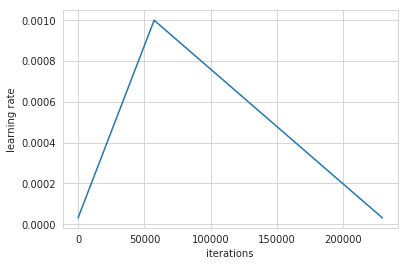

In [49]:
# Plot lr on training
learner.sched.plot_lr()

In [50]:
# Save model
learner.save('<whatever_you_prefer>_emb_sz_16_nh_100_nl_3_v5')

#### Sixth training (drops multiplier of 2.0)

In [51]:
# Load saved model
learner = get_learner(2.0)
learner.load('<whatever_you_prefer>_emb_sz_16_nh_100_nl_3_v5')

In [52]:
%%time
# (1) 16384
lrs=1e-2
wds=1e-6
learner.fit(lrs=lrs, n_cycle=1, cycle_len=16384, wds=wds, use_clr=(32,4))
#learner.fit(lrs=lrs, n_cycle=4, cycle_len=1, cycle_mult=2, wds=wds)

epoch      trn_loss   val_loss   accuracy                  
    0      0.292003   0.35986    0.902292  
    1      0.290122   0.359792   0.901933                  
    2      0.288794   0.362238   0.900256                  
    3      0.286307   0.360882   0.901512                  
    4      0.293809   0.357547   0.901799                  
    5      0.293353   0.359075   0.90138                   
    6      0.290092   0.361114   0.901148                  
    7      0.286404   0.360759   0.901288                  
    8      0.288101   0.359354   0.901552                  
    9      0.292734   0.369709   0.90096                   
    10     0.294384   0.357732   0.902835                  
    11     0.292783   0.357286   0.903563                  
    12     0.296352   0.358265   0.902369                  
    13     0.295293   0.358602   0.9025                    
    14     0.294392   0.360352   0.902127                  
    15     0.301418   0.358868   0.903042               

   271     0.298536   0.361345   0.903084                  
   272     0.299668   0.358252   0.902699                 
   273     0.298088   0.361187   0.902319                  
   274     0.298082   0.362487   0.901411                  
   275     0.295951   0.360461   0.903283                  
   276     0.295332   0.360753   0.90288                   
   277     0.295655   0.359086   0.903391                  
   278     0.2962     0.359305   0.903916                  
   279     0.294721   0.356846   0.903475                  
   280     0.293698   0.355134   0.903815                  
   281     0.293356   0.358462   0.902742                  
   282     0.295174   0.368625   0.900794                  
   283     0.293121   0.356866   0.903392                  
   284     0.29221    0.357428   0.902982                  
   285     0.288507   0.358074   0.902778                  
   286     0.290062   0.357872   0.901075                  
   287     0.288959   0.360698   0.900797

   543     0.296029   0.358923   0.903593                  
   544     0.302072   0.359206   0.904032                  
   545     0.299329   0.358673   0.903448                  
   546     0.303527   0.35652    0.904258                  
   547     0.305588   0.359307   0.903269                  
   548     0.310234   0.357728   0.90209                   
   549     0.315178   0.360159   0.902611                  
   550     0.312672   0.355331   0.902111                  
   551     0.307569   0.355361   0.903511                  
   552     0.307843   0.358423   0.902394                  
   553     0.306689   0.359386   0.902417                  
   554     0.308441   0.35916    0.903125                  
   555     0.303775   0.360378   0.902007                  
   556     0.30858    0.358873   0.902539                  
   557     0.309338   0.357747   0.902858                  
   558     0.308566   0.355968   0.903145                  
   559     0.3061     0.355925   0.90366

   815     0.29962    0.362562   0.897984                  
   816     0.302032   0.36402    0.902742                  
   817     0.303257   0.362608   0.902397                  
   818     0.301963   0.357169   0.903427                  
   819     0.301773   0.360348   0.904677                  
   820     0.300455   0.365619   0.902544                 
   821     0.299586   0.362744   0.902083                  
   822     0.301426   0.362279   0.900825                  
   823     0.30017    0.361526   0.904077                  
   824     0.300982   0.364589   0.901921                  
   825     0.302397   0.360164   0.902628                  
   826     0.302371   0.354766   0.905678                  
   827     0.305391   0.359826   0.9044                    
   828     0.304559   0.355257   0.901142                  
   829     0.305285   0.362121   0.902293                  
   830     0.30343    0.36048    0.901951                  
   831     0.303101   0.360695   0.901583

   1087    0.320975   0.358413   0.900907                  
   1088    0.3228     0.36217    0.900248                  
   1089    0.319302   0.358849   0.902888                  
   1090    0.317812   0.358556   0.903778                  
   1091    0.315598   0.361196   0.902849                  
   1092    0.316975   0.36141    0.904716                  
   1093    0.323492   0.356314   0.902712                  
   1094    0.315284   0.371316   0.898766                  
   1095    0.310038   0.355955   0.903104                  
   1096    0.309389   0.356803   0.902866                  
   1097    0.306848   0.3607     0.902267                  
   1098    0.305106   0.359136   0.898805                  
   1099    0.301635   0.3568     0.902811                  
   1100    0.302236   0.357756   0.902659                  
   1101    0.304901   0.361898   0.901875                  
   1102    0.302385   0.357778   0.903353                  
   1103    0.305512   0.35492    0.90456

   1359    0.313495   0.376111   0.901507                  
   1360    0.310889   0.363034   0.902399                  
   1361    0.312228   0.361387   0.904119                  
   1362    0.312493   0.357764   0.904794                  
   1363    0.311301   0.35606    0.904091                  
   1364    0.312585   0.350595   0.903566                  
   1365    0.325781   0.358325   0.904234                  
   1366    0.319778   0.350527   0.904956                 
   1367    0.314401   0.352084   0.904412                  
   1368    0.310315   0.357742   0.903345                 
   1369    0.308239   0.362656   0.902344                  
   1370    0.308778   0.354487   0.902835                  
   1371    0.31996    0.356747   0.903024                 
   1372    0.317882   0.359099   0.902561                  
   1373    0.320886   0.357238   0.903065                  
   1374    0.315414   0.352237   0.902858                  
   1375    0.317952   0.353621   0.901741  

   1631    0.318075   0.359444   0.901724                  
   1632    0.320929   0.35837    0.902604                  
   1633    0.320554   0.353385   0.900873                  
   1634    0.320205   0.355712   0.90097                  
   1635    0.315604   0.357081   0.901786                  
   1636    0.324178   0.355898   0.902238                  
   1637    0.320602   0.353138   0.902614                  
   1638    0.316661   0.355203   0.903085                  
   1639    0.317059   0.356863   0.902195                  
   1640    0.316803   0.365189   0.900862                  
   1641    0.313671   0.355084   0.90373                   
   1642    0.31543    0.36724    0.899306                  
   1643    0.314903   0.355359   0.901701                  
   1644    0.317156   0.355508   0.903391                  
   1645    0.32027    0.357115   0.902789                 
   1646    0.315926   0.361572   0.902241                  
   1647    0.315717   0.360715   0.900716 

   1903    0.309575   0.359329   0.901042                 
   1904    0.31368    0.372347   0.899321                  
   1905    0.317598   0.355294   0.901971                  
   1906    0.314952   0.361741   0.900974                  
   1907    0.317322   0.366135   0.899364                  
   1908    0.316101   0.363004   0.900621                  
   1909    0.322136   0.365539   0.900191                  
   1910    0.325486   0.356339   0.900521                  
   1911    0.319762   0.358047   0.901254                 
   1912    0.322878   0.355798   0.900208                  
   1913    0.318995   0.358481   0.899698                  
   1914    0.318348   0.358036   0.900338                  
   1915    0.32473    0.357279   0.899434                  
   1916    0.32128    0.359122   0.900504                  
   1917    0.321575   0.357592   0.900232                  
   1918    0.319289   0.354771   0.902192                  
   1919    0.318537   0.357735   0.901801 

   2175    0.322809   0.352013   0.901828                  
   2176    0.32295    0.352303   0.900429                  
   2177    0.320696   0.351254   0.901142                  
   2178    0.315728   0.352408   0.901465                  
   2179    0.313691   0.348228   0.902143                  
   2180    0.320887   0.352833   0.901009                  
   2181    0.321512   0.357982   0.897524                  
   2182    0.321283   0.354214   0.90067                   
   2183    0.320086   0.355378   0.900617                 
   2184    0.320285   0.35234    0.900441                 
   2185    0.322657   0.350416   0.901481                  
   2186    0.326669   0.354083   0.901394                  
   2187    0.324137   0.360205   0.901242                  
   2188    0.324105   0.357151   0.900971                  
   2189    0.322977   0.362153   0.902667                  
   2190    0.321799   0.359096   0.901185                  
   2191    0.319551   0.356242   0.900905 

   2447    0.324948   0.351523   0.900699                  
   2448    0.321962   0.368341   0.898507                  
   2449    0.322596   0.357213   0.899007                  
   2450    0.318255   0.354187   0.901643                  
   2451    0.320105   0.352705   0.90002                   
   2452    0.319231   0.355564   0.899655                  
   2453    0.318656   0.355657   0.899229                  
   2454    0.319281   0.355554   0.897558                  
   2455    0.323945   0.347446   0.899774                  
   2456    0.328329   0.34893    0.901342                  
   2457    0.327532   0.35543    0.899698                  
   2458    0.324726   0.353014   0.901342                  
   2459    0.322364   0.359594   0.902027                  
   2460    0.333208   0.357978   0.900127                  
   2461    0.326994   0.351884   0.898746                  
   2462    0.325214   0.354425   0.899781                  
   2463    0.327851   0.354684   0.89932

   2719    0.335009   0.354146   0.900248                  
   2720    0.331895   0.357974   0.89984                   
   2721    0.331119   0.348219   0.898891                  
   2722    0.330857   0.35005    0.900945                  
   2723    0.331742   0.357103   0.898766                  
   2724    0.333323   0.348767   0.901512                  
   2725    0.329682   0.352168   0.902138                  
   2726    0.328357   0.357322   0.901815                  
   2727    0.327602   0.35311    0.899609                  
   2728    0.340005   0.347521   0.900185                  
   2729    0.337997   0.34855    0.902344                  
   2730    0.338853   0.350563   0.901989                  
   2731    0.338362   0.353458   0.902945                  
   2732    0.340784   0.353185   0.901373                  
   2733    0.333688   0.348808   0.902393                  
   2734    0.329117   0.349113   0.901404                  
   2735    0.329796   0.351313   0.90039

   2991    0.333304   0.353217   0.898759                  
   2992    0.331699   0.349973   0.899524                  
   2993    0.326839   0.354082   0.899408                  
   2994    0.323794   0.352222   0.899938                  
   2995    0.321817   0.353663   0.900907                  
   2996    0.322084   0.349882   0.901521                  
   2997    0.322101   0.353896   0.899539                  
   2998    0.329017   0.353182   0.898179                  
   2999    0.33229    0.349177   0.898437                  
   3000    0.332926   0.367248   0.898502                  
   3001    0.331178   0.353993   0.898438                  
   3002    0.329292   0.354767   0.897997                  
   3003    0.328978   0.352404   0.899214                  
   3004    0.32896    0.348924   0.899224                  
   3005    0.32685    0.348888   0.898897                  
   3006    0.329206   0.347327   0.89864                   
   3007    0.338096   0.347816   0.89833

   3263    0.339991   0.361563   0.89562                   
   3264    0.333823   0.353615   0.898042                  
   3265    0.333931   0.355239   0.897593                  
   3266    0.33103    0.362526   0.897895                  
   3267    0.333108   0.354891   0.898548                  
   3268    0.33554    0.35078    0.899881                  
   3269    0.334029   0.349212   0.8988                    
   3270    0.329914   0.350267   0.897546                 
   3271    0.338305   0.345988   0.896998                  
   3272    0.338158   0.352446   0.896677                  
   3273    0.336075   0.354875   0.899046                  
   3274    0.338435   0.349765   0.898781                  
   3275    0.333604   0.349526   0.901521                  
   3276    0.337886   0.350508   0.899918                  
   3277    0.343069   0.355454   0.899957                  
   3278    0.344394   0.358255   0.898693                  
   3279    0.34271    0.353623   0.899583

   3535    0.34363    0.352396   0.898643                  
   3536    0.344428   0.356745   0.89726                   
   3537    0.350385   0.350818   0.897569                  
   3538    0.354254   0.34919    0.896707                  
   3539    0.355796   0.352228   0.896511                  
   3540    0.352956   0.351008   0.898075                  
   3541    0.353127   0.348185   0.897718                  
   3542    0.352137   0.35229    0.896896                  
   3543    0.350316   0.354033   0.896408                 
   3544    0.345997   0.358396   0.897022                  
   3545    0.341162   0.352885   0.896957                  
   3546    0.341333   0.353602   0.898487                  
   3547    0.350331   0.352607   0.897321                  
   3548    0.349213   0.350235   0.897924                  
   3549    0.353248   0.346951   0.896976                  
   3550    0.349032   0.353181   0.896979                  
   3551    0.352593   0.349881   0.898891

   3807    0.33846    0.351973   0.898489                  
   3808    0.340031   0.356346   0.898938                  
   3809    0.342413   0.35039    0.898738                  
   3810    0.33879    0.353283   0.899219                  
   3811    0.337902   0.356234   0.898587                  
   3812    0.345077   0.352964   0.900021                  
   3813    0.341749   0.354136   0.897774                  
   3814    0.339672   0.349652   0.898819                 
   3815    0.342553   0.35762    0.897441                  
   3816    0.344461   0.354462   0.897736                  
   3817    0.343021   0.353442   0.898686                  
   3818    0.33958    0.354837   0.899214                  
   3819    0.344802   0.359006   0.898182                  
   3820    0.345621   0.369907   0.896388                  
   3821    0.345708   0.360413   0.899224                  
   3822    0.350284   0.352725   0.899525                 
   3823    0.350802   0.350847   0.898175 

   4079    0.354868   0.36822    0.897908                  
   4080    0.349665   0.355566   0.900061                 
   4081    0.344924   0.356096   0.897756                  
   4082    0.345458   0.357246   0.899421                  
   4083    0.347981   0.357777   0.899351                  
   4084    0.34517    0.355607   0.899554                  
   4085    0.345791   0.358843   0.899757                  
   4086    0.353858   0.355621   0.899262                  
   4087    0.355261   0.363901   0.895746                  
   4088    0.360088   0.346376   0.898538                 
   4089    0.354558   0.351397   0.898795                  
   4090    0.357135   0.353777   0.900797                  
   4091    0.359427   0.362739   0.898504                  
   4092    0.360442   0.356214   0.899612                  
   4093    0.361404   0.352472   0.898897                  
   4094    0.362526   0.35347    0.898437                  
   4095    0.360918   0.352769   0.897101 

   4351    0.350215   0.350534   0.900302                 
   4352    0.346616   0.349414   0.901473                  
   4353    0.347615   0.352275   0.901042                  
   4354    0.354148   0.350376   0.898388                  
   4355    0.360731   0.362856   0.894912                  
   4356    0.369306   0.358115   0.899896                  
   4357    0.365007   0.348049   0.898643                  
   4358    0.35834    0.354309   0.89994                   
   4359    0.353759   0.349863   0.898182                  
   4360    0.353493   0.351208   0.898386                  
   4361    0.353207   0.351567   0.901108                  
   4362    0.356661   0.34836    0.899306                  
   4363    0.357286   0.349153   0.900455                  
   4364    0.351535   0.346576   0.900273                  
   4365    0.359769   0.364469   0.897875                  
   4366    0.358613   0.352681   0.897135                  
   4367    0.354628   0.354093   0.89808 

   4623    0.343232   0.346807   0.897232                  
   4624    0.342698   0.348851   0.897512                  
   4625    0.343798   0.344461   0.898489                  
   4626    0.343169   0.348989   0.897917                  
   4627    0.346159   0.351256   0.897382                  
   4628    0.345125   0.349159   0.897441                  
   4629    0.339111   0.354323   0.898185                  
   4630    0.341411   0.356041   0.89879                   
   4631    0.346336   0.352403   0.900168                  
   4632    0.34156    0.355156   0.898489                  
   4633    0.343157   0.355289   0.896297                  
   4634    0.343288   0.354656   0.898485                  
   4635    0.341828   0.353821   0.897336                  
   4636    0.337993   0.351207   0.897861                  
   4637    0.34146    0.353986   0.89868                   
   4638    0.346863   0.353451   0.898129                  
   4639    0.353108   0.352188   0.89787

   4895    0.348702   0.356902   0.897127                  
   4896    0.345668   0.352741   0.898037                  
   4897    0.34698    0.355321   0.896814                  
   4898    0.348454   0.357134   0.898646                  
   4899    0.344281   0.353617   0.895727                  
   4900    0.353362   0.35611    0.897467                  
   4901    0.35357    0.359814   0.898437                  
   4902    0.352019   0.354037   0.898133                  
   4903    0.351814   0.355792   0.897059                  
   4904    0.348861   0.355656   0.897593                  
   4905    0.346759   0.355383   0.896916                  
   4906    0.352338   0.361035   0.896104                  
   4907    0.349355   0.356494   0.897144                  
   4908    0.343693   0.359498   0.899022                  
   4909    0.341625   0.353761   0.899434                  
   4910    0.337355   0.35306    0.899858                  
   4911    0.337023   0.356157   0.89864

   5167    0.350113   0.359716   0.897467                 
   5168    0.347258   0.3814     0.896635                  
   5169    0.341631   0.362605   0.898276                  
   5170    0.338283   0.354393   0.902128                  
   5171    0.336244   0.358148   0.899881                  
   5172    0.338964   0.357276   0.898116                  
   5173    0.346622   0.364929   0.898226                  
   5174    0.345702   0.375306   0.895492                  
   5175    0.342264   0.359624   0.896104                  
   5176    0.338897   0.356396   0.897972                  
   5177    0.344382   0.365695   0.8975                    
   5178    0.349829   0.362429   0.897636                 
   5179    0.349431   0.356278   0.897336                  
   5180    0.34387    0.357386   0.897651                  
   5181    0.340489   0.355421   0.898885                 
   5182    0.340999   0.358775   0.897777                  
   5183    0.347926   0.363839   0.896875  

   5439    0.346741   0.348848   0.898734                  
   5440    0.343359   0.353907   0.897003                  
   5441    0.338764   0.352696   0.900415                  
   5442    0.338774   0.349159   0.897777                  
   5443    0.339248   0.361372   0.897612                  
   5444    0.336074   0.349544   0.900845                  
   5445    0.337603   0.351536   0.899918                  
   5446    0.343929   0.36513    0.898307                  
   5447    0.339523   0.358615   0.899021                 
   5448    0.336329   0.350961   0.899452                  
   5449    0.333129   0.351472   0.899138                  
   5450    0.33778    0.34709    0.89951                   
   5451    0.341495   0.352587   0.898164                  
   5452    0.342228   0.348933   0.898843                  
   5453    0.348386   0.348031   0.89882                   
   5454    0.346821   0.348362   0.898438                  
   5455    0.35022    0.346817   0.899408

   5711    0.350533   0.348992   0.89793                   
   5712    0.346876   0.347457   0.899294                  
   5713    0.346715   0.349421   0.898587                  
   5714    0.351227   0.346766   0.898489                  
   5715    0.345626   0.344531   0.900504                  
   5716    0.344781   0.34429    0.897227                  
   5717    0.342992   0.347554   0.899554                  
   5718    0.338166   0.349023   0.900327                  
   5719    0.337255   0.343503   0.899655                  
   5720    0.335855   0.342543   0.900391                  
   5721    0.331135   0.345804   0.89974                   
   5722    0.335996   0.346604   0.899282                  
   5723    0.335347   0.343791   0.899918                  
   5724    0.335485   0.349878   0.900559                  
   5725    0.336453   0.343377   0.900559                  
   5726    0.337625   0.346487   0.898438                  
   5727    0.343692   0.345955   0.89795

   5983    0.328108   0.350035   0.899093                  
   5984    0.327618   0.348151   0.897022                  
   5985    0.325259   0.349924   0.900577                  
   5986    0.330796   0.348401   0.900876                  
   5987    0.333318   0.346322   0.899938                  
   5988    0.333528   0.359023   0.898181                  
   5989    0.332029   0.349071   0.897615                  
   5990    0.330047   0.345874   0.897558                 
   5991    0.337662   0.349222   0.897441                  
   5992    0.336289   0.353131   0.899214                  
   5993    0.336902   0.345832   0.899022                  
   5994    0.331978   0.347132   0.901042                  
   5995    0.327316   0.353079   0.899349                  
   5996    0.331295   0.345474   0.898897                  
   5997    0.33016    0.348647   0.898168                  
   5998    0.336354   0.343727   0.898958                  
   5999    0.335691   0.35033    0.895408

   6255    0.330851   0.350918   0.897135                  
   6256    0.3304     0.342166   0.899452                  
   6257    0.330249   0.346599   0.898604                 
   6258    0.33531    0.346998   0.897978                  
   6259    0.33242    0.353859   0.896768                  
   6260    0.33427    0.348588   0.897737                  
   6261    0.330529   0.347538   0.898089                  
   6262    0.329097   0.347897   0.897188                  
   6263    0.3264     0.34808    0.898182                  
   6264    0.32455    0.349609   0.897795                  
   6265    0.324774   0.352153   0.899022                  
   6266    0.325577   0.346718   0.897651                  
   6267    0.330263   0.346626   0.899465                  
   6268    0.334275   0.350764   0.898107                  
   6269    0.332928   0.361798   0.896681                  
   6270    0.329896   0.350771   0.9                       
   6271    0.32595    0.34875    0.900152

   6527    0.328819   0.348567   0.896667                  
   6528    0.331247   0.348476   0.897003                  
   6529    0.331545   0.348072   0.900174                  
   6530    0.331108   0.350329   0.899157                  
   6531    0.327768   0.346596   0.89974                   
   6532    0.33392    0.348285   0.8988                    
   6533    0.330203   0.350586   0.89879                  
   6534    0.327609   0.349671   0.89888                   
   6535    0.328533   0.350075   0.899113                  
   6536    0.331906   0.347494   0.899554                  
   6537    0.325261   0.346347   0.898951                  
   6538    0.327092   0.349246   0.900119                  
   6539    0.326903   0.346977   0.897487                  
   6540    0.329821   0.353201   0.8988                    
   6541    0.332449   0.348523   0.899539                  
   6542    0.332001   0.35251    0.900061                  
   6543    0.333865   0.348115   0.897708

   6799    0.32884    0.346151   0.898951                  
   6800    0.338406   0.352655   0.899262                  
   6801    0.334208   0.349996   0.896793                  
   6802    0.329662   0.356117   0.899687                  
   6803    0.325533   0.350112   0.899938                  
   6804    0.323929   0.349499   0.899283                  
   6805    0.321786   0.350749   0.898437                  
   6806    0.327701   0.361184   0.897113                  
   6807    0.330196   0.35785    0.897522                 
   6808    0.327783   0.350359   0.899858                  
   6809    0.327223   0.35235    0.899496                  
   6810    0.319647   0.362308   0.895236                  
   6811    0.322105   0.36035    0.895524                  
   6812    0.322708   0.35251    0.898335                  
   6813    0.323634   0.354662   0.898542                  
   6814    0.32326    0.352612   0.899792                  
   6815    0.320291   0.35396    0.898235

   7071    0.323975   0.346465   0.898065                  
   7072    0.319642   0.360871   0.896901                 
   7073    0.320104   0.346591   0.899383                 
   7074    0.320458   0.343772   0.897467                  
   7075    0.328039   0.345109   0.898703                  
   7076    0.324138   0.346358   0.899294                  
   7077    0.325365   0.347478   0.898646                  
   7078    0.326874   0.356144   0.897113                  
   7079    0.329175   0.347486   0.896962                  
   7080    0.326348   0.350856   0.897718                 
   7081    0.326072   0.34895    0.898489                  
   7082    0.327764   0.345279   0.898885                  
   7083    0.323612   0.345665   0.899375                  
   7084    0.322973   0.351456   0.898958                  
   7085    0.323176   0.352195   0.898854                  
   7086    0.319134   0.348982   0.899582                  
   7087    0.323883   0.349842   0.898129  

   7343    0.328702   0.351298   0.89828                   
   7344    0.323884   0.350885   0.896545                  
   7345    0.325027   0.352066   0.896567                  
   7346    0.320952   0.349616   0.897876                  
   7347    0.329135   0.351634   0.897251                  
   7348    0.32274    0.353667   0.897307                  
   7349    0.326725   0.352274   0.89622                   
   7350    0.326751   0.361178   0.896416                  
   7351    0.322045   0.35244    0.897718                  
   7352    0.323701   0.352063   0.896458                  
   7353    0.329664   0.351904   0.899732                  
   7354    0.327279   0.350761   0.899249                  
   7355    0.331177   0.352659   0.897754                  
   7356    0.334265   0.349235   0.897829                  
   7357    0.325296   0.360859   0.898185                  
   7358    0.328509   0.364378   0.896018                  
   7359    0.324855   0.356163   0.89877

   7615    0.321806   0.350377   0.89994                   
   7616    0.33128    0.351664   0.899816                  
   7617    0.327576   0.359836   0.897065                  
   7618    0.334887   0.354297   0.899219                  
   7619    0.329337   0.351496   0.899877                  
   7620    0.328981   0.35355    0.898597                  
   7621    0.325017   0.351684   0.8988                    
   7622    0.321387   0.351011   0.898538                  
   7623    0.314654   0.353239   0.897467                  
   7624    0.321626   0.353134   0.898172                  
   7625    0.318179   0.354765   0.898129                  
   7626    0.31663    0.359102   0.895548                  
   7627    0.319496   0.353625   0.895731                  
   7628    0.31491    0.353418   0.897924                  
   7629    0.315667   0.351638   0.899031                  
   7630    0.315618   0.363526   0.897104                  
   7631    0.314083   0.351513   0.89838

   7887    0.318743   0.341179   0.900677                  
   7888    0.323563   0.348515   0.898491                  
   7889    0.318844   0.345557   0.900225                  
   7890    0.319064   0.347884   0.899294                  
   7891    0.318016   0.350932   0.89807                   
   7892    0.319911   0.352985   0.898655                 
   7893    0.319333   0.350703   0.898686                  
   7894    0.32275    0.35543    0.898133                  
   7895    0.322193   0.355489   0.899306                  
   7896    0.320813   0.348615   0.898759                  
   7897    0.321422   0.350531   0.899084                  
   7898    0.32576    0.348659   0.898795                  
   7899    0.325785   0.357396   0.897847                  
   7900    0.320551   0.350728   0.899283                  
   7901    0.321428   0.34907    0.896347                  
   7902    0.318516   0.352268   0.896832                  
   7903    0.318204   0.352371   0.89829 

   8159    0.327149   0.349754   0.89994                   
   8160    0.321151   0.352125   0.898849                  
   8161    0.3194     0.349994   0.898192                  
   8162    0.313747   0.349638   0.897441                  
   8163    0.314263   0.349855   0.897336                  
   8164    0.317466   0.348411   0.898638                  
   8165    0.317416   0.357649   0.898276                  
   8166    0.319706   0.349767   0.896393                  
   8167    0.321743   0.347772   0.898389                  
   8168    0.322785   0.348452   0.896959                  
   8169    0.322404   0.356479   0.896847                  
   8170    0.334412   0.353946   0.898587                  
   8171    0.327942   0.353202   0.900441                  
   8172    0.326591   0.357358   0.899294                  
   8173    0.323062   0.365475   0.897017                  
   8174    0.322069   0.34946    0.899781                  
   8175    0.323472   0.35426    0.89704

   8431    0.319896   0.34817    0.900912                 
   8432    0.325535   0.346135   0.900977                  
   8433    0.321825   0.347558   0.899655                  
   8434    0.316354   0.350845   0.900225                  
   8435    0.3144     0.346449   0.899271                  
   8436    0.316164   0.349095   0.897871                  
   8437    0.311561   0.347706   0.897065                  
   8438    0.311516   0.348917   0.89875                   
   8439    0.312024   0.356267   0.898387                  
   8440    0.310401   0.3469     0.900248                 
   8441    0.313328   0.352351   0.898849                  
   8442    0.316442   0.347456   0.899959                  
   8443    0.317019   0.346704   0.900179                  
   8444    0.320377   0.34622    0.899184                  
   8445    0.320972   0.346803   0.899465                  
   8446    0.319125   0.344614   0.900514                  
   8447    0.31656    0.348035   0.897959 

   8703    0.317758   0.342037   0.900833                  
   8704    0.314171   0.34228    0.899691                  
   8705    0.310348   0.340064   0.898487                  
   8706    0.312044   0.342394   0.898843                  
   8707    0.315803   0.344388   0.896537                  
   8708    0.31696    0.344395   0.89793                   
   8709    0.316796   0.343931   0.899881                  
   8710    0.317665   0.344286   0.899375                  
   8711    0.316778   0.34659    0.899698                  
   8712    0.314788   0.349567   0.898786                  
   8713    0.312881   0.352085   0.897287                  
   8714    0.313353   0.345783   0.897379                  
   8715    0.317637   0.351394   0.898958                  
   8716    0.322933   0.347801   0.896875                  
   8717    0.321822   0.346933   0.8987                    
   8718    0.325425   0.341555   0.898885                  
   8719    0.319146   0.351804   0.89676

   8975    0.314064   0.350277   0.899766                  
   8976    0.319129   0.349923   0.898387                  
   8977    0.317577   0.348926   0.897307                  
   8978    0.311753   0.348666   0.900625                  
   8979    0.31291    0.344252   0.899408                  
   8980    0.31012    0.347553   0.897046                  
   8981    0.309939   0.353382   0.898185                 
   8982    0.306417   0.349639   0.897306                  
   8983    0.3065     0.347366   0.898849                  
   8984    0.306773   0.349685   0.898075                  
   8985    0.30524    0.348522   0.899788                  
   8986    0.304099   0.349025   0.898843                  
   8987    0.303773   0.348909   0.897615                  
   8988    0.302295   0.347419   0.900226                  
   8989    0.305507   0.357619   0.896701                  
   8990    0.308327   0.345695   0.899139                  
   8991    0.307996   0.348148   0.898965

   9247    0.313894   0.348245   0.900098                  
   9248    0.317071   0.34509    0.900879                  
   9249    0.313096   0.348243   0.899834                  
   9250    0.313493   0.344137   0.900202                  
   9251    0.313803   0.345818   0.89849                   
   9252    0.319859   0.342416   0.899731                 
   9253    0.322451   0.348348   0.899294                  
   9254    0.315684   0.34967    0.898945                  
   9255    0.312429   0.349675   0.900902                  
   9256    0.308687   0.346407   0.900404                  
   9257    0.30573    0.345836   0.898936                  
   9258    0.303062   0.35016    0.898329                  
   9259    0.306039   0.350662   0.899764                  
   9260    0.307963   0.34628    0.901283                  
   9261    0.305063   0.347275   0.900123                  
   9262    0.303819   0.347403   0.900467                  
   9263    0.303      0.349651   0.89937 

   9519    0.313611   0.340659   0.898992                  
   9520    0.31109    0.355176   0.897358                  
   9521    0.308284   0.342082   0.900082                  
   9522    0.304057   0.342304   0.900912                  
   9523    0.30353    0.348353   0.897791                  
   9524    0.309071   0.346837   0.895762                  
   9525    0.313628   0.342226   0.898587                  
   9526    0.314074   0.346176   0.898489                  
   9527    0.310777   0.345926   0.897558                  
   9528    0.309088   0.347028   0.896725                  
   9529    0.308869   0.34328    0.89854                   
   9530    0.307001   0.343286   0.898388                  
   9531    0.306497   0.348872   0.896897                  
   9532    0.30818    0.344337   0.897795                  
   9533    0.30825    0.344264   0.898903                  
   9534    0.307671   0.343762   0.899942                  
   9535    0.308364   0.349922   0.89586

   9791    0.312959   0.345272   0.899714                  
   9792    0.311141   0.34124    0.898849                  
   9793    0.313015   0.342066   0.900521                  
   9794    0.311905   0.345449   0.900862                  
   9795    0.310637   0.341278   0.90125                   
   9796    0.308056   0.343092   0.900195                  
   9797    0.310338   0.343017   0.900415                  
   9798    0.309802   0.344937   0.89879                   
   9799    0.308669   0.34339    0.899461                  
   9800    0.305647   0.344352   0.900302                  
   9801    0.303531   0.345181   0.899229                  
   9802    0.302051   0.345261   0.898284                  
   9803    0.302524   0.353019   0.898591                  
   9804    0.303843   0.346703   0.898137                  
   9805    0.308969   0.348184   0.898125                  
   9806    0.313491   0.347464   0.896605                  
   9807    0.312057   0.349256   0.89736

  10063    0.307697   0.345939   0.897972                  
  10064    0.307542   0.34693    0.90004                   
  10065    0.307266   0.359852   0.895876                  
  10066    0.304269   0.349888   0.896744                  
  10067    0.303539   0.349881   0.898085                  
  10068    0.304247   0.349702   0.898958                  
  10069    0.306525   0.348139   0.8987                    
  10070    0.309529   0.347513   0.898387                  
  10071    0.307966   0.34324    0.897868                  
  10072    0.307937   0.344038   0.897454                  
  10073    0.303167   0.347222   0.898437                  
  10074    0.30529    0.344752   0.898032                  
  10075    0.306619   0.349137   0.899093                  
  10076    0.307964   0.346859   0.898593                  
  10077    0.30666    0.344085   0.900082                  
  10078    0.302942   0.347508   0.898945                  
  10079    0.308364   0.345756   0.89717

  10335    0.303565   0.339463   0.900559                  
  10336    0.305711   0.344339   0.900225                  
  10337    0.305032   0.346004   0.900971                  
  10338    0.304109   0.345398   0.900338                  
  10339    0.303043   0.342738   0.900455                  
  10340    0.307545   0.343828   0.901174                  
  10341    0.312247   0.345222   0.899306                  
  10342    0.313765   0.345186   0.901904                  
  10343    0.317832   0.345526   0.902318                  
  10344    0.319412   0.346254   0.901293                  
  10345    0.317683   0.342401   0.901458                  
  10346    0.314093   0.343166   0.900082                  
  10347    0.314607   0.340117   0.901042                  
  10348    0.313144   0.341118   0.899731                  
  10349    0.309708   0.344425   0.901108                 
  10350    0.306907   0.353844   0.896501                  
  10351    0.303429   0.343774   0.899375

  10607    0.301643   0.346363   0.897718                  
  10608    0.301129   0.34784    0.898595                  
  10609    0.306125   0.345633   0.89951                   
  10610    0.303478   0.349318   0.899401                  
  10611    0.302241   0.343381   0.898335                  
  10612    0.298729   0.345247   0.898591                  
  10613    0.296317   0.345199   0.897946                  
  10614    0.295784   0.348502   0.89726                   
  10615    0.293698   0.348307   0.899959                  
  10616    0.294247   0.345423   0.899959                  
  10617    0.296538   0.346726   0.899798                  
  10618    0.299583   0.347587   0.900162                 
  10619    0.303452   0.34588    0.901649                  
  10620    0.30366    0.346224   0.900514                  
  10621    0.300889   0.353838   0.897866                  
  10622    0.297758   0.347064   0.899203                  
  10623    0.297253   0.347317   0.898958

  10879    0.294239   0.356737   0.898371                  
  10880    0.296446   0.344097   0.900467                  
  10881    0.302597   0.343374   0.899881                  
  10882    0.298232   0.34789    0.901142                  
  10883    0.296566   0.344309   0.89908                   
  10884    0.300513   0.345522   0.900308                  
  10885    0.299923   0.346073   0.901112                 
  10886    0.297038   0.347605   0.90149                   
  10887    0.302439   0.345587   0.901816                  
  10888    0.295998   0.342708   0.901076                  
  10889    0.303525   0.348155   0.900082                  
  10890    0.306      0.351896   0.898437                  
  10891    0.302893   0.346159   0.899677                  
  10892    0.302413   0.342746   0.899774                  
  10893    0.305727   0.351985   0.901757                  
  10894    0.303735   0.349909   0.899829                  
  10895    0.301555   0.348371   0.900819

  11151    0.297108   0.345224   0.899496                  
  11152    0.302492   0.345064   0.900218                  
  11153    0.309453   0.343214   0.900752                  
  11154    0.311832   0.341111   0.900586                  
  11155    0.308618   0.341849   0.900288                  
  11156    0.306669   0.344046   0.899408                  
  11157    0.301428   0.344092   0.898332                  
  11158    0.303724   0.344699   0.900729                  
  11159    0.301507   0.343194   0.900438                  
  11160    0.296851   0.34489    0.898491                  
  11161    0.295769   0.344891   0.900354                  
  11162    0.2954     0.344579   0.899388                  
  11163    0.293127   0.343421   0.900041                  
  11164    0.292421   0.344944   0.899539                  
  11165    0.298542   0.344814   0.899748                  
  11166    0.297104   0.344092   0.898897                  
  11167    0.292873   0.344953   0.89981

  11423    0.302348   0.343595   0.901583                  
  11424    0.306423   0.344547   0.900975                  
  11425    0.30431    0.34807    0.900568                  
  11426    0.304702   0.347077   0.89808                   
  11427    0.301972   0.347252   0.899707                  
  11428    0.30583    0.34249    0.901801                  
  11429    0.30923    0.344056   0.901727                  
  11430    0.302319   0.347164   0.900587                  
  11431    0.299417   0.347383   0.900706                  
  11432    0.298671   0.34716    0.902035                  
  11433    0.296627   0.345788   0.900403                  
  11434    0.297451   0.353856   0.898942                  
  11435    0.301237   0.345074   0.900257                  
  11436    0.299725   0.344947   0.903085                 
  11437    0.298376   0.344727   0.899958                  
  11438    0.304147   0.343266   0.901144                  
  11439    0.302639   0.344713   0.902393

  11695    0.297135   0.345298   0.90114                   
  11696    0.305458   0.352345   0.897962                  
  11697    0.29958    0.344481   0.902936                 
  11698    0.295755   0.349287   0.900364                  
  11699    0.29717    0.356174   0.89965                   
  11700    0.293931   0.347595   0.902143                  
  11701    0.294512   0.35165    0.902417                  
  11702    0.295526   0.347367   0.902637                  
  11703    0.296172   0.349584   0.900021                  
  11704    0.295214   0.34976    0.901278                  
  11705    0.290033   0.349334   0.901458                 
  11706    0.288512   0.345369   0.900873                  
  11707    0.291436   0.347802   0.901654                  
  11708    0.291597   0.347416   0.901387                  
  11709    0.292435   0.346373   0.90076                   
  11710    0.295831   0.346562   0.901442                  
  11711    0.292902   0.346212   0.900288 

  11967    0.293457   0.349001   0.9012                    
  11968    0.293525   0.346447   0.901213                  
  11969    0.292039   0.348233   0.89881                   
  11970    0.293106   0.345261   0.901105                  
  11971    0.292206   0.352551   0.89957                   
  11972    0.288966   0.345016   0.900288                  
  11973    0.292643   0.346923   0.898707                  
  11974    0.28934    0.347525   0.89903                   
  11975    0.289597   0.344279   0.898945                  
  11976    0.292418   0.348145   0.9                       
  11977    0.297475   0.347195   0.898903                  
  11978    0.296958   0.36117    0.895299                  
  11979    0.292775   0.352964   0.899316                  
  11980    0.29344    0.351519   0.900302                  
  11981    0.295494   0.34825    0.899524                  
  11982    0.296203   0.347567   0.898646                  
  11983    0.295163   0.348527   0.89709

  12239    0.300735   0.350197   0.900191                  
  12240    0.295429   0.340637   0.900041                  
  12241    0.29385    0.343871   0.900499                  
  12242    0.295632   0.343462   0.901426                  
  12243    0.300025   0.34267    0.900873                 
  12244    0.296881   0.342111   0.900568                  
  12245    0.296993   0.342559   0.900802                  
  12246    0.302972   0.352493   0.897847                  
  12247    0.301271   0.344304   0.899916                  
  12248    0.298497   0.344971   0.90067                   
  12249    0.303539   0.34253    0.900973                  
  12250    0.30491    0.345853   0.901743                  
  12251    0.303262   0.346373   0.901552                  
  12252    0.296016   0.345594   0.900417                  
  12253    0.298571   0.344664   0.900316                  
  12254    0.294959   0.341329   0.900377                  
  12255    0.291592   0.344125   0.9     

  12511    0.29113    0.357296   0.899664                  
  12512    0.296543   0.348002   0.901875                  
  12513    0.301607   0.350308   0.902621                  
  12514    0.297984   0.346879   0.902945                  
  12515    0.300652   0.346331   0.902051                  
  12516    0.294875   0.344201   0.902192                  
  12517    0.293974   0.34967    0.901573                  
  12518    0.292775   0.343327   0.90183                   
  12519    0.301157   0.345419   0.902568                  
  12520    0.295871   0.34378    0.902744                  
  12521    0.298784   0.341809   0.902007                  
  12522    0.294458   0.343394   0.901859                  
  12523    0.298994   0.342733   0.901875                  
  12524    0.299822   0.346199   0.90121                   
  12525    0.294745   0.345088   0.901206                  
  12526    0.290815   0.341428   0.903991                  
  12527    0.291743   0.345041   0.90107

  12783    0.292685   0.341081   0.904272                  
  12784    0.291235   0.34264    0.903382                  
  12785    0.285541   0.342741   0.902845                  
  12786    0.290278   0.348046   0.901583                 
  12787    0.287033   0.345237   0.903186                  
  12788    0.286661   0.345882   0.901875                  
  12789    0.288478   0.34174    0.902637                  
  12790    0.288343   0.34213    0.90121                   
  12791    0.288363   0.33935    0.902269                  
  12792    0.286888   0.341318   0.901943                  
  12793    0.287674   0.346412   0.901426                  
  12794    0.289354   0.344492   0.901503                  
  12795    0.28898    0.3416     0.90138                   
  12796    0.288097   0.34186    0.901531                  
  12797    0.284686   0.339813   0.902421                  
  12798    0.295832   0.342791   0.901727                  
  12799    0.294175   0.341022   0.902621

  13055    0.284306   0.341872   0.902447                  
  13056    0.285735   0.342722   0.901743                  
  13057    0.282244   0.341795   0.903166                  
  13058    0.280235   0.341842   0.903105                  
  13059    0.279433   0.343913   0.900905                  
  13060    0.282173   0.345477   0.901933                  
  13061    0.279171   0.344349   0.902708                  
  13062    0.284276   0.347343   0.902858                  
  13063    0.285247   0.342366   0.9025                    
  13064    0.286042   0.345574   0.902419                  
  13065    0.286134   0.342778   0.902708                  
  13066    0.284155   0.34309    0.90209                   
  13067    0.284117   0.345091   0.901989                  
  13068    0.283051   0.346541   0.901605                  
  13069    0.282853   0.342462   0.902544                  
  13070    0.28663    0.344871   0.901743                  
  13071    0.288435   0.345506   0.90194

  13327    0.291866   0.341762   0.904728                  
  13328    0.296142   0.342798   0.904244                  
  13329    0.291714   0.342171   0.903958                  
  13330    0.289845   0.341832   0.903042                  
  13331    0.292965   0.356926   0.899595                  
  13332    0.288531   0.342206   0.903542                  
  13333    0.28951    0.34463    0.902932                 
  13334    0.288265   0.346456   0.904133                  
  13335    0.28713    0.346084   0.903168                  
  13336    0.285178   0.346629   0.902611                  
  13337    0.282826   0.347369   0.902369                  
  13338    0.280395   0.344497   0.90183                   
  13339    0.278963   0.344693   0.900391                  
  13340    0.278672   0.344724   0.90209                   
  13341    0.281476   0.343328   0.902544                  
  13342    0.278471   0.345062   0.902504                  
  13343    0.279474   0.34644    0.903353

  13599    0.288973   0.342248   0.904718                  
  13600    0.287401   0.343311   0.904153                  
  13601    0.285574   0.344677   0.903104                  
  13602    0.280575   0.344058   0.902923                  
  13603    0.283897   0.341495   0.903437                  
  13604    0.283173   0.342322   0.902789                  
  13605    0.281841   0.343602   0.903595                  
  13606    0.28308    0.344447   0.903409                  
  13607    0.286283   0.343515   0.902845                  
  13608    0.284422   0.343492   0.904335                  
  13609    0.280756   0.344283   0.903288                  
  13610    0.279042   0.345796   0.901605                  
  13611    0.277612   0.343878   0.902468                  
  13612    0.277122   0.343511   0.902319                  
  13613    0.282215   0.348359   0.903146                  
  13614    0.282274   0.343707   0.903188                  
  13615    0.283721   0.352166   0.90086

  13871    0.284768   0.341556   0.902744                  
  13872    0.28311    0.342734   0.902778                  
  13873    0.280436   0.342883   0.902016                 
  13874    0.280037   0.342769   0.902888                  
  13875    0.282272   0.344586   0.901679                  
  13876    0.279715   0.343856   0.903021                 
  13877    0.280075   0.343925   0.903125                 
  13878    0.279312   0.344017   0.902265                  
  13879    0.283256   0.343063   0.902444                  
  13880    0.284246   0.342628   0.901786                  
  13881    0.283188   0.345209   0.901177                  
  13882    0.287372   0.341846   0.901458                  
  13883    0.283487   0.33963    0.901904                  
  13884    0.285777   0.342497   0.903223                  
  13885    0.288519   0.344074   0.901113                  
  13886    0.287371   0.341221   0.902244                  
  13887    0.285965   0.340631   0.901348  

  14143    0.284114   0.339201   0.904956                  
  14144    0.285106   0.350283   0.900826                  
  14145    0.286796   0.338109   0.904063                  
  14146    0.286496   0.340956   0.902825                  
  14147    0.286704   0.340699   0.903294                  
  14148    0.286448   0.338574   0.903946                  
  14149    0.2881     0.341675   0.903391                  
  14150    0.283425   0.34011    0.904309                  
  14151    0.281157   0.341886   0.903481                  
  14152    0.280605   0.349048   0.900473                  
  14153    0.276041   0.341218   0.903505                  
  14154    0.275645   0.343652   0.903679                  
  14155    0.276201   0.341367   0.904322                  
  14156    0.277779   0.344122   0.903314                  
  14157    0.281274   0.344318   0.903083                  
  14158    0.281653   0.343625   0.902778                  
  14159    0.281227   0.346109   0.90173

  14415    0.281482   0.341766   0.90512                   
  14416    0.280518   0.341009   0.903333                  
  14417    0.28333    0.343934   0.902419                  
  14418    0.283056   0.34248    0.903339                  
  14419    0.281265   0.343899   0.902802                  
  14420    0.280068   0.342852   0.903125                  
  14421    0.284593   0.344591   0.902478                  
  14422    0.281277   0.344813   0.901311                  
  14423    0.280103   0.342468   0.903003                 
  14424    0.27838    0.344598   0.902439                  
  14425    0.279898   0.342729   0.901786                  
  14426    0.278354   0.341527   0.90217                   
  14427    0.278405   0.345611   0.90081                   
  14428    0.288776   0.341207   0.901979                  
  14429    0.288639   0.341913   0.901757                  
  14430    0.286448   0.343009   0.902902                  
  14431    0.285093   0.342093   0.902945

  14687    0.279695   0.342633   0.902995                  
  14688    0.281988   0.342051   0.90338                   
  14689    0.278226   0.339958   0.90356                   
  14690    0.276968   0.344238   0.904285                  
  14691    0.276293   0.344323   0.902597                  
  14692    0.277846   0.351042   0.90191                   
  14693    0.2764     0.343532   0.903946                  
  14694    0.279807   0.342997   0.904297                 
  14695    0.278398   0.342782   0.903646                  
  14696    0.285556   0.340335   0.902917                  
  14697    0.281355   0.340552   0.903542                  
  14698    0.280468   0.342708   0.903294                 
  14699    0.289331   0.34226    0.904153                  
  14700    0.284467   0.342115   0.903212                  
  14701    0.283185   0.342048   0.90332                   
  14702    0.280271   0.340725   0.902685                  
  14703    0.284351   0.341454   0.904579 

  14959    0.275195   0.339852   0.90387                   
  14960    0.273666   0.340858   0.904074                  
  14961    0.276399   0.341012   0.903854                  
  14962    0.276075   0.34255    0.904077                  
  14963    0.282293   0.346042   0.903233                  
  14964    0.279466   0.341259   0.904221                  
  14965    0.277838   0.342439   0.905583                  
  14966    0.278955   0.343956   0.903716                  
  14967    0.273805   0.343546   0.903427                  
  14968    0.274317   0.340382   0.903713                  
  14969    0.278427   0.341702   0.902945                  
  14970    0.276997   0.343367   0.902105                  
  14971    0.281899   0.343191   0.902574                  
  14972    0.280363   0.345765   0.903253                  
  14973    0.279733   0.344915   0.904115                  
  14974    0.278338   0.34271    0.903921                  
  14975    0.2755     0.340123   0.90397

  15231    0.276772   0.342005   0.903212                  
  15232    0.275513   0.339663   0.903713                  
  15233    0.275092   0.340437   0.903314                  
  15234    0.276636   0.340106   0.902604                  
  15235    0.273733   0.342004   0.902652                  
  15236    0.273834   0.342544   0.901648                  
  15237    0.273458   0.341001   0.902344                  
  15238    0.271583   0.342705   0.902471                  
  15239    0.272065   0.342604   0.903481                  
  15240    0.271627   0.351436   0.900604                  
  15241    0.275425   0.341556   0.902789                  
  15242    0.276894   0.342623   0.902849                  
  15243    0.277503   0.344324   0.902561                  
  15244    0.275052   0.340602   0.90368                   
  15245    0.271652   0.340179   0.903762                  
  15246    0.270547   0.342193   0.903144                  
  15247    0.279628   0.340043   0.90429

  15503    0.274051   0.341641   0.903949                  
  15504    0.27881    0.342385   0.902265                  
  15505    0.278948   0.342668   0.903085                  
  15506    0.275305   0.342641   0.90288                   
  15507    0.273696   0.342239   0.90266                   
  15508    0.271704   0.342981   0.902778                  
  15509    0.275113   0.341798   0.903963                  
  15510    0.275728   0.341441   0.903916                  
  15511    0.275792   0.34268    0.903505                  
  15512    0.276106   0.342687   0.903628                  
  15513    0.273764   0.343029   0.903877                  
  15514    0.273006   0.342942   0.903762                  
  15515    0.274008   0.343279   0.903863                  
  15516    0.274344   0.342742   0.90338                   
  15517    0.273545   0.342339   0.90338                   
  15518    0.270724   0.343774   0.902694                  
  15519    0.270375   0.341469   0.90331

  15775    0.272705   0.342611   0.904033                  
  15776    0.269381   0.341169   0.904459                  
  15777    0.271268   0.342494   0.903697                  
  15778    0.271941   0.341608   0.903308                  
  15779    0.272689   0.342019   0.903628                  
  15780    0.269153   0.342341   0.904032                  
  15781    0.268779   0.343515   0.903896                  
  15782    0.267075   0.349643   0.900651                  
  15783    0.265485   0.350529   0.901414                  
  15784    0.267404   0.351234   0.901336                  
  15785    0.268872   0.342165   0.904173                  
  15786    0.267406   0.341317   0.904395                  
  15787    0.276431   0.339687   0.904459                  
  15788    0.284404   0.34929    0.899894                  
  15789    0.278418   0.340633   0.903854                  
  15790    0.273994   0.342425   0.904234                  
  15791    0.273286   0.341094   0.90452

  16047    0.272608   0.34253    0.90375                   
  16048    0.270359   0.342208   0.904018                  
  16049    0.269294   0.354199   0.900507                  
  16050    0.26932    0.343695   0.903524                  
  16051    0.271594   0.343652   0.903799                  
  16052    0.272525   0.343619   0.904133                  
  16053    0.270555   0.343685   0.903274                  
  16054    0.271997   0.344338   0.903664                  
  16055    0.274438   0.341936   0.90406                   
  16056    0.272315   0.35269    0.901169                  
  16057    0.271495   0.343759   0.903294                  
  16058    0.27384    0.342312   0.903399                  
  16059    0.272532   0.341262   0.903542                  
  16060    0.269144   0.344627   0.903017                  
  16061    0.268008   0.34261    0.904091                  
  16062    0.265945   0.343813   0.903716                  
  16063    0.265836   0.342522   0.90406

  16319    0.268614   0.342426   0.904074                  
  16320    0.269912   0.344001   0.903863                  
  16321    0.268577   0.34178    0.904062                  
  16322    0.2676     0.341549   0.903577                  
  16323    0.269507   0.343588   0.903409                  
  16324    0.268364   0.341384   0.9044                    
  16325    0.267365   0.34248    0.904481                  
  16326    0.269033   0.342368   0.90447                   
  16327    0.270687   0.342458   0.904285                 
  16328    0.272105   0.343204   0.904153                  
  16329    0.26811    0.341678   0.904375                  
  16330    0.268786   0.342241   0.904707                  
  16331    0.267086   0.342116   0.904271                  
  16332    0.267127   0.34203    0.904167                  
  16333    0.266035   0.352182   0.901084                  
  16334    0.264822   0.342617   0.903943                  
  16335    0.263608   0.342724   0.903799

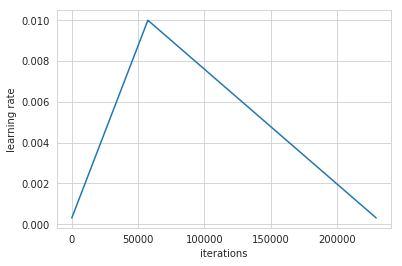

In [53]:
# Plot lr on training
learner.sched.plot_lr()

In [54]:
# Save model
learner.save('<whatever_you_prefer>_emb_sz_16_nh_100_nl_3_v6')

### Obtain pre-trained learner

In [32]:
# Load saved model
learner.load('<whatever_you_prefer>_emb_sz_16_nh_100_nl_3_v6')

## Testing AWD LSTM Model

### Functions

In [ ]:
def form_input(x):
    ''' Form input for prediction (forward pass of the model in testing time)
    '''
    x = torch.LongTensor(x)
    x = to_gpu(x)
    x = x.unsqueeze(0)
    x = x.transpose(0,1)
    return x


def get_model():
    '''  Get model from saved architecture
    '''
    
    # Data Model Hyper Parameters
    bptt=64
    bs=64
    vocab_size = len(events_all)

    # Data Model
    trn_dl  = LanguageModelLoader(np.stack(seq_id_trn), bs, bptt)
    val_dl  = LanguageModelLoader(np.stack(seq_id_val), bs, bptt)
    test_dl = LanguageModelLoader(np.stack(seq_id_test), bs, bptt)
    md = LanguageModelData(path=path_model, pad_idx=None, n_tok=vocab_size, bs=bs, bptt=bptt, 
                       trn_dl=trn_dl, val_dl=val_dl, test_dl=test_dl)

    # Architecture Hyper Parameters
    emb_sz=16
    nh=100
    nl=3
    opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
    drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*2.0

    # LSTM Based Model Model
    learner = md.get_model(opt_fn, emb_sz, nh, nl, 
                       dropouti=drops[0], 
                       dropout=drops[1], 
                       wdrop=drops[2], 
                       dropoute=drops[3], 
                       dropouth=drops[4])
    learner.metrics = [accuracy]
    learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1) # AR and TAR
    learner.clip = 0.3
    learner.unfreeze()
    
    # Load model
    learner.load('<whatever_you_prefer>_emb_sz_16_nh_100_nl_3_v6')
    m = learner.model
    m.eval()
    set_trainable(m, False)
    m.reset()
    return m

In [53]:
def find_threshold(probs):
    ''' Get the most common value (it functions as a natural threshold)
    '''
    frequencies = Counter(p for p in probs)
    return frequencies.most_common(10)[0][0]


def plot_hist_prob_of_event2(preds, pred_pos, sequence, plot=False, display=False):
    ''' Plot histogram of one specific event. Mark in orange the probability of the 
        corresponding event. It prints out whether this probability is above the 
        natural threshold.
    '''
    seq_pos  = pred_pos + 1
    #probs_log = np.log(to_np(preds[pred_pos]))
    #probs_log = probs_log - probs_log[np.argmin(probs_log)]
    probs_log = to_np(preds[pred_pos])
    thr = find_threshold(probs_log)
    prob_event = probs_log[sequence[seq_pos]]
    if display:
        ids_above_thr = [id_ for id_ in range(probs_log.shape[0]) if probs_log[id_] > thr]
        print(f'Event at position {seq_pos}: {sequence[seq_pos]} ({itos[sequence[seq_pos]]})')
        print(f'Event {sequence[seq_pos]} above thr: {prob_event > thr}')
        print(f'Events above thr ({len(ids_above_thr)}): {ids_above_thr}')
    if plot:
        plt.figure(figsize=(18,6))
        plt.bar(list(range(probs_log.shape[0])) ,probs_log)
        plt.bar(sequence[seq_pos], probs_log[sequence[seq_pos]])
        plt.show()
    return prob_event > thr


def plot_hist_prob_of_event(preds, pred_pos, sequence):
    ''' Plot histogram of one specific event. Mark in orange the probability of the 
        corresponding event
    '''
    seq_pos  = pred_pos + 1
    print(f'Event at position {seq_pos}: {sequence[seq_pos]} ({itos[sequence[seq_pos]]})')
    #probs_log = np.log(to_np(preds[pred_pos]))              <- remove this to get probability values directly
    #probs_log = probs_log - probs_log[np.argmin(probs_log)] <- remove this to get probability values directly
    probs_log = to_np(preds[pred_pos])
    thr = find_threshold(probs_log)
    print(f'thr = {thr}')
    print(f'probs_log = {probs_log[sequence[seq_pos]]}')
    plt.figure(figsize=(18,6))
    plt.bar(list(range(probs_log.shape[0])) ,probs_log)
    plt.bar(sequence[seq_pos], probs_log[sequence[seq_pos]])
    plt.show()


def plot_hist_events_over_thr(preds, pred_pos, plot_over_thr=False, name=None):
    ''' Plot histogram of one specific event. Mark in orange the probabilities above 
        the natural threshold 
    '''
    seq_pos  = pred_pos + 1
    #probs_log = np.log(to_np(preds[pred_pos]))
    #probs_log = probs_log - probs_log[np.argmin(probs_log)]
    probs_log = to_np(preds[pred_pos])
    print(sorted(probs_log))
    thr = find_threshold(probs_log)
    plt.figure(figsize=(18,6))
    plt.bar(list(range(probs_log.shape[0])) ,probs_log)
    if plot_over_thr:
        plt.bar(np.where(probs_log > thr)[0], probs_log[probs_log > thr])
    if name != None:
        name = name+'.eps'
        plt.savefig(path_test/name, dpi=1000, bbox_inches='tight', pad_inches=0.05)
    plt.show()

In [ ]:
def get_alerts_best_thr(preds, seq_id_test, seq_id_trn):
    ''' Get alerts based on best/natural threshold (dynamic approach). In this implementaion the 
        following lists contain indexes of the malicious events:
          - unseen_idxs
          - alert3_idxs
          - alert6_idxs
          - malicious_idxs
        
        You can customize these lists based on your needs or even aggregate them in one list
        containing all the indexes of malicious events. Refer to lines 32-35 in this cell and 
        to the proper changes.
    '''
    n_preds = list(range(preds.shape[0] - 1)) # we discard the last prediction as it cannot be validated 
                                              # there is not actual event to know whether it is an anomaly
    alerts = [0] # first element in sequence cannot be predicted - so we say it is not anomalous / alert = 0
    ids_test_not_in_trn = list(set(seq_id_test) - set(seq_id_trn))
    fp_positions = []
    len_of_set_K = []
    for i in n_preds:
        pred_pos = i
        seq_pos  = pred_pos + 1
        probs_log = to_np(preds[pred_pos])
        thr = find_threshold(probs_log)
        probable_events = list(np.where(probs_log > thr)[0])
        #print(probable_events)
        len_of_set_K.append(len(probable_events))
        alert = 0 if seq_id_test[seq_pos] in probable_events else 1
        alerts.append(alert)
        if (alert == 1 and 
            seq_pos not in unseen_idxs and
            seq_pos not in alert3_idxs and
            seq_pos not in alert6_idxs and 
            seq_pos not in malicious_idxs): fp_positions.append(seq_pos)     
    return alerts, fp_positions, len_of_set_K


def get_alerts_specific_k(preds, seq_id_test, seq_id_trn, k=5):
    ''' Get alerts based using a fixed number of k (static approach). In this implementaion the 
        following lists contain indexes of the malicious events:
          - unseen_idxs
          - alert3_idxs
          - alert6_idxs
          - malicious_idxs
        
        You can customize these lists based on your needs or even aggregate them in one list
        containing all the indexes of malicious events. Refer to lines 69-72 in this cell and 
        to the proper changes.
    '''
    n_preds = list(range(preds.shape[0] - 1))
    alerts = [0]
    ids_test_not_in_trn = list(set(seq_id_test) - set(seq_id_trn))
    fp_positions = []
    for i in n_preds:
        pred_pos = i
        seq_pos  = pred_pos + 1
        probs_log = list(to_np(preds[pred_pos]))
        indices   = list(range(len(probs_log)))
        probs_log, indices = zip(*sorted(zip(probs_log, indices), key=lambda pair: pair[0], reverse=True))
        highest_probs = []
        probable_events = []
        for j, p in enumerate(probs_log):
            if p not in highest_probs: highest_probs.append(p)
            if len(highest_probs) > k: break
            probable_events.append(indices[j])
        #print(probable_events)
        alert = 0 if seq_id_test[seq_pos] in probable_events else 1
        alerts.append(alert)
        if (alert == 1 and 
            seq_pos not in unseen_idxs and
            seq_pos not in alert3_idxs and
            seq_pos not in alert6_idxs and 
            seq_pos not in malicious_idxs): fp_positions.append(seq_pos)     
    return alerts, fp_positions


def get_ad_metrics(preds, seq_id_test, seq_id_trn, k=None):
    if k == None:
        alerts, fp_positions, _ = get_alerts_best_thr(preds, seq_id_test, seq_id_trn)
    else:
        alerts, fp_positions    = get_alerts_specific_k(preds, seq_id_test, seq_id_trn, k=k)
    
    # Add you own de to come with:
    tp = #
    fn = #
    fp = #
    tn = #
    return tp, fn, fp, tn, round(100*tp/(tp+fn), 2), round(100*fp/(fp+tn), 2)

### Examples of how to test

#### Prepare input to get predictions

In [24]:
# Get input
inp = form_input(seq_id_test)
inp.size()

torch.Size([66972, 1])

In [25]:
# Do prediction. Index 0 is output of model. Indexes 1 and 2 are output and raw_output of econder.
m = get_model()
m.reset()
preds = m(VV(inp))
preds = preds[0]
preds.shape  

torch.Size([66972, 175])

In [26]:
# Normalize with Softmax
preds = F.softmax(preds)
preds.shape 

torch.Size([66972, 175])

#### Print histograms with probabilities to see if there is a natural clustering

Event at position 1: 30 (8002-01-01-NN-01)
thr = 0.005018448922783136
probs_log = 0.0249611958861351


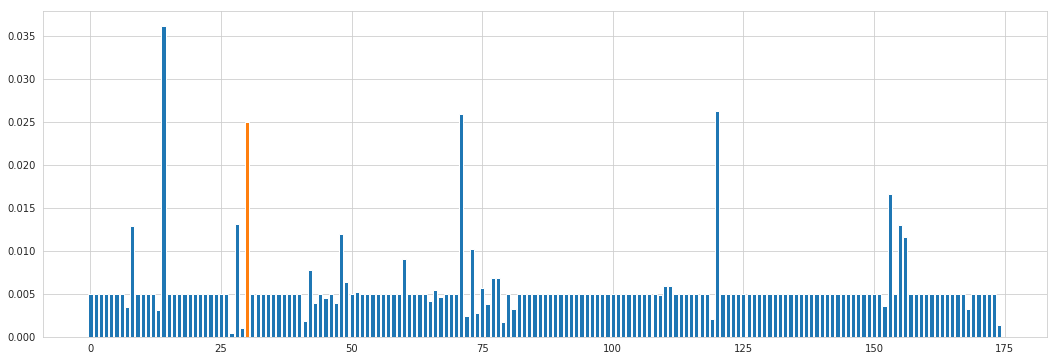

In [39]:
# Get prob dist of event in position "pred_pos+1" of the sequence (position "pred_pos" in predictions)
#  - In orange the event in postion "pred_pos+1" of the sequence
pred_pos = 0
plot_hist_prob_of_event(preds, pred_pos, seq_id_test)

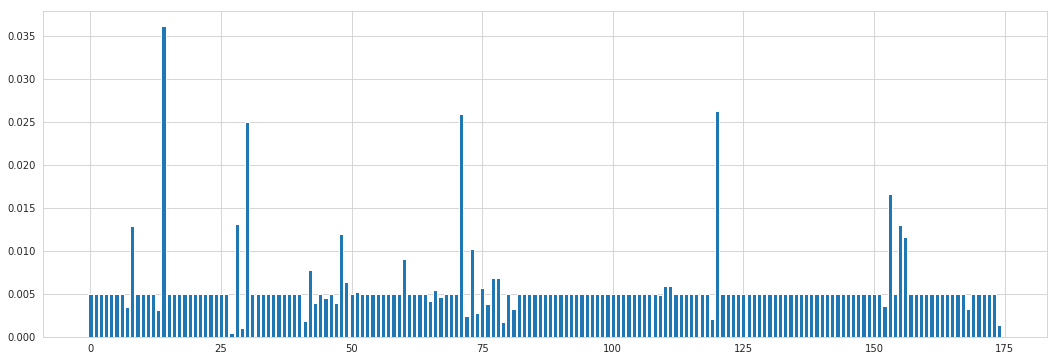

In [49]:
# Get prob dist of event in position "pred_pos+1" of the sequence (position "pred_pos" in predictions)
#  - In orange all the events above the natural threshold
red_pos = 0
plot_hist_events_over_thr(preds, pred_pos, plot_over_thr=False, name='hist_one_coloer')

[0.0004557809, 0.0010189891, 0.0013848931, 0.0017591577, 0.00178705, 0.0020780575, 0.0024202634, 0.002766901, 0.0030954909, 0.0031835793, 0.0032216369, 0.0035072905, 0.003632669, 0.0037964042, 0.003920337, 0.003938315, 0.0041895434, 0.004470124, 0.004652343, 0.004896546, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 0.005018449, 

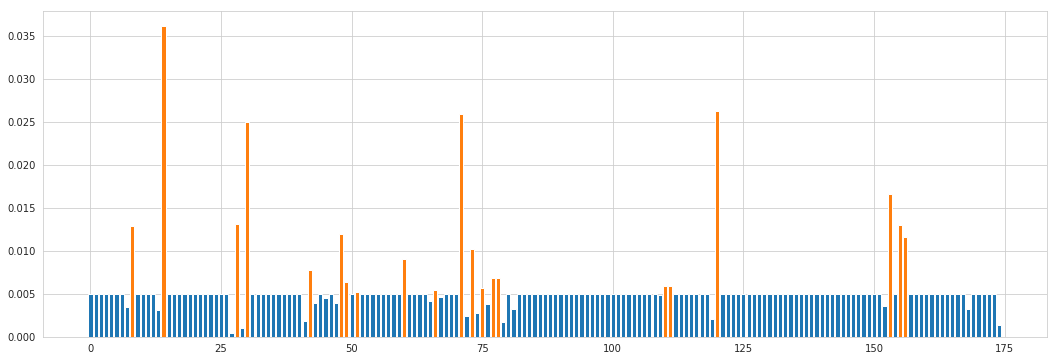

In [54]:
# Get prob dist of event in position "pred_pos+1" of the sequence (position "pred_pos" in predictions)
#  - In orange all the events above the natural threshold
red_pos = 0
plot_hist_events_over_thr(preds, pred_pos, plot_over_thr=True, name=None)

#### Getting metrics 

In [28]:
# Example of how to use it below. Notice you can save the results as a csv.
ks = list(range(1,51))
ks.insert(0, None)
rows = []
for i, k in enumerate(ks):
    row = list(get_ad_metrics(preds, seq_id_test, seq_id_trn, k=k))
    if k == None:
        row.insert(0,str('k_*'))
    else:
        row.insert(0,str(k))
    rows.append(row)
    print(f'k={row[0]}, tp={row[1]}, fn={row[2]}, fp={row[3]}, tn={row[4]}, tpr={row[5]}, fpr={row[6]}')
df=pd.DataFrame(rows, columns=['k', 'tp', 'fn', 'fp', 'tn', 'tpr', 'fpr'])

k=k_*, tp=287, fn=8, fp=254, tn=66423, tpr=97.29, fpr=0.38
k=1, tp=295, fn=0, fp=18135, tn=48542, tpr=100.0, fpr=27.2
k=2, tp=287, fn=8, fp=695, tn=65982, tpr=97.29, fpr=1.04
k=3, tp=287, fn=8, fp=542, tn=66135, tpr=97.29, fpr=0.81
k=4, tp=287, fn=8, fp=485, tn=66192, tpr=97.29, fpr=0.73
k=5, tp=287, fn=8, fp=445, tn=66232, tpr=97.29, fpr=0.67
k=6, tp=287, fn=8, fp=423, tn=66254, tpr=97.29, fpr=0.63
k=7, tp=287, fn=8, fp=404, tn=66273, tpr=97.29, fpr=0.61
k=8, tp=287, fn=8, fp=380, tn=66297, tpr=97.29, fpr=0.57
k=9, tp=285, fn=10, fp=360, tn=66317, tpr=96.61, fpr=0.54
k=10, tp=281, fn=14, fp=342, tn=66335, tpr=95.25, fpr=0.51
k=11, tp=278, fn=17, fp=330, tn=66347, tpr=94.24, fpr=0.49
k=12, tp=270, fn=25, fp=315, tn=66362, tpr=91.53, fpr=0.47
k=13, tp=266, fn=29, fp=303, tn=66374, tpr=90.17, fpr=0.45
k=14, tp=260, fn=35, fp=300, tn=66377, tpr=88.14, fpr=0.45
k=15, tp=252, fn=43, fp=292, tn=66385, tpr=85.42, fpr=0.44
k=16, tp=238, fn=57, fp=283, tn=66394, tpr=80.68, fpr=0.42
k=17, tp=229

#### Distribution of sizes of K based on best threholds 

In [ ]:
# Example of how to compute the distribution of sizes of K based on best threholds 
_, _, len_of_set_K = get_alerts_best_thr(preds, seq_id_test, seq_id_trn)
k_dist_dict = dict()
unique_K_lens = set(K_lens)
for item in unique_K_lens:
    k_dist_dict[item] = K_lens.count(item)
fname = 'k_size_dist.pkl'
with open(path_test/fname, 'wb') as file:
    pickle.dump(k_dist_dict, file, protocol=pickle.HIGHEST_PROTOCOL)
#with open(path_test/fname, 'rb') as file:
#    b = pickle.load(file)